In [1]:
# Required imports
import os.path
from typing import Dict, Tuple, Optional
import torch as th
import numpy as np
import itertools

# Import modules from .py files
from equations import SystemEquations, compute_derivative, SecondOrderEquations, FourthOrderEquations, simpson_integral
from model import Configuration, Model
from modules import EquationsModel
from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
class DoubleWellEquation(SecondOrderEquations):
    """
    Physics-informed NN for the simple pendulum x'' + (x-x^3) = 0
    """
    def __init__(self, function, domain, initial_conditions, *, coeffs: tuple[float, float, float] = (1.0, 1.0, 1.0), boundary_type: str = "pvi"):
        super().__init__(function, domain, initial_conditions, boundary_type)
        a, b, c = coeffs
        self.coeffs = {"action": a, "dynamics": b, "hamiltonian": c}

    def configuration(self):
        config = super().configuration()
        config["coefficients"] = self.coeffs
        return config

    def equation(self, x, y, t):
        """
        Defines the second-order differential equation x'' = f(x, x', t).
        In this case, x'' = -sin(x)
        """
        return -np.sin(x)

    def calculate_loss(self, inputs: th.Tensor, outputs: Dict[str, th.Tensor]) -> th.Tensor:

        trial = self.calculate_trial_solution(inputs, outputs)
        x_trial, x_dot = trial["x"], trial["y"]
        x_double_dot = compute_derivative(inputs, x_dot)
        
        # 3) residual penalties enforcing x'' = −x + x**3
        mse_d = th.nn.MSELoss(reduction='sum')
        mse_dynamics = mse_d(x_double_dot, -x_trial + x_trial**3)

        H = 0.5 * x_dot**2 + 0.5 * x_trial**2 - 0.25 * x_trial**4
        H_mean = H.mean()
        mse_hamiltonian = ((H - H_mean)**2).sum()
        
        # 4) pendulum Lagrangian L = ½ y² − (½ x² − 1/4 x^4)
        L = (0.5 * x_dot**2 - 0.5 * x_trial**2 + 0.25 * x_trial**4)
        action = th.trapz(L.view(-1), inputs.view(-1))
        #action = simpson_integral(L.view(-1), inputs.view(-1))
        
        # 5) combine (you can tune a,b if you like)
        a, b, c = self.coeffs["action"], self.coeffs["dynamics"], self.coeffs["hamiltonian"]
        total = a*action + b*mse_dynamics + c*mse_hamiltonian

        return {"total": total, "dynamics": mse_dynamics, "hamiltonian": mse_hamiltonian}

    def system(self, t, z):
        x, y = z
        dxdt = y
        dydt = -x+x**3
        return [dxdt, dydt]

  0%|                                       | 1/40000 [00:00<4:12:58,  2.64it/s]

21693885.869676225


  0%|                                     | 101/40000 [00:18<1:56:05,  5.73it/s]

1149.794261300872


  1%|▏                                    | 201/40000 [00:32<1:42:38,  6.46it/s]

1017.9309950858337


  1%|▎                                    | 301/40000 [00:47<1:33:07,  7.11it/s]

922.5328524935233


  1%|▎                                    | 401/40000 [01:01<1:36:01,  6.87it/s]

866.3366470300541


  1%|▍                                    | 501/40000 [01:15<1:31:35,  7.19it/s]

818.2533497528382


  2%|▌                                    | 601/40000 [01:30<1:33:38,  7.01it/s]

756.808115147443


  2%|▋                                    | 701/40000 [01:44<1:31:03,  7.19it/s]

731.6993916193303


  2%|▋                                    | 801/40000 [01:58<1:33:05,  7.02it/s]

711.9790220427906


  2%|▊                                    | 901/40000 [02:12<1:33:57,  6.94it/s]

692.1100438549247


  3%|▉                                   | 1001/40000 [02:27<1:32:47,  7.01it/s]

675.5780431053413


  3%|▉                                   | 1101/40000 [02:41<1:32:11,  7.03it/s]

666.1740573963267


  3%|█                                   | 1201/40000 [02:56<1:30:55,  7.11it/s]

661.224183811919


  3%|█▏                                  | 1301/40000 [03:10<1:35:10,  6.78it/s]

657.2970839098919


  4%|█▎                                  | 1401/40000 [03:24<1:33:16,  6.90it/s]

653.5558197502199


  4%|█▎                                  | 1501/40000 [03:40<1:30:14,  7.11it/s]

649.9073426218861


  4%|█▍                                  | 1601/40000 [03:54<1:30:07,  7.10it/s]

646.342595083126


  4%|█▌                                  | 1701/40000 [04:08<1:30:10,  7.08it/s]

642.8644604550635


  5%|█▌                                  | 1801/40000 [04:22<1:28:10,  7.22it/s]

639.4780758362319


  5%|█▋                                  | 1901/40000 [04:37<1:32:20,  6.88it/s]

636.1862304389723


  5%|█▊                                  | 2001/40000 [04:51<1:28:45,  7.13it/s]

632.986809281572


  5%|█▉                                  | 2101/40000 [05:05<1:32:25,  6.83it/s]

629.8717571658258


  6%|█▉                                  | 2201/40000 [05:20<1:28:40,  7.10it/s]

626.8270855881467


  6%|██                                  | 2301/40000 [05:34<1:28:29,  7.10it/s]

623.8335636656051


  6%|██▏                                 | 2401/40000 [05:48<1:28:39,  7.07it/s]

620.8678369988046


  6%|██▎                                 | 2501/40000 [06:03<1:28:15,  7.08it/s]

617.9037644495742


  7%|██▎                                 | 2601/40000 [06:17<1:42:42,  6.07it/s]

614.9137777438059


  7%|██▍                                 | 2701/40000 [06:32<1:42:42,  6.05it/s]

611.8700868657345


  7%|██▌                                 | 2801/40000 [06:46<1:28:16,  7.02it/s]

608.7455926198489


  7%|██▌                                 | 2901/40000 [07:01<1:26:04,  7.18it/s]

605.5144251365497


  8%|██▋                                 | 3001/40000 [07:15<1:26:46,  7.11it/s]

602.1520911229186


  8%|██▊                                 | 3101/40000 [07:29<1:26:35,  7.10it/s]

598.6352684253943


  8%|██▉                                 | 3201/40000 [07:43<1:25:00,  7.21it/s]

594.9413228564165


  8%|██▉                                 | 3301/40000 [07:58<1:24:55,  7.20it/s]

591.0476349616263


  9%|███                                 | 3401/40000 [08:12<1:24:28,  7.22it/s]

586.9308159075631


  9%|███▏                                | 3501/40000 [08:26<1:26:49,  7.01it/s]

582.5658687411069


  9%|███▏                                | 3601/40000 [08:41<1:25:07,  7.13it/s]

577.9253218995194


  9%|███▎                                | 3701/40000 [08:55<1:23:41,  7.23it/s]

572.9783326110647


 10%|███▍                                | 3801/40000 [09:10<1:27:28,  6.90it/s]

567.6897325088747


 10%|███▌                                | 3901/40000 [09:25<1:23:34,  7.20it/s]

562.0189672477451


 10%|███▌                                | 4001/40000 [09:39<1:25:47,  6.99it/s]

555.9188647955277


 10%|███▋                                | 4101/40000 [09:53<1:23:36,  7.16it/s]

549.3341507940229


 11%|███▊                                | 4201/40000 [10:07<1:24:44,  7.04it/s]

542.1996112173954


 11%|███▊                                | 4301/40000 [10:21<1:23:24,  7.13it/s]

534.4377806988625


 11%|███▉                                | 4401/40000 [10:36<1:24:57,  6.98it/s]

525.956010134367


 11%|████                                | 4501/40000 [10:50<1:23:41,  7.07it/s]

516.6427465325397


 12%|████▏                               | 4601/40000 [11:04<1:23:08,  7.10it/s]

506.3628640012521


 12%|████▏                               | 4701/40000 [11:19<1:25:48,  6.86it/s]

494.95197858427883


 12%|████▎                               | 4801/40000 [11:33<1:25:11,  6.89it/s]

482.21002224889185


 12%|████▍                               | 4901/40000 [11:47<1:22:55,  7.05it/s]

467.8953605761307


 13%|████▌                               | 5001/40000 [12:02<1:22:32,  7.07it/s]

451.7234974872188


 13%|████▌                               | 5101/40000 [12:16<1:24:35,  6.88it/s]

433.3816785234341


 13%|████▋                               | 5201/40000 [12:30<1:25:14,  6.80it/s]

412.589028527485


 13%|████▊                               | 5301/40000 [12:45<1:22:19,  7.02it/s]

389.2730180612573


 14%|████▊                               | 5401/40000 [12:59<1:24:55,  6.79it/s]

363.9932020731621


 14%|████▉                               | 5501/40000 [13:14<1:22:47,  6.95it/s]

338.65266068594707


 14%|█████                               | 5601/40000 [13:28<1:26:10,  6.65it/s]

316.6393893946922


 14%|█████▏                              | 5701/40000 [13:43<1:20:55,  7.06it/s]

300.35566257869004


 15%|█████▏                              | 5801/40000 [13:57<1:23:04,  6.86it/s]

288.47014914834233


 15%|█████▎                              | 5901/40000 [14:11<1:21:58,  6.93it/s]

278.398612060704


 15%|█████▍                              | 6001/40000 [14:26<1:29:53,  6.30it/s]

268.8206379862141


 15%|█████▍                              | 6101/40000 [14:40<1:20:56,  6.98it/s]

259.2527414211893


 16%|█████▌                              | 6201/40000 [14:54<1:17:27,  7.27it/s]

249.53832508223073


 16%|█████▋                              | 6301/40000 [15:09<1:18:52,  7.12it/s]

239.771172048545


 16%|█████▊                              | 6401/40000 [15:23<1:18:05,  7.17it/s]

230.3274479447809


 16%|█████▊                              | 6501/40000 [15:38<1:20:53,  6.90it/s]

221.81089010880146


 17%|█████▉                              | 6601/40000 [15:53<2:25:51,  3.82it/s]

214.77679341426986


 17%|██████                              | 6701/40000 [16:07<1:17:47,  7.13it/s]

209.37319972954458


 17%|██████                              | 6801/40000 [16:21<1:18:12,  7.08it/s]

205.30325831274575


 17%|██████▏                             | 6901/40000 [16:36<1:17:21,  7.13it/s]

202.12568934019532


 18%|██████▎                             | 7001/40000 [16:50<1:18:51,  6.97it/s]

199.4981103134915


 18%|██████▍                             | 7101/40000 [17:04<1:16:51,  7.13it/s]

197.21815478873896


 18%|██████▍                             | 7201/40000 [17:19<1:16:05,  7.18it/s]

195.1779085053354


 18%|██████▌                             | 7301/40000 [17:33<1:20:46,  6.75it/s]

193.3198461978567


 19%|██████▋                             | 7401/40000 [17:47<1:18:44,  6.90it/s]

191.61067240869312


 19%|██████▊                             | 7501/40000 [18:01<1:16:44,  7.06it/s]

190.02728278711172


 19%|██████▊                             | 7601/40000 [18:16<1:16:58,  7.02it/s]

188.54950349194652


 19%|██████▉                             | 7701/40000 [18:30<1:18:35,  6.85it/s]

187.15700297487876


 20%|███████                             | 7801/40000 [18:45<1:14:48,  7.17it/s]

185.82889806689025


 20%|███████                             | 7901/40000 [18:59<1:16:24,  7.00it/s]

184.54477451574184


 20%|███████▏                            | 8001/40000 [19:14<1:26:43,  6.15it/s]

183.28597758831557


 20%|███████▎                            | 8101/40000 [19:28<1:16:14,  6.97it/s]

182.03642294621855


 21%|███████▍                            | 8201/40000 [19:43<1:16:43,  6.91it/s]

180.78270271266393


 21%|███████▍                            | 8301/40000 [19:57<1:14:43,  7.07it/s]

179.51365672732243


 21%|███████▌                            | 8401/40000 [20:11<1:14:14,  7.09it/s]

178.21971999064786


 21%|███████▋                            | 8501/40000 [20:26<1:15:20,  6.97it/s]

176.89229849053783


 22%|███████▋                            | 8601/40000 [20:40<1:15:46,  6.91it/s]

175.52329271907917


 22%|███████▊                            | 8701/40000 [20:55<1:16:11,  6.85it/s]

174.10477631480842


 22%|███████▉                            | 8801/40000 [21:09<1:16:52,  6.76it/s]

172.62878033519766


 22%|████████                            | 8901/40000 [21:24<1:15:03,  6.91it/s]

171.08712309196238


 23%|████████                            | 9001/40000 [21:39<1:15:24,  6.85it/s]

169.4712384535066


 23%|████████▏                           | 9101/40000 [21:53<1:14:17,  6.93it/s]

167.77197294209748


 23%|████████▎                           | 9201/40000 [22:07<1:12:39,  7.07it/s]

165.97933404308085


 23%|████████▎                           | 9301/40000 [22:22<1:14:52,  6.83it/s]

164.0821766571486


 24%|████████▍                           | 9401/40000 [22:37<1:11:54,  7.09it/s]

162.06781298428797


 24%|████████▌                           | 9501/40000 [22:51<1:13:32,  6.91it/s]

159.92152541487948


 24%|████████▋                           | 9601/40000 [23:06<1:13:43,  6.87it/s]

157.62595362273336


 24%|████████▋                           | 9701/40000 [23:21<1:13:26,  6.88it/s]

155.16031656105466


 25%|████████▊                           | 9801/40000 [23:36<1:12:12,  6.97it/s]

152.49941743689638


 25%|████████▉                           | 9901/40000 [23:50<1:10:26,  7.12it/s]

149.61236451133738


 25%|████████▊                          | 10001/40000 [24:05<1:12:27,  6.90it/s]

146.4609211572455


 25%|████████▊                          | 10101/40000 [24:19<1:13:17,  6.80it/s]

142.99736978867853


 26%|████████▉                          | 10201/40000 [24:34<1:11:53,  6.91it/s]

139.16172146593368


 26%|█████████                          | 10301/40000 [24:48<1:12:20,  6.84it/s]

134.87799504217574


 26%|█████████                          | 10401/40000 [25:03<1:11:17,  6.92it/s]

130.04908719775278


 26%|█████████▏                         | 10501/40000 [25:18<1:16:35,  6.42it/s]

124.54948338606616


 27%|█████████▎                         | 10601/40000 [25:32<1:17:02,  6.36it/s]

118.21502952833649


 27%|█████████▎                         | 10701/40000 [25:47<1:09:08,  7.06it/s]

110.83028451941328


 27%|█████████▍                         | 10801/40000 [26:01<1:09:31,  7.00it/s]

102.11987336171562


 27%|█████████▌                         | 10901/40000 [26:15<1:13:32,  6.60it/s]

91.77063476020528


 28%|█████████▋                         | 11001/40000 [26:30<1:12:12,  6.69it/s]

79.5713108846258


 28%|█████████▋                         | 11101/40000 [26:45<1:08:42,  7.01it/s]

67.26327467232578


 28%|█████████▊                         | 11201/40000 [26:59<1:09:09,  6.94it/s]

119141.38756203966


 28%|█████████▉                         | 11301/40000 [27:14<1:08:44,  6.96it/s]

33172.77264991971


 29%|█████████▉                         | 11401/40000 [27:29<1:10:01,  6.81it/s]

21502.978835681028


 29%|██████████                         | 11501/40000 [27:43<1:08:13,  6.96it/s]

16502.74859308153


 29%|██████████▏                        | 11601/40000 [27:58<1:08:19,  6.93it/s]

13564.135229822918


 29%|██████████▏                        | 11701/40000 [28:13<1:09:07,  6.82it/s]

11597.410557950298


 30%|██████████▎                        | 11801/40000 [28:28<1:07:14,  6.99it/s]

10191.294207811208


 30%|██████████▍                        | 11901/40000 [28:43<1:08:20,  6.85it/s]

9142.81878466356


 30%|██████████▌                        | 12001/40000 [28:57<1:05:54,  7.08it/s]

8336.42071138631


 30%|██████████▌                        | 12101/40000 [29:12<1:07:28,  6.89it/s]

7700.284338343743


 31%|██████████▋                        | 12201/40000 [29:26<1:13:36,  6.29it/s]

7187.064587110704


 31%|██████████▊                        | 12301/40000 [29:41<1:07:01,  6.89it/s]

6764.239814616896


 31%|██████████▊                        | 12401/40000 [29:56<1:13:28,  6.26it/s]

6408.81832486155


 31%|██████████▉                        | 12501/40000 [30:11<1:07:14,  6.82it/s]

6104.216295809977


 32%|███████████                        | 12601/40000 [30:26<1:07:58,  6.72it/s]

5838.3088261631965


 32%|███████████                        | 12701/40000 [30:41<1:07:39,  6.72it/s]

5602.155931475852


 32%|███████████▏                       | 12801/40000 [30:56<1:08:02,  6.66it/s]

5389.136407334499


 32%|███████████▎                       | 12901/40000 [31:11<1:05:53,  6.85it/s]

5194.338837872597


 33%|███████████▍                       | 13001/40000 [31:25<1:06:08,  6.80it/s]

5014.121499557318


 33%|███████████▍                       | 13101/40000 [31:40<1:05:19,  6.86it/s]

4845.7877444858805


 33%|███████████▌                       | 13201/40000 [31:55<1:05:13,  6.85it/s]

4687.343322824623


 33%|███████████▋                       | 13301/40000 [32:10<1:05:15,  6.82it/s]

4537.313675787246


 34%|███████████▋                       | 13401/40000 [32:25<1:03:52,  6.94it/s]

4394.606139512025


 34%|███████████▊                       | 13501/40000 [32:41<1:03:14,  6.98it/s]

4258.406272282361


 34%|███████████▉                       | 13601/40000 [32:56<1:04:43,  6.80it/s]

4128.100286115053


 34%|███████████▉                       | 13701/40000 [33:11<1:03:51,  6.86it/s]

4003.2174610427437


 35%|████████████                       | 13801/40000 [33:25<1:02:21,  7.00it/s]

3883.387795899953


 35%|████████████▏                      | 13901/40000 [33:40<1:04:12,  6.78it/s]

3768.3111942842684


 35%|████████████▎                      | 14001/40000 [33:54<1:02:41,  6.91it/s]

3657.735303195564


 35%|████████████▎                      | 14101/40000 [34:09<1:03:14,  6.83it/s]

3551.4397734540157


 36%|████████████▍                      | 14201/40000 [34:24<1:03:45,  6.74it/s]

3449.225230952075


 36%|████████████▌                      | 14301/40000 [34:39<1:01:39,  6.95it/s]

3350.9056603595964


 36%|████████████▌                      | 14401/40000 [34:53<1:03:18,  6.74it/s]

3256.3032267927815


 36%|████████████▋                      | 14501/40000 [35:08<1:06:41,  6.37it/s]

3165.244811904844


 37%|████████████▊                      | 14601/40000 [35:23<1:02:07,  6.81it/s]

3077.559732551572


 37%|████████████▊                      | 14701/40000 [35:37<1:02:55,  6.70it/s]

2993.078254568625


 37%|████████████▉                      | 14801/40000 [35:52<1:04:03,  6.56it/s]

2911.6306215352624


 37%|█████████████                      | 14901/40000 [36:07<1:00:33,  6.91it/s]

2833.04639736382


 38%|█████████████▏                     | 15001/40000 [36:22<1:00:59,  6.83it/s]

2757.153979392248


 38%|█████████████▏                     | 15101/40000 [36:36<1:00:34,  6.85it/s]

2683.78018143343


 38%|██████████████                       | 15201/40000 [36:51<59:31,  6.94it/s]

2612.749819181195


 38%|█████████████▍                     | 15301/40000 [37:07<1:33:51,  4.39it/s]

2543.8852582971163


 39%|█████████████▍                     | 15401/40000 [37:22<1:00:03,  6.83it/s]

2477.00591328614


 39%|██████████████▎                      | 15501/40000 [37:36<58:55,  6.93it/s]

2411.927718415737


 39%|██████████████▍                      | 15601/40000 [37:51<58:59,  6.89it/s]

2348.462637088582


 39%|██████████████▌                      | 15701/40000 [38:05<58:05,  6.97it/s]

2286.418341299735


 40%|██████████████▌                      | 15801/40000 [38:20<58:41,  6.87it/s]

2225.598287025603


 40%|██████████████▋                      | 15901/40000 [38:34<58:26,  6.87it/s]

2165.8025419680025


 40%|██████████████                     | 16001/40000 [38:49<1:00:28,  6.61it/s]

2106.8298886344014


 40%|██████████████▉                      | 16101/40000 [39:04<58:16,  6.84it/s]

2048.4819079101426


 41%|██████████████▉                      | 16201/40000 [39:19<58:43,  6.76it/s]

1990.5698862800411


 41%|███████████████                      | 16301/40000 [39:34<58:57,  6.70it/s]

1932.925362503532


 41%|███████████████▏                     | 16401/40000 [39:48<58:23,  6.74it/s]

1875.414748275733


 41%|███████████████▎                     | 16501/40000 [40:03<59:15,  6.61it/s]

1817.9575147556568


 42%|██████████████▌                    | 16601/40000 [40:18<1:09:14,  5.63it/s]

1760.5458544477494


 42%|██████████████▌                    | 16701/40000 [40:33<1:01:11,  6.35it/s]

1703.2617970474687


 42%|███████████████▌                     | 16801/40000 [40:47<55:14,  7.00it/s]

1646.286320117308


 42%|███████████████▋                     | 16901/40000 [41:03<56:08,  6.86it/s]

1589.8952558146318


 43%|███████████████▋                     | 17001/40000 [41:18<57:56,  6.62it/s]

1534.4395636047354


 43%|███████████████▊                     | 17101/40000 [41:33<57:27,  6.64it/s]

1480.3122659777766


 43%|███████████████▉                     | 17201/40000 [41:47<54:58,  6.91it/s]

1427.908918754172


 43%|████████████████                     | 17301/40000 [42:02<55:59,  6.76it/s]

1377.5904453131093


 44%|████████████████                     | 17401/40000 [42:17<59:55,  6.29it/s]

1329.6555180244889


 44%|████████████████▏                    | 17501/40000 [42:31<55:17,  6.78it/s]

1284.325638978748


 44%|████████████████▎                    | 17601/40000 [42:46<55:30,  6.72it/s]

1241.7419943306136


 44%|████████████████▎                    | 17701/40000 [43:01<54:24,  6.83it/s]

1201.9707512321352


 45%|████████████████▍                    | 17801/40000 [43:16<54:18,  6.81it/s]

1165.013017236398


 45%|████████████████▌                    | 17901/40000 [43:31<58:25,  6.30it/s]

1130.8164633431893


 45%|████████████████▋                    | 18001/40000 [43:46<53:43,  6.82it/s]

1099.286738790377


 45%|████████████████▋                    | 18101/40000 [44:01<55:12,  6.61it/s]

1070.2977425959966


 46%|████████████████▊                    | 18201/40000 [44:16<54:09,  6.71it/s]

1043.700414768618


 46%|████████████████▉                    | 18301/40000 [44:31<55:33,  6.51it/s]

1019.3300294165688


 46%|█████████████████                    | 18401/40000 [44:46<55:32,  6.48it/s]

997.0121209299357


 46%|█████████████████                    | 18501/40000 [45:01<51:53,  6.90it/s]

976.5672351209772


 47%|█████████████████▏                   | 18601/40000 [45:16<52:15,  6.82it/s]

957.8147147797583


 47%|█████████████████▎                   | 18701/40000 [45:31<53:36,  6.62it/s]

940.575723834357


 47%|█████████████████▍                   | 18801/40000 [45:45<53:56,  6.55it/s]

924.675694739758


 47%|█████████████████▍                   | 18901/40000 [46:00<51:17,  6.86it/s]

909.9463542181509


 48%|█████████████████▌                   | 19001/40000 [46:15<51:57,  6.74it/s]

896.2274463342422


 48%|█████████████████▋                   | 19101/40000 [46:31<53:24,  6.52it/s]

883.3682322543149


 48%|█████████████████▊                   | 19201/40000 [46:46<51:13,  6.77it/s]

871.2288060959935


 48%|█████████████████▊                   | 19301/40000 [47:01<54:13,  6.36it/s]

859.6812293704442


 49%|█████████████████▉                   | 19401/40000 [47:16<50:28,  6.80it/s]

848.6104562307589


 49%|██████████████████                   | 19501/40000 [47:31<50:27,  6.77it/s]

837.9150017829168


 49%|██████████████████▏                  | 19601/40000 [47:46<52:13,  6.51it/s]

827.5072994509595


 49%|██████████████████▏                  | 19701/40000 [48:01<49:38,  6.81it/s]

817.3137028887917


 50%|██████████████████▎                  | 19801/40000 [48:16<51:32,  6.53it/s]

807.2741127632413


 50%|██████████████████▍                  | 19901/40000 [48:31<49:22,  6.78it/s]

797.3412449397015


 50%|██████████████████▌                  | 20001/40000 [48:46<50:45,  6.57it/s]

787.4795965754748


 50%|██████████████████▌                  | 20101/40000 [49:01<48:05,  6.90it/s]

777.6642004446583


 51%|██████████████████▋                  | 20201/40000 [49:16<49:43,  6.64it/s]

767.879276042963


 51%|██████████████████▊                  | 20301/40000 [49:32<49:26,  6.64it/s]

758.1168830947048


 51%|██████████████████▊                  | 20401/40000 [49:46<48:44,  6.70it/s]

748.3756597968676


 51%|██████████████████▉                  | 20501/40000 [50:01<48:17,  6.73it/s]

738.6596917196013


 52%|███████████████████                  | 20601/40000 [50:17<54:34,  5.92it/s]

728.9775187684993


 52%|███████████████████▏                 | 20701/40000 [50:32<46:47,  6.87it/s]

719.3412575535283


 52%|███████████████████▏                 | 20801/40000 [50:47<48:09,  6.65it/s]

709.7658011511712


 52%|███████████████████▎                 | 20901/40000 [51:02<47:07,  6.75it/s]

700.2680579624293


 53%|███████████████████▍                 | 21001/40000 [51:17<49:54,  6.34it/s]

690.8662017979824


 53%|███████████████████▌                 | 21101/40000 [51:33<53:05,  5.93it/s]

681.5789202022792


 53%|███████████████████▌                 | 21201/40000 [51:48<47:16,  6.63it/s]

672.4246620305976


 53%|███████████████████▋                 | 21301/40000 [52:02<45:49,  6.80it/s]

663.4208955578334


 54%|███████████████████▊                 | 21401/40000 [52:18<53:57,  5.75it/s]

654.5833945080676


 54%|███████████████████▉                 | 21501/40000 [52:33<48:55,  6.30it/s]

645.9255723561539


 54%|███████████████████▉                 | 21601/40000 [52:48<46:25,  6.60it/s]

637.4578863226538


 54%|████████████████████                 | 21701/40000 [53:03<44:12,  6.90it/s]

629.1873324159455


 55%|████████████████████▏                | 21801/40000 [53:18<46:10,  6.57it/s]

621.1170517364286


 55%|████████████████████▎                | 21901/40000 [53:33<44:55,  6.71it/s]

613.2460656366195


 55%|████████████████████▎                | 22001/40000 [53:48<44:31,  6.74it/s]

605.5691526985077


 55%|████████████████████▍                | 22101/40000 [54:03<45:22,  6.57it/s]

598.0768735138267


 56%|████████████████████▌                | 22201/40000 [54:18<46:41,  6.35it/s]

590.755739984255


 56%|████████████████████▋                | 22301/40000 [54:33<46:10,  6.39it/s]

583.5885147683433


 56%|████████████████████▋                | 22401/40000 [54:48<44:14,  6.63it/s]

576.5546143957116


 56%|████████████████████▊                | 22501/40000 [55:03<42:40,  6.83it/s]

569.6305774033686


 57%|████████████████████▉                | 22601/40000 [55:18<45:28,  6.38it/s]

562.7905474814122


 57%|████████████████████▉                | 22701/40000 [55:33<45:29,  6.34it/s]

556.0067115172247


 57%|█████████████████████                | 22801/40000 [55:48<42:52,  6.69it/s]

549.2496233942496


 57%|█████████████████████▏               | 22901/40000 [56:03<40:54,  6.97it/s]

542.4883353206051


 58%|█████████████████████▎               | 23001/40000 [56:18<44:37,  6.35it/s]

535.6902472838761


 58%|█████████████████████▎               | 23101/40000 [56:33<42:39,  6.60it/s]

528.8205696027651


 58%|█████████████████████▍               | 23201/40000 [56:48<41:08,  6.81it/s]

521.8412736776997


 58%|█████████████████████▌               | 23301/40000 [57:03<40:22,  6.89it/s]

514.7093948989441


 59%|█████████████████████▋               | 23401/40000 [57:17<44:27,  6.22it/s]

507.3746094314656


 59%|█████████████████████▋               | 23501/40000 [57:33<40:19,  6.82it/s]

499.77635243603197


 59%|█████████████████████▊               | 23601/40000 [57:48<39:40,  6.89it/s]

491.8420944447709


 59%|█████████████████████▉               | 23701/40000 [58:03<40:48,  6.66it/s]

483.4927704149412


 60%|██████████████████████               | 23801/40000 [58:18<44:43,  6.04it/s]

474.67255815295357


 60%|██████████████████████               | 23901/40000 [58:32<42:37,  6.30it/s]

465.4337846485837


 60%|██████████████████████▏              | 24001/40000 [58:47<39:05,  6.82it/s]

456.0620193464956


 60%|██████████████████████▎              | 24101/40000 [59:02<39:23,  6.73it/s]

447.03575713793964


 61%|██████████████████████▍              | 24201/40000 [59:17<39:00,  6.75it/s]

438.6842926611802


 61%|██████████████████████▍              | 24301/40000 [59:32<39:11,  6.68it/s]

431.0134600105687


 61%|██████████████████████▌              | 24401/40000 [59:46<37:10,  6.99it/s]

423.8929089579136


 61%|█████████████████████▍             | 24501/40000 [1:00:01<37:33,  6.88it/s]

417.2133160205484


 62%|█████████████████████▌             | 24601/40000 [1:00:16<37:23,  6.86it/s]

410.91376669283443


 62%|█████████████████████▌             | 24701/40000 [1:00:31<37:26,  6.81it/s]

404.96597946684153


 62%|█████████████████████▋             | 24801/40000 [1:00:45<37:14,  6.80it/s]

399.3571497729154


 62%|█████████████████████▊             | 24901/40000 [1:01:00<36:16,  6.94it/s]

394.07950697365175


 63%|█████████████████████▉             | 25001/40000 [1:01:14<35:48,  6.98it/s]

389.12533737632947


 63%|█████████████████████▉             | 25101/40000 [1:01:29<38:28,  6.45it/s]

384.48501025112637


 63%|██████████████████████             | 25201/40000 [1:01:44<36:45,  6.71it/s]

380.1463487325539


 63%|██████████████████████▏            | 25301/40000 [1:01:59<36:45,  6.67it/s]

376.0945280473297


 64%|██████████████████████▏            | 25401/40000 [1:02:13<35:18,  6.89it/s]

372.3121712535137


 64%|██████████████████████▎            | 25501/40000 [1:02:28<41:17,  5.85it/s]

368.7795332678521


 64%|██████████████████████▍            | 25601/40000 [1:02:44<35:28,  6.77it/s]

365.4747477338512


 64%|██████████████████████▍            | 25701/40000 [1:02:59<34:31,  6.90it/s]

362.37413715850744


 65%|██████████████████████▌            | 25801/40000 [1:03:14<34:42,  6.82it/s]

359.4525900784946


 65%|██████████████████████▋            | 25901/40000 [1:03:28<35:03,  6.70it/s]

356.6840032261532


 65%|██████████████████████▊            | 26001/40000 [1:03:43<33:28,  6.97it/s]

354.04177698781405


 65%|██████████████████████▊            | 26101/40000 [1:03:58<34:03,  6.80it/s]

351.4993419301025


 66%|██████████████████████▉            | 26201/40000 [1:04:13<33:47,  6.81it/s]

349.03068544724147


 66%|███████████████████████            | 26301/40000 [1:04:28<34:38,  6.59it/s]

346.61084287988535


 66%|███████████████████████            | 26401/40000 [1:04:43<33:06,  6.85it/s]

344.2163181017222


 66%|███████████████████████▏           | 26501/40000 [1:04:58<33:54,  6.63it/s]

341.8254046222984


 67%|███████████████████████▎           | 26601/40000 [1:05:13<33:07,  6.74it/s]

339.4183885098953


 67%|███████████████████████▎           | 26701/40000 [1:05:27<31:26,  7.05it/s]

336.97762682686874


 67%|███████████████████████▍           | 26801/40000 [1:05:42<32:34,  6.75it/s]

334.48750746691115


 67%|███████████████████████▌           | 26901/40000 [1:05:57<31:53,  6.85it/s]

331.9343063028934


 68%|███████████████████████▋           | 27001/40000 [1:06:12<34:43,  6.24it/s]

329.30596413851345


 68%|███████████████████████▋           | 27101/40000 [1:06:28<31:26,  6.84it/s]

326.5918087002005


 68%|███████████████████████▊           | 27201/40000 [1:06:43<31:30,  6.77it/s]

323.78224614180954


 68%|███████████████████████▉           | 27301/40000 [1:06:58<30:45,  6.88it/s]

320.8684430974375


 69%|███████████████████████▉           | 27401/40000 [1:07:13<31:01,  6.77it/s]

317.8420152663367


 69%|████████████████████████           | 27501/40000 [1:07:28<30:02,  6.93it/s]

314.6947328958571


 69%|████████████████████████▏          | 27601/40000 [1:07:43<29:40,  6.96it/s]

311.4182482145244


 69%|████████████████████████▏          | 27701/40000 [1:07:58<30:02,  6.83it/s]

308.0038454684423


 70%|████████████████████████▎          | 27801/40000 [1:08:13<29:31,  6.88it/s]

304.4422110691938


 70%|████████████████████████▍          | 27901/40000 [1:08:28<29:21,  6.87it/s]

300.72321958090373


 70%|████████████████████████▌          | 28001/40000 [1:08:43<29:56,  6.68it/s]

296.83573081614685


 70%|████████████████████████▌          | 28101/40000 [1:08:57<28:50,  6.88it/s]

292.7673940682138


 71%|████████████████████████▋          | 28201/40000 [1:09:12<30:06,  6.53it/s]

288.5044573934056


 71%|████████████████████████▊          | 28301/40000 [1:09:27<28:20,  6.88it/s]

284.0315828750688


 71%|████████████████████████▊          | 28401/40000 [1:09:42<28:13,  6.85it/s]

279.3316731043386


 71%|████████████████████████▉          | 28501/40000 [1:09:57<27:20,  7.01it/s]

274.38572005587


 72%|█████████████████████████          | 28601/40000 [1:10:11<27:34,  6.89it/s]

269.1726957333884


 72%|█████████████████████████          | 28701/40000 [1:10:26<28:13,  6.67it/s]

263.6695153635902


 72%|█████████████████████████▏         | 28801/40000 [1:10:41<27:19,  6.83it/s]

257.85111996326896


 72%|█████████████████████████▎         | 28901/40000 [1:10:56<26:50,  6.89it/s]

251.69074796464736


 73%|█████████████████████████▍         | 29001/40000 [1:11:11<29:23,  6.24it/s]

245.1604986130862


 73%|█████████████████████████▍         | 29101/40000 [1:11:26<27:27,  6.62it/s]

238.23233832458982


 73%|█████████████████████████▌         | 29201/40000 [1:11:41<25:37,  7.02it/s]

230.87977332877682


 73%|█████████████████████████▋         | 29301/40000 [1:11:56<26:38,  6.69it/s]

223.08051980120524


 74%|█████████████████████████▋         | 29401/40000 [1:12:11<26:12,  6.74it/s]

214.82066131863988


 74%|█████████████████████████▊         | 29501/40000 [1:12:26<25:41,  6.81it/s]

206.10100290202186


 74%|█████████████████████████▉         | 29601/40000 [1:12:41<25:15,  6.86it/s]

196.94658798622322


 74%|█████████████████████████▉         | 29701/40000 [1:12:55<24:52,  6.90it/s]

187.42050372121864


 75%|██████████████████████████         | 29801/40000 [1:13:10<26:27,  6.43it/s]

177.6427240370839


 75%|██████████████████████████▏        | 29901/40000 [1:13:25<25:46,  6.53it/s]

167.81272968414822


 75%|██████████████████████████▎        | 30001/40000 [1:13:41<28:58,  5.75it/s]

158.2288736319918


 75%|██████████████████████████▎        | 30101/40000 [1:13:56<24:01,  6.87it/s]

149.28573985458567


 76%|██████████████████████████▍        | 30201/40000 [1:14:10<25:40,  6.36it/s]

141.41726378507965


 76%|██████████████████████████▌        | 30301/40000 [1:14:26<24:08,  6.70it/s]

134.96313239170289


 76%|██████████████████████████▌        | 30401/40000 [1:14:41<23:02,  6.94it/s]

130.00789815112992


 76%|██████████████████████████▋        | 30501/40000 [1:14:56<23:10,  6.83it/s]

126.33407142668214


 77%|██████████████████████████▊        | 30601/40000 [1:15:10<23:59,  6.53it/s]

123.5650405181145


 77%|██████████████████████████▊        | 30701/40000 [1:15:25<22:41,  6.83it/s]

121.36118024748012


 77%|██████████████████████████▉        | 30801/40000 [1:15:40<22:25,  6.84it/s]

119.5031981133321


 77%|███████████████████████████        | 30901/40000 [1:15:55<22:07,  6.85it/s]

117.86908691547266


 78%|███████████████████████████▏       | 31001/40000 [1:16:10<22:12,  6.75it/s]

116.3886270522774


 78%|███████████████████████████▏       | 31101/40000 [1:16:25<21:53,  6.78it/s]

3926.3771699581307


 78%|███████████████████████████▎       | 31201/40000 [1:16:40<21:29,  6.82it/s]

4893.400797792655


 78%|███████████████████████████▍       | 31301/40000 [1:16:55<21:02,  6.89it/s]

4866.699327616122


 79%|███████████████████████████▍       | 31401/40000 [1:17:10<22:43,  6.31it/s]

4839.043861116017


 79%|███████████████████████████▌       | 31501/40000 [1:17:25<20:53,  6.78it/s]

4810.454068971779


 79%|███████████████████████████▋       | 31601/40000 [1:17:40<20:32,  6.82it/s]

4780.918341144582


 79%|███████████████████████████▋       | 31701/40000 [1:17:54<20:33,  6.73it/s]

4750.426559032673


 80%|███████████████████████████▊       | 31801/40000 [1:18:09<19:50,  6.89it/s]

4718.970216154793


 80%|███████████████████████████▉       | 31901/40000 [1:18:25<19:23,  6.96it/s]

4686.542535335792


 80%|████████████████████████████       | 32001/40000 [1:18:40<20:06,  6.63it/s]

4653.138581992649


 80%|████████████████████████████       | 32101/40000 [1:18:55<20:23,  6.46it/s]

4618.755372136486


 81%|████████████████████████████▏      | 32201/40000 [1:19:10<21:37,  6.01it/s]

4583.391973649294


 81%|████████████████████████████▎      | 32301/40000 [1:19:25<18:42,  6.86it/s]

4547.04959935768


 81%|████████████████████████████▎      | 32401/40000 [1:19:40<18:18,  6.92it/s]

4509.731690409947


 81%|████████████████████████████▍      | 32501/40000 [1:19:55<18:24,  6.79it/s]

4471.443988472178


 82%|████████████████████████████▌      | 32601/40000 [1:20:10<18:18,  6.74it/s]

4432.194595295098


 82%|████████████████████████████▌      | 32701/40000 [1:20:25<17:48,  6.83it/s]

4391.994018268659


 82%|████████████████████████████▋      | 32801/40000 [1:20:40<17:37,  6.81it/s]

4350.855200676748


 82%|████████████████████████████▊      | 32901/40000 [1:20:55<17:59,  6.58it/s]

4308.793535492341


 83%|████████████████████████████▉      | 33001/40000 [1:21:10<19:25,  6.00it/s]

4265.826861712476


 83%|████████████████████████████▉      | 33101/40000 [1:21:25<16:49,  6.84it/s]

4221.975442421399


 83%|█████████████████████████████      | 33201/40000 [1:21:40<16:37,  6.82it/s]

4177.261923992088


 83%|█████████████████████████████▏     | 33301/40000 [1:21:56<16:18,  6.85it/s]

4131.711276080074


 84%|█████████████████████████████▏     | 33401/40000 [1:22:10<16:10,  6.80it/s]

4085.3507123375302


 84%|█████████████████████████████▎     | 33501/40000 [1:22:26<15:40,  6.91it/s]

4038.2095920628367


 84%|█████████████████████████████▍     | 33601/40000 [1:22:40<15:48,  6.75it/s]

3990.3193033073867


 84%|█████████████████████████████▍     | 33701/40000 [1:22:55<15:16,  6.87it/s]

3941.713128275363


 85%|█████████████████████████████▌     | 33801/40000 [1:23:10<15:54,  6.50it/s]

3892.4260921698433


 85%|█████████████████████████████▋     | 33901/40000 [1:23:25<14:38,  6.94it/s]

3842.4947969528635


 85%|█████████████████████████████▊     | 34001/40000 [1:23:40<14:38,  6.83it/s]

3791.9572417929985


 85%|█████████████████████████████▊     | 34101/40000 [1:23:54<14:43,  6.67it/s]

3740.852632264529


 86%|█████████████████████████████▉     | 34201/40000 [1:24:09<14:26,  6.69it/s]

3689.221180632457


 86%|██████████████████████████████     | 34301/40000 [1:24:24<14:09,  6.71it/s]

3637.1038998033805


 86%|██████████████████████████████     | 34401/40000 [1:24:39<13:12,  7.07it/s]

3584.5423937381947


 86%|██████████████████████████████▏    | 34501/40000 [1:24:54<13:38,  6.72it/s]

3531.5786473108487


 87%|██████████████████████████████▎    | 34601/40000 [1:25:08<13:11,  6.83it/s]

3478.2548187517564


 87%|██████████████████████████████▎    | 34701/40000 [1:25:23<12:39,  6.98it/s]

3424.613037940923


 87%|██████████████████████████████▍    | 34801/40000 [1:25:38<12:46,  6.79it/s]

3370.695213916368


 87%|██████████████████████████████▌    | 34901/40000 [1:25:53<12:35,  6.75it/s]

3316.5428550398597


 88%|██████████████████████████████▋    | 35001/40000 [1:26:08<12:03,  6.91it/s]

3262.196905327256


 88%|██████████████████████████████▋    | 35101/40000 [1:26:23<12:07,  6.73it/s]

3207.697600508169


 88%|██████████████████████████████▊    | 35201/40000 [1:26:38<11:40,  6.85it/s]

3153.084347443297


 88%|██████████████████████████████▉    | 35301/40000 [1:26:53<11:37,  6.73it/s]

3098.395630608219


 89%|██████████████████████████████▉    | 35401/40000 [1:27:07<11:06,  6.90it/s]

3043.668949462728


 89%|███████████████████████████████    | 35501/40000 [1:27:22<11:15,  6.66it/s]

2988.9407906788706


 89%|███████████████████████████████▏   | 35601/40000 [1:27:37<10:51,  6.75it/s]

2934.2466394099556


 89%|███████████████████████████████▏   | 35701/40000 [1:27:52<10:49,  6.62it/s]

2879.621034058726


 90%|███████████████████████████████▎   | 35801/40000 [1:28:07<10:15,  6.83it/s]

2825.097669351138


 90%|███████████████████████████████▍   | 35901/40000 [1:28:22<10:43,  6.37it/s]

2770.709552942486


 90%|███████████████████████████████▌   | 36001/40000 [1:28:37<10:05,  6.60it/s]

2716.4892212624436


 90%|███████████████████████████████▌   | 36101/40000 [1:28:52<09:36,  6.77it/s]

2662.469020818017


 91%|███████████████████████████████▋   | 36201/40000 [1:29:07<09:56,  6.37it/s]

2608.6814616617025


 91%|███████████████████████████████▊   | 36301/40000 [1:29:22<09:43,  6.34it/s]

2555.159650110267


 91%|███████████████████████████████▊   | 36401/40000 [1:29:37<08:45,  6.85it/s]

2501.9378079218045


 91%|███████████████████████████████▉   | 36501/40000 [1:29:52<08:37,  6.77it/s]

2449.0518847982185


 92%|████████████████████████████████   | 36601/40000 [1:30:06<08:20,  6.79it/s]

2396.540269967765


 92%|████████████████████████████████   | 36701/40000 [1:30:22<08:21,  6.58it/s]

2344.4446062918305


 92%|████████████████████████████████▏  | 36801/40000 [1:30:37<08:02,  6.63it/s]

2292.8107062516187


 92%|████████████████████████████████▎  | 36901/40000 [1:30:52<07:37,  6.77it/s]

2241.689562547783


 93%|████████████████████████████████▍  | 37001/40000 [1:31:06<07:19,  6.83it/s]

2191.138435949676


 93%|████████████████████████████████▍  | 37101/40000 [1:31:21<06:58,  6.93it/s]

2141.2219883640346


 93%|████████████████████████████████▌  | 37201/40000 [1:31:37<07:21,  6.34it/s]

2092.0134087016877


 93%|████████████████████████████████▋  | 37301/40000 [1:31:52<06:36,  6.80it/s]

2043.5954520072532


 94%|████████████████████████████████▋  | 37401/40000 [1:32:07<06:22,  6.80it/s]

1996.061278033843


 94%|████████████████████████████████▊  | 37501/40000 [1:32:22<06:31,  6.39it/s]

1949.5149347329248


 94%|████████████████████████████████▉  | 37601/40000 [1:32:37<05:56,  6.73it/s]

1904.0712878452846


 94%|████████████████████████████████▉  | 37701/40000 [1:32:52<05:43,  6.69it/s]

1859.8551560780659


 95%|█████████████████████████████████  | 37801/40000 [1:33:07<05:18,  6.91it/s]

1816.9993829277364


 95%|█████████████████████████████████▏ | 37901/40000 [1:33:22<05:06,  6.84it/s]

1775.6415770967483


 95%|█████████████████████████████████▎ | 38001/40000 [1:33:38<04:53,  6.82it/s]

1735.9193045176721


 95%|█████████████████████████████████▎ | 38101/40000 [1:33:53<04:44,  6.68it/s]

1697.9636388476263


 96%|█████████████████████████████████▍ | 38201/40000 [1:34:07<04:32,  6.60it/s]

1661.8911913233924


 96%|█████████████████████████████████▌ | 38301/40000 [1:34:22<04:07,  6.85it/s]

1627.7950459963201


 96%|█████████████████████████████████▌ | 38401/40000 [1:34:37<03:54,  6.81it/s]

1595.7353932858427


 96%|█████████████████████████████████▋ | 38501/40000 [1:34:52<03:41,  6.77it/s]

1565.7310131485294


 97%|█████████████████████████████████▊ | 38601/40000 [1:35:06<03:23,  6.89it/s]

1537.7529988475528


 97%|█████████████████████████████████▊ | 38701/40000 [1:35:21<03:06,  6.98it/s]

1511.7221063714483


 97%|█████████████████████████████████▉ | 38801/40000 [1:35:36<02:52,  6.97it/s]

1487.5107663880956


 97%|██████████████████████████████████ | 38901/40000 [1:35:51<02:38,  6.94it/s]

1464.9500978797428


 98%|██████████████████████████████████▏| 39001/40000 [1:36:05<02:21,  7.06it/s]

1443.841338155476


 98%|██████████████████████████████████▏| 39101/40000 [1:36:20<02:13,  6.76it/s]

1423.9701944989524


 98%|██████████████████████████████████▎| 39201/40000 [1:36:35<01:59,  6.71it/s]

1405.1220109867777


 98%|██████████████████████████████████▍| 39301/40000 [1:36:50<01:43,  6.78it/s]

1387.0955358864899


 99%|██████████████████████████████████▍| 39401/40000 [1:37:06<01:31,  6.54it/s]

1369.7135029871285


 99%|██████████████████████████████████▌| 39501/40000 [1:37:21<01:14,  6.73it/s]

1352.82904614437


 99%|██████████████████████████████████▋| 39601/40000 [1:37:36<00:58,  6.77it/s]

1336.3278762700074


 99%|██████████████████████████████████▋| 39701/40000 [1:37:50<00:43,  6.92it/s]

1320.126896291268


100%|██████████████████████████████████▊| 39801/40000 [1:38:05<00:29,  6.82it/s]

1304.1703516679595


100%|██████████████████████████████████▉| 39901/40000 [1:38:20<00:14,  6.79it/s]

1288.4246918473498


100%|███████████████████████████████████| 40000/40000 [1:38:35<00:00,  6.76it/s]


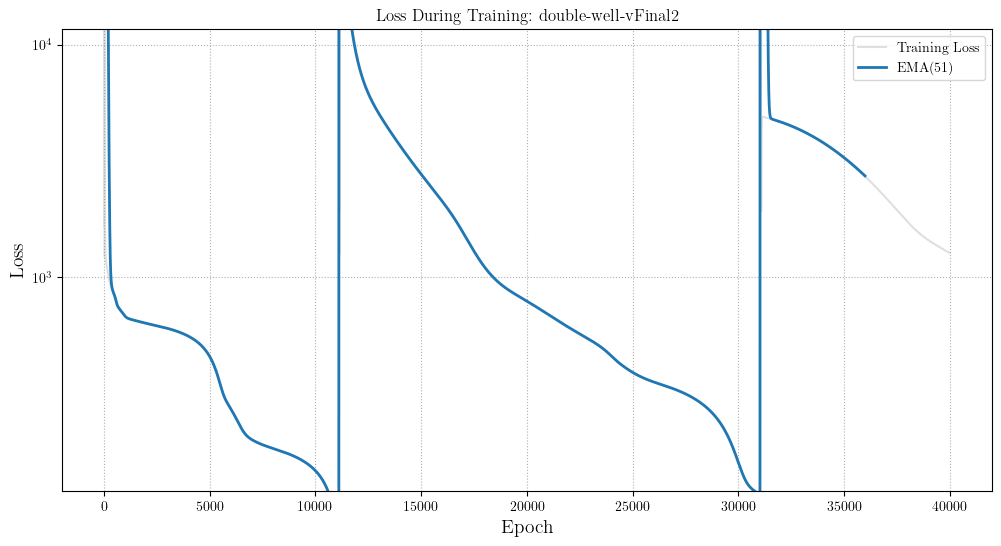

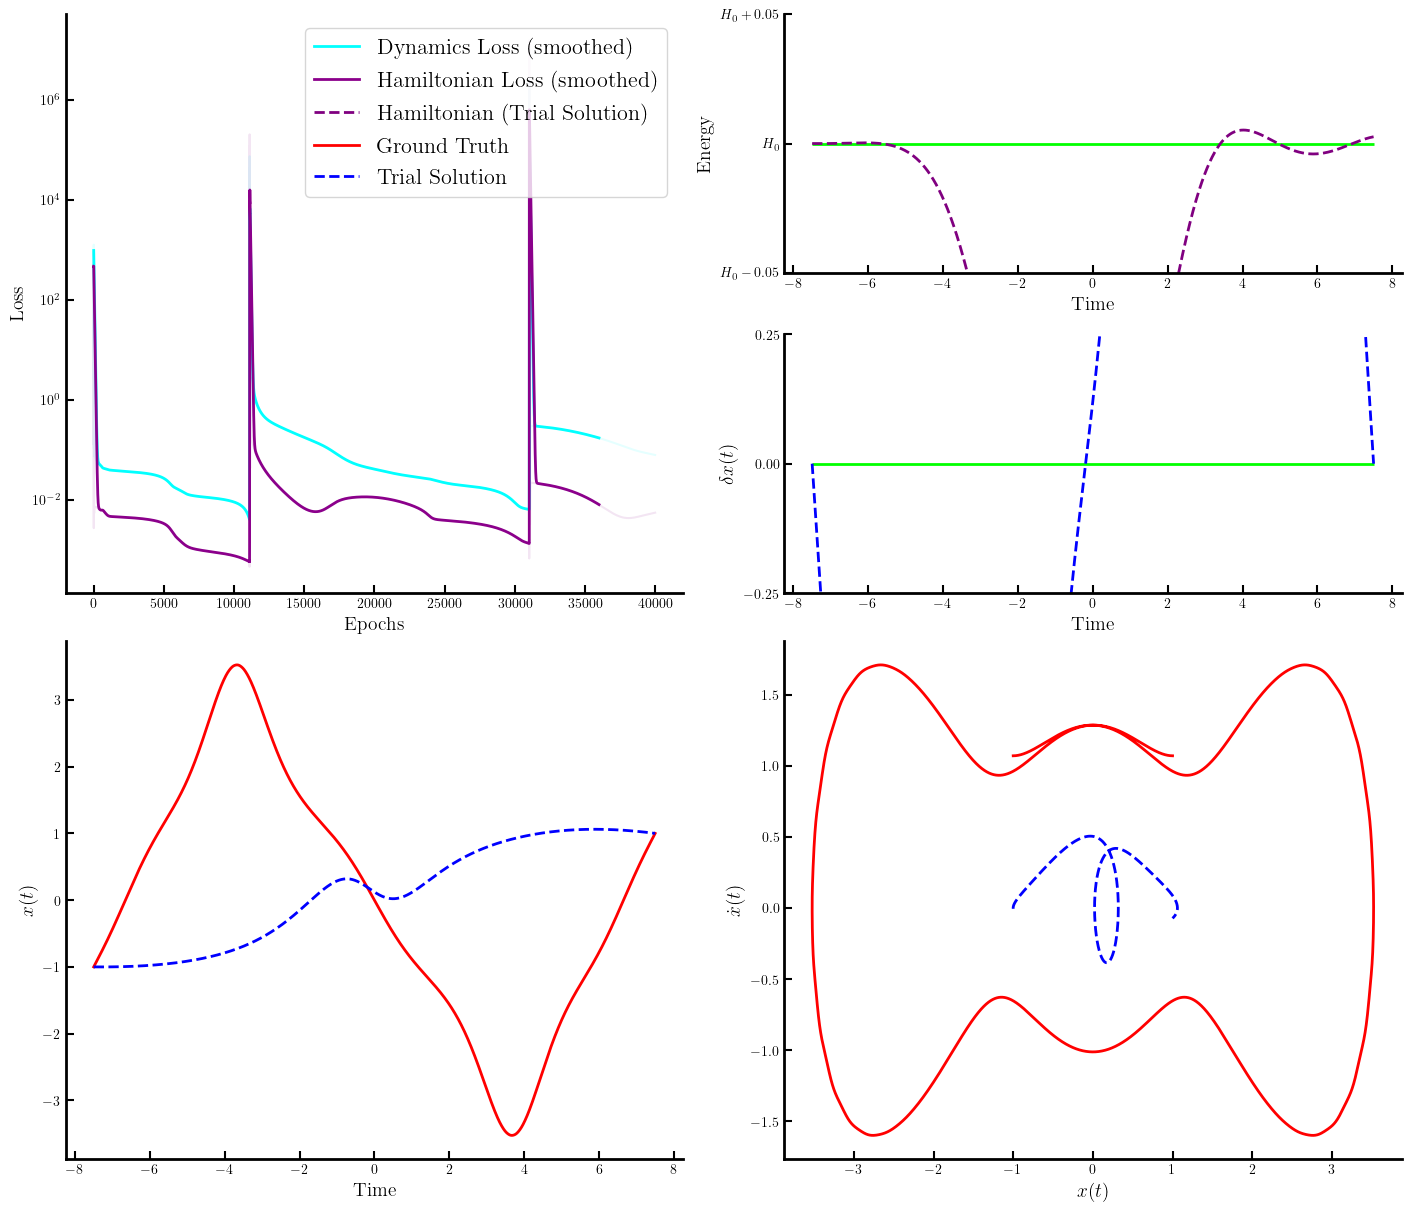

  0%|                                       | 1/40000 [00:00<1:57:26,  5.68it/s]

21693885.869676225


  0%|                                     | 101/40000 [00:14<1:38:36,  6.74it/s]

1193.77340505269


  1%|▏                                    | 201/40000 [00:28<1:35:21,  6.96it/s]

1123.439522590295


  1%|▎                                    | 301/40000 [00:44<1:37:34,  6.78it/s]

1052.5387257197908


  1%|▎                                    | 401/40000 [00:59<1:37:58,  6.74it/s]

989.6913355862034


  1%|▍                                    | 501/40000 [01:13<1:38:46,  6.66it/s]

937.6100125164522


  2%|▌                                    | 601/40000 [01:28<1:32:53,  7.07it/s]

895.747779617089


  2%|▋                                    | 701/40000 [01:43<1:36:08,  6.81it/s]

861.503463329216


  2%|▋                                    | 801/40000 [01:58<1:33:57,  6.95it/s]

831.4799596702106


  2%|▊                                    | 901/40000 [02:13<1:38:07,  6.64it/s]

802.5204734506466


  3%|▉                                   | 1001/40000 [02:27<1:37:21,  6.68it/s]

772.4782129293233


  3%|▉                                   | 1101/40000 [02:42<1:35:25,  6.79it/s]

741.0864068946005


  3%|█                                   | 1201/40000 [02:57<1:37:25,  6.64it/s]

710.8010151251783


  3%|█▏                                  | 1301/40000 [03:13<1:34:22,  6.83it/s]

685.7072197241553


  4%|█▎                                  | 1401/40000 [03:28<1:32:26,  6.96it/s]

667.7700657807657


  4%|█▎                                  | 1501/40000 [03:43<1:37:31,  6.58it/s]

655.5945156822971


  4%|█▍                                  | 1601/40000 [03:57<1:34:21,  6.78it/s]

646.9302596772283


  4%|█▌                                  | 1701/40000 [04:12<1:34:00,  6.79it/s]

640.157295061703


  5%|█▌                                  | 1801/40000 [04:27<1:33:42,  6.79it/s]

634.3225424815815


  5%|█▋                                  | 1901/40000 [04:43<1:34:31,  6.72it/s]

628.9211295891599


  5%|█▊                                  | 2001/40000 [04:58<1:32:38,  6.84it/s]

623.7079689208385


  5%|█▉                                  | 2101/40000 [05:13<1:38:24,  6.42it/s]

618.5699175112906


  6%|█▉                                  | 2201/40000 [05:27<1:33:00,  6.77it/s]

613.4537355506013


  6%|██                                  | 2301/40000 [05:42<1:35:01,  6.61it/s]

608.3313118285506


  6%|██▏                                 | 2401/40000 [05:58<1:34:28,  6.63it/s]

603.1849602141499


  6%|██▎                                 | 2501/40000 [06:13<1:35:54,  6.52it/s]

598.0019501738437


  7%|██▎                                 | 2601/40000 [06:27<1:30:04,  6.92it/s]

592.77274014985


  7%|██▍                                 | 2701/40000 [06:43<1:32:28,  6.72it/s]

587.4904822493112


  7%|██▌                                 | 2801/40000 [06:58<1:31:04,  6.81it/s]

582.150859418427


  7%|██▌                                 | 2901/40000 [07:12<1:36:13,  6.43it/s]

576.7519429199529


  8%|██▋                                 | 3001/40000 [07:27<1:29:52,  6.86it/s]

571.2939925679493


  8%|██▊                                 | 3101/40000 [07:42<1:31:45,  6.70it/s]

565.7792002507779


  8%|██▉                                 | 3201/40000 [07:57<1:33:19,  6.57it/s]

560.2113984447763


  8%|██▉                                 | 3301/40000 [08:12<1:29:32,  6.83it/s]

554.5957572375714


  9%|███                                 | 3401/40000 [08:27<1:28:07,  6.92it/s]

548.938488967883


  9%|███▏                                | 3501/40000 [08:41<1:30:48,  6.70it/s]

543.2465735086427


  9%|███▏                                | 3601/40000 [08:56<1:36:18,  6.30it/s]

537.5275112380342


  9%|███▎                                | 3701/40000 [09:12<1:27:27,  6.92it/s]

531.7891056915438


 10%|███▍                                | 3801/40000 [09:27<1:26:32,  6.97it/s]

526.0392742239928


 10%|███▌                                | 3901/40000 [09:42<1:31:11,  6.60it/s]

520.2858829964811


 10%|███▌                                | 4001/40000 [09:56<1:34:20,  6.36it/s]

514.5366024087725


 10%|███▋                                | 4101/40000 [10:11<1:27:24,  6.84it/s]

508.7987808866908


 11%|███▊                                | 4201/40000 [10:26<1:27:58,  6.78it/s]

503.07933893470465


 11%|███▊                                | 4301/40000 [10:41<1:39:43,  5.97it/s]

497.3846918859965


 11%|███▉                                | 4401/40000 [10:55<1:25:57,  6.90it/s]

491.7207191237607


 11%|████                                | 4501/40000 [11:10<1:28:05,  6.72it/s]

486.0928096876514


 12%|████▏                               | 4601/40000 [11:25<1:24:54,  6.95it/s]

480.50602808168037


 12%|████▏                               | 4701/40000 [11:39<1:26:57,  6.77it/s]

474.9654563230548


 12%|████▎                               | 4801/40000 [11:54<1:30:39,  6.47it/s]

469.47677051863093


 12%|████▍                               | 4901/40000 [12:09<1:28:57,  6.58it/s]

464.0470858775416


 13%|████▌                               | 5001/40000 [12:24<1:27:45,  6.65it/s]

458.68602553768983


 13%|████▌                               | 5101/40000 [12:39<1:24:43,  6.86it/s]

453.4068035966663


 13%|████▋                               | 5201/40000 [12:54<1:27:29,  6.63it/s]

448.22685585607866


 13%|████▊                               | 5301/40000 [13:09<1:23:21,  6.94it/s]

443.1672975851587


 14%|████▊                               | 5401/40000 [13:23<1:23:44,  6.89it/s]

438.2505069199495


 14%|████▉                               | 5501/40000 [13:38<1:23:40,  6.87it/s]

433.49577859157563


 14%|█████                               | 5601/40000 [13:53<1:25:26,  6.71it/s]

428.9142437098457


 14%|█████▏                              | 5701/40000 [14:08<1:22:56,  6.89it/s]

424.50523653126555


 15%|█████▏                              | 5801/40000 [14:23<1:24:32,  6.74it/s]

420.2558488465824


 15%|█████▎                              | 5901/40000 [14:37<1:23:37,  6.80it/s]

416.1436477798165


 15%|█████▍                              | 6001/40000 [14:53<1:24:51,  6.68it/s]

412.14101123951815


 15%|█████▍                              | 6101/40000 [15:08<1:22:56,  6.81it/s]

408.21936026192526


 16%|█████▌                              | 6201/40000 [15:24<1:22:49,  6.80it/s]

404.3523010504155


 16%|█████▋                              | 6301/40000 [15:39<1:20:16,  7.00it/s]

400.5174392068854


 16%|█████▊                              | 6401/40000 [15:53<1:22:52,  6.76it/s]

396.6970446330212


 16%|█████▊                              | 6501/40000 [16:08<1:23:35,  6.68it/s]

392.8778912239649


 17%|█████▉                              | 6601/40000 [16:23<1:35:03,  5.86it/s]

389.0505960773608


 17%|██████                              | 6701/40000 [16:38<1:24:24,  6.57it/s]

385.2087224413524


 17%|██████                              | 6801/40000 [16:54<1:21:37,  6.78it/s]

381.3478359196308


 17%|██████▏                             | 6901/40000 [17:08<1:20:20,  6.87it/s]

377.4646356804759


 18%|██████▎                             | 7001/40000 [17:23<1:19:46,  6.89it/s]

373.55622798988895


 18%|██████▍                             | 7101/40000 [17:38<1:18:51,  6.95it/s]

369.61956878441225


 18%|██████▍                             | 7201/40000 [17:53<1:25:08,  6.42it/s]

365.65107382031687


 18%|██████▌                             | 7301/40000 [18:08<1:20:45,  6.75it/s]

361.64637701031023


 19%|██████▋                             | 7401/40000 [18:23<1:16:29,  7.10it/s]

357.60020740884795


 19%|██████▊                             | 7501/40000 [18:38<1:17:39,  6.97it/s]

353.50635069734346


 19%|██████▊                             | 7601/40000 [18:53<1:19:18,  6.81it/s]

349.35766034152044


 19%|██████▉                             | 7701/40000 [19:08<1:20:46,  6.66it/s]

345.14608585582505


 20%|███████                             | 7801/40000 [19:22<1:18:34,  6.83it/s]

340.8626901419459


 20%|███████                             | 7901/40000 [19:37<1:18:22,  6.83it/s]

336.4976339698794


 20%|███████▏                            | 8001/40000 [19:52<1:19:07,  6.74it/s]

332.0401124428088


 20%|███████▎                            | 8101/40000 [20:07<1:17:23,  6.87it/s]

327.47823470960213


 21%|███████▍                            | 8201/40000 [20:21<1:16:57,  6.89it/s]

322.7988433577407


 21%|███████▍                            | 8301/40000 [20:36<1:20:22,  6.57it/s]

317.9872733229348


 21%|███████▌                            | 8401/40000 [20:51<1:14:39,  7.05it/s]

313.02705185627434


 21%|███████▋                            | 8501/40000 [21:06<1:17:41,  6.76it/s]

307.8995418068


 22%|███████▋                            | 8601/40000 [21:20<1:16:16,  6.86it/s]

302.583531550563


 22%|███████▊                            | 8701/40000 [21:35<1:16:51,  6.79it/s]

297.0547782987992


 22%|███████▉                            | 8801/40000 [21:50<1:18:26,  6.63it/s]

291.28551993400396


 22%|████████                            | 8901/40000 [22:05<1:15:59,  6.82it/s]

285.2439875741421


 23%|████████                            | 9001/40000 [22:20<1:14:35,  6.93it/s]

278.89398168361714


 23%|████████▏                           | 9101/40000 [22:35<1:20:13,  6.42it/s]

272.19462556765995


 23%|████████▎                           | 9201/40000 [22:50<1:16:24,  6.72it/s]

265.10049121661734


 23%|████████▎                           | 9301/40000 [23:05<1:12:59,  7.01it/s]

257.5624179114899


 24%|████████▍                           | 9401/40000 [23:20<1:13:44,  6.92it/s]

249.52953446220397


 24%|████████▌                           | 9501/40000 [23:34<1:10:07,  7.25it/s]

240.95327864281955


 24%|████████▋                           | 9601/40000 [23:48<1:11:56,  7.04it/s]

231.7946061071439


 24%|████████▋                           | 9701/40000 [24:03<1:10:50,  7.13it/s]

222.03607635083296


 25%|████████▊                           | 9801/40000 [24:17<1:14:22,  6.77it/s]

211.70091947903865


 25%|████████▉                           | 9901/40000 [24:32<1:12:34,  6.91it/s]

200.8809270372626


 25%|████████▊                          | 10001/40000 [24:47<1:13:33,  6.80it/s]

189.7725478451938


 25%|████████▊                          | 10101/40000 [25:02<1:14:48,  6.66it/s]

178.71289004147118


 26%|████████▉                          | 10201/40000 [25:16<1:14:12,  6.69it/s]

168.19085805421128


 26%|█████████                          | 10301/40000 [25:31<1:12:11,  6.86it/s]

158.7868721114533


 26%|█████████                          | 10401/40000 [25:46<1:12:20,  6.82it/s]

150.9982464770134


 26%|█████████▏                         | 10501/40000 [26:01<1:09:27,  7.08it/s]

144.99803838173978


 27%|█████████▎                         | 10601/40000 [26:16<1:10:07,  6.99it/s]

140.52760572881837


 27%|█████████▎                         | 10701/40000 [26:30<1:11:17,  6.85it/s]

137.0781513613755


 27%|█████████▍                         | 10801/40000 [26:45<1:10:05,  6.94it/s]

134.18817933282511


 27%|█████████▌                         | 10901/40000 [27:00<1:12:28,  6.69it/s]

131.57841977472424


 28%|█████████▋                         | 11001/40000 [27:15<1:12:30,  6.67it/s]

129.11491865073305


 28%|█████████▋                         | 11101/40000 [27:30<1:11:37,  6.72it/s]

126.73694424151678


 28%|█████████▊                         | 11201/40000 [27:45<1:15:27,  6.36it/s]

124.41383737135926


 28%|█████████▉                         | 11301/40000 [28:00<1:10:37,  6.77it/s]

122.12724926718492


 29%|█████████▉                         | 11401/40000 [28:15<1:09:50,  6.82it/s]

119.86486690973405


 29%|██████████                         | 11501/40000 [28:29<1:10:19,  6.75it/s]

117.61831001934061


 29%|██████████▏                        | 11601/40000 [28:44<1:09:51,  6.78it/s]

115.3825532645052


 29%|██████████▏                        | 11701/40000 [28:59<1:09:26,  6.79it/s]

113.15602827555833


 30%|██████████▎                        | 11801/40000 [29:14<1:10:34,  6.66it/s]

110.94112824117529


 30%|██████████▍                        | 11901/40000 [29:29<1:10:54,  6.60it/s]

108.74498143959943


 30%|██████████▌                        | 12001/40000 [29:46<1:08:45,  6.79it/s]

106.58031599616012


 30%|██████████▌                        | 12101/40000 [30:01<1:08:05,  6.83it/s]

104.46605267093457


 31%|██████████▋                        | 12201/40000 [30:15<1:08:23,  6.77it/s]

102.42697804033651


 31%|██████████▊                        | 12301/40000 [30:30<1:08:15,  6.76it/s]

100.49163940901536


 31%|██████████▊                        | 12401/40000 [30:45<1:07:21,  6.83it/s]

98.68784095747544


 31%|██████████▉                        | 12501/40000 [31:00<1:07:18,  6.81it/s]

97.03619409580328


 32%|███████████                        | 12601/40000 [31:15<1:07:32,  6.76it/s]

95.54386066606376


 32%|███████████                        | 12701/40000 [31:29<1:08:12,  6.67it/s]

94.20159953051711


 32%|███████████▏                       | 12801/40000 [31:44<1:06:05,  6.86it/s]

93.00595396567068


 32%|███████████▎                       | 12901/40000 [31:59<1:07:41,  6.67it/s]

91.93151529411102


 33%|███████████▍                       | 13001/40000 [32:14<1:07:13,  6.69it/s]

90.91531105963507


 33%|███████████▍                       | 13101/40000 [32:29<1:07:06,  6.68it/s]

89.95636630228235


 33%|███████████▌                       | 13201/40000 [32:44<1:06:42,  6.70it/s]

89.02120384216947


 33%|███████████▋                       | 13301/40000 [32:59<1:05:22,  6.81it/s]

88.10213250966491


 34%|███████████▋                       | 13401/40000 [33:14<1:07:29,  6.57it/s]

87.18910912411411


 34%|███████████▊                       | 13501/40000 [33:29<1:03:40,  6.94it/s]

86.2852014967518


 34%|███████████▉                       | 13601/40000 [33:44<1:06:49,  6.58it/s]

85.3745774590138


 34%|███████████▉                       | 13701/40000 [33:59<1:04:05,  6.84it/s]

84.47276464889886


 35%|████████████                       | 13801/40000 [34:14<1:05:21,  6.68it/s]

83.57611093374958


 35%|████████████▏                      | 13901/40000 [34:29<1:05:18,  6.66it/s]

82.65440505316099


 35%|████████████▎                      | 14001/40000 [34:44<1:03:29,  6.82it/s]

81.75868717386373


 35%|████████████▎                      | 14101/40000 [34:59<1:05:17,  6.61it/s]

80.81580070449414


 36%|████████████▍                      | 14201/40000 [35:14<1:04:47,  6.64it/s]

79.99044434186766


 36%|████████████▌                      | 14301/40000 [35:29<1:04:33,  6.63it/s]

78.96312574322494


 36%|████████████▌                      | 14401/40000 [35:45<1:03:37,  6.71it/s]

78.64550611131999


 36%|████████████▋                      | 14501/40000 [36:00<1:02:22,  6.81it/s]

77.08441656444658


 37%|████████████▊                      | 14601/40000 [36:15<1:02:47,  6.74it/s]

76.20889600512581


 37%|████████████▊                      | 14701/40000 [36:31<1:10:23,  5.99it/s]

75.20970842275966


 37%|████████████▉                      | 14801/40000 [36:46<1:00:23,  6.95it/s]

74.35631015255525


 37%|█████████████                      | 14901/40000 [37:01<1:01:13,  6.83it/s]

73.43182157354953


 38%|█████████████▏                     | 15001/40000 [37:15<1:01:52,  6.73it/s]

88.47135503045406


 38%|█████████████▏                     | 15101/40000 [37:30<1:00:44,  6.83it/s]

71.79130181539193


 38%|██████████████                       | 15201/40000 [37:45<59:50,  6.91it/s]

70.9962093264331


 38%|█████████████▍                     | 15301/40000 [38:00<1:02:23,  6.60it/s]

70.46256207600474


 39%|█████████████▍                     | 15401/40000 [38:15<1:01:25,  6.67it/s]

69.63821081645165


 39%|█████████████▌                     | 15501/40000 [38:30<1:08:32,  5.96it/s]

69.44324217267604


 39%|██████████████▍                      | 15601/40000 [38:45<59:34,  6.83it/s]

68.4625898025723


 39%|██████████████▌                      | 15701/40000 [39:00<58:34,  6.91it/s]

67.90161821838089


 40%|█████████████▊                     | 15801/40000 [39:14<1:00:17,  6.69it/s]

69.74170904500359


 40%|██████████████▋                      | 15901/40000 [39:29<58:59,  6.81it/s]

66.97253825415547


 40%|██████████████▊                      | 16001/40000 [39:44<59:14,  6.75it/s]

66.49915392090382


 40%|██████████████                     | 16101/40000 [39:59<1:01:21,  6.49it/s]

84.59480495782203


 41%|██████████████▉                      | 16201/40000 [40:14<56:49,  6.98it/s]

65.75385849786963


 41%|██████████████▎                    | 16301/40000 [40:29<1:00:13,  6.56it/s]

65.3492096688032


 41%|███████████████▏                     | 16401/40000 [40:45<56:57,  6.91it/s]

64.93631190633225


 41%|███████████████▎                     | 16501/40000 [41:00<59:20,  6.60it/s]

65.38026535757122


 42%|███████████████▎                     | 16601/40000 [41:15<58:07,  6.71it/s]

64.24561987887424


 42%|███████████████▍                     | 16701/40000 [41:30<59:11,  6.56it/s]

63.84706741471851


 42%|███████████████▌                     | 16801/40000 [41:45<57:04,  6.77it/s]

87.32680001476083


 42%|███████████████▋                     | 16901/40000 [42:00<58:16,  6.61it/s]

63.88081721951772


 43%|███████████████▋                     | 17001/40000 [42:15<56:42,  6.76it/s]

63.428674783634094


 43%|███████████████▊                     | 17101/40000 [42:30<57:16,  6.66it/s]

63.11831441699269


 43%|███████████████▉                     | 17201/40000 [42:45<56:30,  6.72it/s]

62.812318053366575


 43%|████████████████                     | 17301/40000 [43:01<56:03,  6.75it/s]

62.493582263666845


 44%|████████████████                     | 17401/40000 [43:17<57:05,  6.60it/s]

62.15823786816895


 44%|████████████████▏                    | 17501/40000 [43:31<54:03,  6.94it/s]

61.80383643976234


 44%|████████████████▎                    | 17601/40000 [43:46<54:59,  6.79it/s]

61.427919796683994


 44%|████████████████▎                    | 17701/40000 [44:01<55:06,  6.74it/s]

61.02779495844784


 45%|████████████████▍                    | 17801/40000 [44:16<54:03,  6.84it/s]

63.52548983230449


 45%|████████████████▌                    | 17901/40000 [44:31<54:38,  6.74it/s]

60.934198203253466


 45%|████████████████▋                    | 18001/40000 [44:46<53:45,  6.82it/s]

60.554381189608925


 45%|████████████████▋                    | 18101/40000 [45:01<53:27,  6.83it/s]

60.21005886933896


 46%|████████████████▊                    | 18201/40000 [45:16<54:17,  6.69it/s]

59.85165354722513


 46%|████████████████▉                    | 18301/40000 [45:30<52:02,  6.95it/s]

59.472072536760955


 46%|█████████████████                    | 18401/40000 [45:46<53:07,  6.78it/s]

59.06802579227814


 46%|█████████████████                    | 18501/40000 [46:01<53:02,  6.76it/s]

117.19767647920048


 47%|█████████████████▏                   | 18601/40000 [46:16<55:04,  6.48it/s]

58.71822188103712


 47%|█████████████████▎                   | 18701/40000 [46:31<51:52,  6.84it/s]

58.25631016281183


 47%|█████████████████▍                   | 18801/40000 [46:46<52:29,  6.73it/s]

57.83951082598382


 47%|█████████████████▍                   | 18901/40000 [47:01<51:29,  6.83it/s]

57.399458241702476


 48%|█████████████████▌                   | 19001/40000 [47:16<51:44,  6.76it/s]

56.92837119901125


 48%|█████████████████▋                   | 19101/40000 [47:30<52:18,  6.66it/s]

1052.0557878441298


 48%|█████████████████▊                   | 19201/40000 [47:45<51:51,  6.68it/s]

576.2831269848082


 48%|█████████████████▊                   | 19301/40000 [48:01<50:38,  6.81it/s]

570.0886742817225


 49%|█████████████████▉                   | 19401/40000 [48:16<54:57,  6.25it/s]

565.4984087043514


 49%|██████████████████                   | 19501/40000 [48:31<49:44,  6.87it/s]

561.0147231394558


 49%|██████████████████▏                  | 19601/40000 [48:46<49:14,  6.91it/s]

556.4701898199695


 49%|██████████████████▏                  | 19701/40000 [49:01<49:36,  6.82it/s]

551.8127817218993


 50%|██████████████████▎                  | 19801/40000 [49:16<50:45,  6.63it/s]

547.0106317257905


 50%|██████████████████▍                  | 19901/40000 [49:31<49:23,  6.78it/s]

542.0414265756243


 50%|██████████████████▌                  | 20001/40000 [49:46<49:02,  6.80it/s]

536.8892383022089


 50%|██████████████████▌                  | 20101/40000 [50:01<49:38,  6.68it/s]

531.5426776959866


 51%|██████████████████▋                  | 20201/40000 [50:16<49:33,  6.66it/s]

525.9937882585


 51%|██████████████████▊                  | 20301/40000 [50:31<48:21,  6.79it/s]

520.2374968732972


 51%|██████████████████▊                  | 20401/40000 [50:46<49:51,  6.55it/s]

514.2714890483685


 51%|██████████████████▉                  | 20501/40000 [51:02<48:24,  6.71it/s]

508.0964067400242


 52%|███████████████████                  | 20601/40000 [51:17<48:40,  6.64it/s]

501.7162886241877


 52%|███████████████████▏                 | 20701/40000 [51:32<49:45,  6.46it/s]

495.1391831180196


 52%|███████████████████▏                 | 20801/40000 [51:47<47:30,  6.74it/s]

488.3778606727136


 52%|███████████████████▎                 | 20901/40000 [52:02<50:45,  6.27it/s]

481.45053207225004


 53%|███████████████████▍                 | 21001/40000 [52:17<47:08,  6.72it/s]

474.3814437998712


 53%|███████████████████▌                 | 21101/40000 [52:32<46:17,  6.80it/s]

467.2011740607601


 53%|███████████████████▌                 | 21201/40000 [52:47<45:34,  6.87it/s]

459.94640511226527


 53%|███████████████████▋                 | 21301/40000 [53:02<48:24,  6.44it/s]

452.6589212881375


 54%|███████████████████▊                 | 21401/40000 [53:17<45:33,  6.80it/s]

445.383611429652


 54%|███████████████████▉                 | 21501/40000 [53:32<44:21,  6.95it/s]

438.1653783021161


 54%|███████████████████▉                 | 21601/40000 [53:47<45:32,  6.73it/s]

431.04509992739884


 54%|████████████████████                 | 21701/40000 [54:01<44:16,  6.89it/s]

424.0551248668311


 55%|████████████████████▏                | 21801/40000 [54:16<45:26,  6.68it/s]

417.2151150045974


 55%|████████████████████▎                | 21901/40000 [54:31<43:31,  6.93it/s]

410.52920732977395


 55%|████████████████████▎                | 22001/40000 [54:46<43:31,  6.89it/s]

403.9852910862043


 55%|████████████████████▍                | 22101/40000 [55:01<42:43,  6.98it/s]

397.55665975116483


 56%|████████████████████▌                | 22201/40000 [55:16<42:55,  6.91it/s]

391.2055777685539


 56%|████████████████████▋                | 22301/40000 [55:30<42:55,  6.87it/s]

384.8877207026063


 56%|████████████████████▋                | 22401/40000 [55:45<43:06,  6.80it/s]

378.5562708996784


 56%|████████████████████▊                | 22501/40000 [56:00<42:27,  6.87it/s]

372.1647146631502


 57%|████████████████████▉                | 22601/40000 [56:15<42:22,  6.84it/s]

365.6678896227799


 57%|████████████████████▉                | 22701/40000 [56:29<41:40,  6.92it/s]

359.02128678737034


 57%|█████████████████████                | 22801/40000 [56:44<43:22,  6.61it/s]

352.1788186002446


 57%|█████████████████████▏               | 22901/40000 [56:59<40:57,  6.96it/s]

345.0891574953503


 58%|█████████████████████▎               | 23001/40000 [57:14<40:05,  7.07it/s]

337.69033150186186


 58%|█████████████████████▎               | 23101/40000 [57:28<41:15,  6.83it/s]

329.9014666807676


 58%|█████████████████████▍               | 23201/40000 [57:43<42:32,  6.58it/s]

321.60906251170024


 58%|█████████████████████▌               | 23301/40000 [57:58<40:14,  6.92it/s]

312.6420196214817


 59%|█████████████████████▋               | 23401/40000 [58:13<41:09,  6.72it/s]

302.72227343724904


 59%|█████████████████████▋               | 23501/40000 [58:28<41:09,  6.68it/s]

291.35968734796063


 59%|█████████████████████▊               | 23601/40000 [58:42<40:59,  6.67it/s]

277.61533119027433


 59%|█████████████████████▉               | 23701/40000 [58:57<41:06,  6.61it/s]

259.57819037828995


 60%|██████████████████████               | 23801/40000 [59:12<40:35,  6.65it/s]

233.66348171498572


 60%|██████████████████████               | 23901/40000 [59:27<39:00,  6.88it/s]

198.8466813297533


 60%|██████████████████████▏              | 24001/40000 [59:42<40:28,  6.59it/s]

175.22395178506946


 60%|██████████████████████▎              | 24101/40000 [59:56<40:58,  6.47it/s]

163.48686653095933


 61%|█████████████████████▏             | 24201/40000 [1:00:11<38:44,  6.80it/s]

155.7717001747514


 61%|█████████████████████▎             | 24301/40000 [1:00:26<38:44,  6.75it/s]

150.55924461055588


 61%|█████████████████████▎             | 24401/40000 [1:00:41<44:16,  5.87it/s]

146.88461766702858


 61%|█████████████████████▍             | 24501/40000 [1:00:56<42:00,  6.15it/s]

144.00456846213123


 62%|█████████████████████▌             | 24601/40000 [1:01:11<38:13,  6.71it/s]

141.44334120719293


 62%|█████████████████████▌             | 24701/40000 [1:01:26<37:17,  6.84it/s]

138.93882876087494


 62%|█████████████████████▋             | 24801/40000 [1:01:41<44:13,  5.73it/s]

136.35118186519213


 62%|█████████████████████▊             | 24901/40000 [1:01:56<41:21,  6.09it/s]

133.60010073547437


 63%|█████████████████████▉             | 25001/40000 [1:02:11<36:15,  6.90it/s]

130.63233417718422


 63%|█████████████████████▉             | 25101/40000 [1:02:26<37:41,  6.59it/s]

127.40644304831099


 63%|██████████████████████             | 25201/40000 [1:02:41<40:13,  6.13it/s]

123.88615787757426


 63%|██████████████████████▏            | 25301/40000 [1:02:56<39:05,  6.27it/s]

120.03814789691683


 64%|██████████████████████▏            | 25401/40000 [1:03:11<36:34,  6.65it/s]

115.83250358637565


 64%|██████████████████████▎            | 25501/40000 [1:03:27<49:49,  4.85it/s]

111.2455454745286


 64%|██████████████████████▍            | 25601/40000 [1:03:43<35:51,  6.69it/s]

106.26533593034799


 64%|██████████████████████▍            | 25701/40000 [1:03:58<35:38,  6.69it/s]

100.9007171826186


 65%|██████████████████████▌            | 25801/40000 [1:04:13<34:40,  6.83it/s]

95.19468310526048


 65%|██████████████████████▋            | 25901/40000 [1:04:27<33:50,  6.94it/s]

89.24181145313672


 65%|██████████████████████▊            | 26001/40000 [1:04:42<36:12,  6.44it/s]

83.20628310611428


 65%|██████████████████████▊            | 26101/40000 [1:04:57<35:07,  6.60it/s]

77.33092203980027


 66%|██████████████████████▉            | 26201/40000 [1:05:12<34:25,  6.68it/s]

71.92072199121384


 66%|█████████████████████▋           | 26301/40000 [1:05:29<1:01:30,  3.71it/s]

67.28509902756507


 66%|███████████████████████            | 26401/40000 [1:05:44<33:44,  6.72it/s]

63.64461632636943


 66%|███████████████████████▏           | 26501/40000 [1:05:59<33:09,  6.79it/s]

61.04728922176514


 67%|███████████████████████▎           | 26601/40000 [1:06:14<33:07,  6.74it/s]

59.35619837886422


 67%|███████████████████████▎           | 26701/40000 [1:06:29<33:34,  6.60it/s]

58.32351690176015


 67%|███████████████████████▍           | 26801/40000 [1:06:44<32:41,  6.73it/s]

57.69516931019466


 67%|███████████████████████▌           | 26901/40000 [1:06:59<31:25,  6.95it/s]

57.27875661442923


 68%|███████████████████████▋           | 27001/40000 [1:07:13<31:11,  6.95it/s]

56.95672670646522


 68%|███████████████████████▋           | 27101/40000 [1:07:28<31:38,  6.79it/s]

56.66809447690791


 68%|███████████████████████▊           | 27201/40000 [1:07:43<31:10,  6.84it/s]

56.384974431896985


 68%|███████████████████████▉           | 27301/40000 [1:07:58<31:44,  6.67it/s]

56.09571175579906


 69%|███████████████████████▉           | 27401/40000 [1:08:13<31:17,  6.71it/s]

55.79556829228744


 69%|████████████████████████           | 27501/40000 [1:08:28<31:10,  6.68it/s]

55.48238239775709


 69%|████████████████████████▏          | 27601/40000 [1:08:43<30:35,  6.76it/s]

55.15478442266746


 69%|████████████████████████▏          | 27701/40000 [1:08:58<30:08,  6.80it/s]

54.811526823596935


 70%|████████████████████████▎          | 27801/40000 [1:09:13<29:47,  6.82it/s]

54.45123908927836


 70%|████████████████████████▍          | 27901/40000 [1:09:27<29:26,  6.85it/s]

54.072323353826675


 70%|████████████████████████▌          | 28001/40000 [1:09:42<30:34,  6.54it/s]

53.67288702657716


 70%|████████████████████████▌          | 28101/40000 [1:09:57<29:46,  6.66it/s]

53.2506780933584


 71%|████████████████████████▋          | 28201/40000 [1:10:12<29:25,  6.68it/s]

52.80301199016816


 71%|████████████████████████▊          | 28301/40000 [1:10:27<29:32,  6.60it/s]

52.32668551741306


 71%|████████████████████████▊          | 28401/40000 [1:10:42<29:22,  6.58it/s]

51.817874376956375


 71%|████████████████████████▉          | 28501/40000 [1:10:57<28:09,  6.81it/s]

51.27201023391495


 72%|█████████████████████████          | 28601/40000 [1:11:13<28:19,  6.71it/s]

50.683631704757026


 72%|█████████████████████████          | 28701/40000 [1:11:28<28:11,  6.68it/s]

50.046201518355915


 72%|█████████████████████████▏         | 28801/40000 [1:11:43<27:28,  6.79it/s]

49.35187929612675


 72%|█████████████████████████▎         | 28901/40000 [1:11:58<28:06,  6.58it/s]

48.92853308642986


 73%|█████████████████████████▍         | 29001/40000 [1:12:13<26:47,  6.84it/s]

48.20257107320204


 73%|█████████████████████████▍         | 29101/40000 [1:12:28<26:37,  6.82it/s]

47.48301143871465


 73%|█████████████████████████▌         | 29201/40000 [1:12:43<26:49,  6.71it/s]

1111.1934250285576


 73%|█████████████████████████▋         | 29301/40000 [1:12:59<28:13,  6.32it/s]

56.008619529174666


 74%|█████████████████████████▋         | 29401/40000 [1:13:14<26:54,  6.57it/s]

51.40468960122135


 74%|█████████████████████████▊         | 29501/40000 [1:13:29<27:15,  6.42it/s]

49.46887620731788


 74%|█████████████████████████▉         | 29601/40000 [1:13:44<27:16,  6.35it/s]

48.51468991740377


 74%|█████████████████████████▉         | 29701/40000 [1:14:01<25:15,  6.80it/s]

47.88541383479177


 75%|██████████████████████████         | 29801/40000 [1:14:16<25:28,  6.67it/s]

47.33561556389016


 75%|██████████████████████████▏        | 29901/40000 [1:14:30<24:40,  6.82it/s]

46.786865359669584


 75%|██████████████████████████▎        | 30001/40000 [1:14:46<24:38,  6.76it/s]

46.21584553361261


 75%|██████████████████████████▎        | 30101/40000 [1:15:01<24:30,  6.73it/s]

45.6145310290581


 76%|██████████████████████████▍        | 30201/40000 [1:15:16<23:58,  6.81it/s]

44.97833031557218


 76%|██████████████████████████▌        | 30301/40000 [1:15:31<24:00,  6.73it/s]

44.302963723492276


 76%|██████████████████████████▌        | 30401/40000 [1:15:46<24:17,  6.59it/s]

43.58372058447532


 76%|██████████████████████████▋        | 30501/40000 [1:16:01<23:35,  6.71it/s]

42.815307771234714


 77%|██████████████████████████▊        | 30601/40000 [1:16:16<23:25,  6.69it/s]

41.99185065313611


 77%|██████████████████████████▊        | 30701/40000 [1:16:32<22:57,  6.75it/s]

41.106963553376495


 77%|██████████████████████████▉        | 30801/40000 [1:16:48<22:47,  6.72it/s]

184302.83767798363


 77%|███████████████████████████        | 30901/40000 [1:17:03<22:54,  6.62it/s]

680.833119694735


 78%|███████████████████████████▏       | 31001/40000 [1:17:18<22:31,  6.66it/s]

651.9490711873816


 78%|███████████████████████████▏       | 31101/40000 [1:17:33<22:43,  6.53it/s]

635.89309742202


 78%|███████████████████████████▎       | 31201/40000 [1:17:48<21:50,  6.71it/s]

624.9047434212807


 78%|███████████████████████████▍       | 31301/40000 [1:18:04<21:17,  6.81it/s]

616.150534105044


 79%|███████████████████████████▍       | 31401/40000 [1:18:19<21:50,  6.56it/s]

608.103652900606


 79%|███████████████████████████▌       | 31501/40000 [1:18:34<23:06,  6.13it/s]

599.9918873722659


 79%|███████████████████████████▋       | 31601/40000 [1:18:49<21:02,  6.65it/s]

591.4061190039233


 79%|███████████████████████████▋       | 31701/40000 [1:19:04<20:26,  6.76it/s]

582.0872418176133


 80%|███████████████████████████▊       | 31800/40000 [1:19:19<47:17,  2.89it/s]

571.8154547465587


 80%|███████████████████████████▉       | 31901/40000 [1:19:35<20:25,  6.61it/s]

560.3463720534511


 80%|████████████████████████████       | 32001/40000 [1:19:50<19:44,  6.75it/s]

547.360311020452


 80%|████████████████████████████       | 32101/40000 [1:20:05<19:16,  6.83it/s]

532.400879103665


 81%|████████████████████████████▏      | 32201/40000 [1:20:20<19:24,  6.70it/s]

514.7764551635325


 81%|████████████████████████████▎      | 32301/40000 [1:20:35<19:21,  6.63it/s]

493.3806863051809


 81%|████████████████████████████▎      | 32401/40000 [1:20:50<19:06,  6.63it/s]

466.34892442519833


 81%|████████████████████████████▍      | 32501/40000 [1:21:05<18:28,  6.77it/s]

430.42642389756907


 82%|████████████████████████████▌      | 32601/40000 [1:21:20<18:36,  6.63it/s]

380.22413290136063


 82%|████████████████████████████▌      | 32701/40000 [1:21:36<19:25,  6.26it/s]

310.8466031301385


 82%|████████████████████████████▋      | 32801/40000 [1:21:51<18:05,  6.63it/s]

239.1245196303373


 82%|████████████████████████████▊      | 32901/40000 [1:22:06<17:11,  6.88it/s]

201.4684249692767


 83%|████████████████████████████▉      | 33001/40000 [1:22:21<17:40,  6.60it/s]

182.92152427514486


 83%|████████████████████████████▉      | 33101/40000 [1:22:36<17:15,  6.66it/s]

170.57877408359874


 83%|█████████████████████████████      | 33201/40000 [1:22:51<17:29,  6.48it/s]

161.0767384445678


 83%|█████████████████████████████▏     | 33301/40000 [1:23:07<16:25,  6.80it/s]

153.3482775428078


 84%|█████████████████████████████▏     | 33401/40000 [1:23:21<16:44,  6.57it/s]

146.911745951555


 84%|█████████████████████████████▎     | 33501/40000 [1:23:36<16:04,  6.74it/s]

141.42202333991017


 84%|█████████████████████████████▍     | 33601/40000 [1:23:52<16:00,  6.66it/s]

136.60733958504144


 84%|█████████████████████████████▍     | 33701/40000 [1:24:07<15:50,  6.62it/s]

132.26092185265847


 85%|█████████████████████████████▌     | 33801/40000 [1:24:22<15:54,  6.49it/s]

128.2337605210896


 85%|█████████████████████████████▋     | 33901/40000 [1:24:38<15:21,  6.62it/s]

124.42494125623664


 85%|█████████████████████████████▊     | 34001/40000 [1:24:54<15:22,  6.50it/s]

120.77119718402986


 85%|█████████████████████████████▊     | 34101/40000 [1:25:09<14:31,  6.77it/s]

117.2370801730099


 86%|█████████████████████████████▉     | 34201/40000 [1:25:24<14:11,  6.81it/s]

113.80651959982657


 86%|██████████████████████████████     | 34301/40000 [1:25:39<14:03,  6.75it/s]

110.47604675602474


 86%|██████████████████████████████     | 34401/40000 [1:25:55<14:17,  6.53it/s]

107.24964362144391


 86%|██████████████████████████████▏    | 34501/40000 [1:26:10<13:52,  6.61it/s]

104.13500263409796


 87%|██████████████████████████████▎    | 34601/40000 [1:26:25<13:30,  6.66it/s]

101.14092513130447


 87%|██████████████████████████████▎    | 34701/40000 [1:26:40<13:03,  6.77it/s]

98.27560103645769


 87%|██████████████████████████████▍    | 34801/40000 [1:26:55<13:11,  6.57it/s]

95.54556159104936


 87%|██████████████████████████████▌    | 34901/40000 [1:27:11<12:55,  6.58it/s]

92.95514781508095


 88%|██████████████████████████████▋    | 35001/40000 [1:27:26<12:38,  6.59it/s]

90.50637075376974


 88%|██████████████████████████████▋    | 35101/40000 [1:27:41<13:10,  6.20it/s]

88.19905232659667


 88%|██████████████████████████████▊    | 35201/40000 [1:27:57<12:19,  6.49it/s]

86.03113728824286


 88%|██████████████████████████████▉    | 35301/40000 [1:28:12<12:20,  6.35it/s]

83.9990715516668


 89%|██████████████████████████████▉    | 35401/40000 [1:28:28<11:24,  6.72it/s]

82.09815977599033


 89%|███████████████████████████████    | 35501/40000 [1:28:43<11:28,  6.53it/s]

80.32284628200492


 89%|███████████████████████████████▏   | 35601/40000 [1:28:59<11:27,  6.40it/s]

78.66690028558257


 89%|███████████████████████████████▏   | 35701/40000 [1:29:14<10:52,  6.59it/s]

77.12351842624722


 90%|███████████████████████████████▎   | 35801/40000 [1:29:29<10:44,  6.52it/s]

75.68537683832344


 90%|███████████████████████████████▍   | 35901/40000 [1:29:44<10:08,  6.73it/s]

74.34466972836188


 90%|███████████████████████████████▌   | 36001/40000 [1:30:01<10:08,  6.57it/s]

73.09316494585285


 90%|███████████████████████████████▌   | 36101/40000 [1:30:16<09:54,  6.56it/s]

71.92229498802534


 91%|███████████████████████████████▋   | 36201/40000 [1:30:31<09:23,  6.74it/s]

70.82328927387238


 91%|███████████████████████████████▊   | 36301/40000 [1:30:46<09:06,  6.77it/s]

69.78734330925226


 91%|███████████████████████████████▊   | 36401/40000 [1:31:01<08:50,  6.78it/s]

68.8058134863147


 91%|███████████████████████████████▉   | 36501/40000 [1:31:16<08:43,  6.69it/s]

67.87042247516484


 92%|████████████████████████████████   | 36601/40000 [1:31:31<08:34,  6.61it/s]

66.973458885979


 92%|████████████████████████████████   | 36701/40000 [1:31:46<08:27,  6.50it/s]

66.10795562109524


 92%|████████████████████████████████▏  | 36801/40000 [1:32:02<08:51,  6.02it/s]

65.26783376560913


 92%|████████████████████████████████▎  | 36901/40000 [1:32:17<08:01,  6.44it/s]

64.44800264372084


 93%|████████████████████████████████▍  | 37001/40000 [1:32:32<07:21,  6.79it/s]

63.64441130640799


 93%|████████████████████████████████▍  | 37101/40000 [1:32:47<07:08,  6.76it/s]

62.85405155227728


 93%|████████████████████████████████▌  | 37201/40000 [1:33:02<07:02,  6.62it/s]

62.07491689805447


 93%|████████████████████████████████▋  | 37301/40000 [1:33:17<06:46,  6.64it/s]

61.305925107487305


 94%|████████████████████████████████▋  | 37401/40000 [1:33:32<06:33,  6.61it/s]

60.546813626285235


 94%|████████████████████████████████▊  | 37501/40000 [1:33:49<06:15,  6.65it/s]

59.79801755513624


 94%|████████████████████████████████▉  | 37601/40000 [1:34:04<06:01,  6.63it/s]

59.060538908012056


 94%|████████████████████████████████▉  | 37701/40000 [1:34:19<05:35,  6.85it/s]

58.3358143003469


 95%|█████████████████████████████████  | 37801/40000 [1:34:34<05:48,  6.31it/s]

57.625586365931326


 95%|█████████████████████████████████▏ | 37901/40000 [1:34:49<05:10,  6.76it/s]

56.931782494343196


 95%|█████████████████████████████████▎ | 38001/40000 [1:35:05<05:01,  6.64it/s]

56.25640314085245


 95%|█████████████████████████████████▎ | 38101/40000 [1:35:20<05:06,  6.19it/s]

55.60142105992819


 96%|█████████████████████████████████▍ | 38201/40000 [1:35:36<04:45,  6.31it/s]

54.96869230388154


 96%|█████████████████████████████████▌ | 38301/40000 [1:35:51<04:16,  6.62it/s]

54.35987959409594


 96%|█████████████████████████████████▌ | 38401/40000 [1:36:06<04:05,  6.52it/s]

53.776388578101816


 96%|█████████████████████████████████▋ | 38501/40000 [1:36:21<03:43,  6.69it/s]

53.219317409711124


 97%|█████████████████████████████████▊ | 38601/40000 [1:36:37<03:32,  6.59it/s]

52.689419943135604


 97%|█████████████████████████████████▊ | 38701/40000 [1:36:52<03:14,  6.66it/s]

52.18708256878179


 97%|█████████████████████████████████▉ | 38801/40000 [1:37:08<02:58,  6.73it/s]

51.7123143348599


 97%|██████████████████████████████████ | 38901/40000 [1:37:23<02:47,  6.57it/s]

51.26474953124528


 98%|██████████████████████████████████▏| 39001/40000 [1:37:38<02:23,  6.98it/s]

50.84366142679376


 98%|██████████████████████████████████▏| 39101/40000 [1:37:53<02:15,  6.62it/s]

50.44798543054988


 98%|██████████████████████████████████▎| 39201/40000 [1:38:08<01:59,  6.71it/s]

50.07634966870569


 98%|██████████████████████████████████▍| 39301/40000 [1:38:24<01:50,  6.33it/s]

49.72711088556196


 99%|██████████████████████████████████▍| 39401/40000 [1:38:39<01:29,  6.67it/s]

49.39839370012763


 99%|██████████████████████████████████▌| 39501/40000 [1:38:54<01:15,  6.59it/s]

49.088131545882334


 99%|██████████████████████████████████▋| 39601/40000 [1:39:09<01:00,  6.61it/s]

48.794108016148755


 99%|██████████████████████████████████▋| 39701/40000 [1:39:24<00:44,  6.69it/s]

48.5139977382935


100%|██████████████████████████████████▊| 39801/40000 [1:39:39<00:30,  6.60it/s]

48.24540621921528


100%|██████████████████████████████████▉| 39901/40000 [1:39:55<00:15,  6.47it/s]

47.98590828415366


100%|███████████████████████████████████| 40000/40000 [1:40:10<00:00,  6.66it/s]


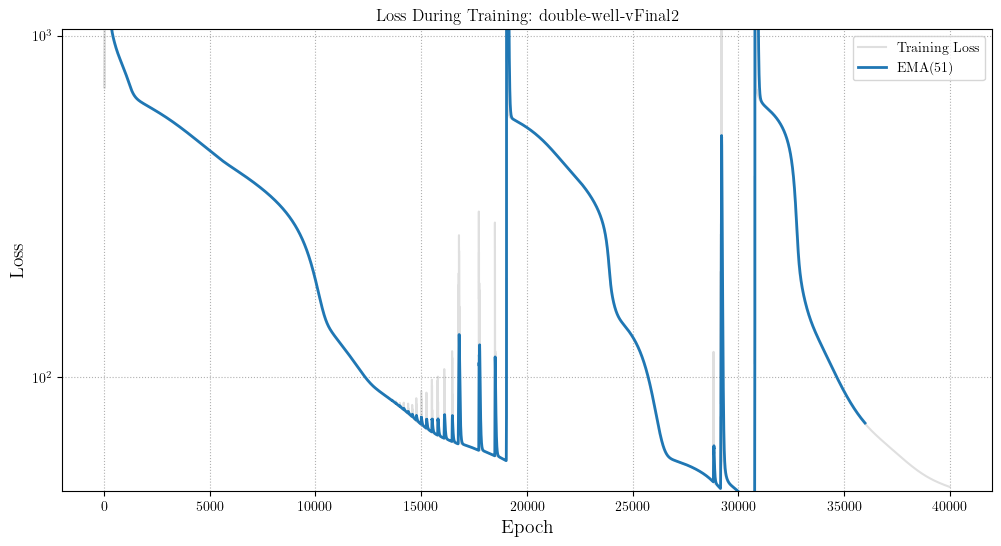

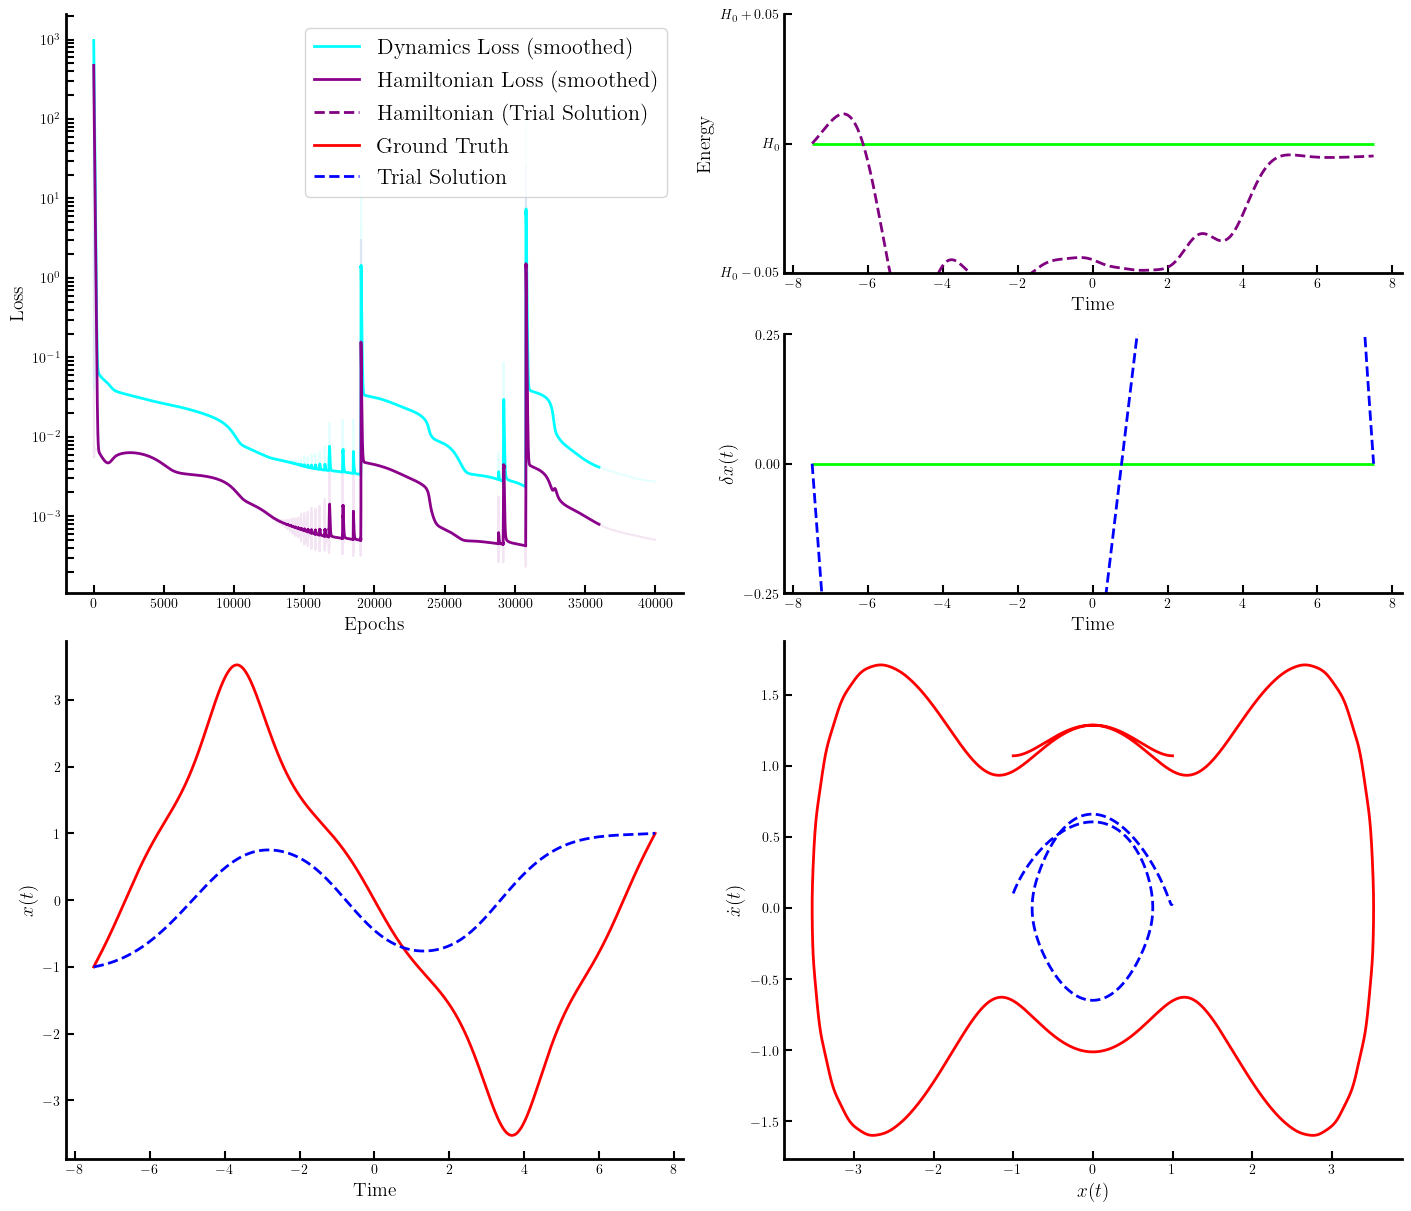

  0%|                                       | 1/40000 [00:00<1:53:56,  5.85it/s]

21693885.869676225


  0%|                                     | 101/40000 [00:15<1:37:23,  6.83it/s]

241692.83514096486


  1%|▏                                    | 201/40000 [00:30<1:44:26,  6.35it/s]

70334.9473013948


  1%|▎                                    | 301/40000 [00:45<1:39:55,  6.62it/s]

31142.378513474545


  1%|▎                                    | 401/40000 [01:00<1:36:52,  6.81it/s]

16932.40783134411


  1%|▍                                    | 501/40000 [01:15<1:39:22,  6.62it/s]

10442.743610902264


  2%|▌                                    | 601/40000 [01:30<1:40:09,  6.56it/s]

7027.859684101642


  2%|▋                                    | 701/40000 [01:47<1:37:05,  6.75it/s]

5048.61354251749


  2%|▋                                    | 801/40000 [02:02<1:37:48,  6.68it/s]

3817.485080412886


  2%|▊                                    | 901/40000 [02:16<1:36:41,  6.74it/s]

3008.9497958821585


  3%|▉                                   | 1001/40000 [02:32<1:36:38,  6.73it/s]

2454.3444679122936


  3%|▉                                   | 1101/40000 [02:47<1:38:53,  6.56it/s]

2059.958270550068


  3%|█                                   | 1201/40000 [03:02<1:35:25,  6.78it/s]

1770.7361531452163


  3%|█▏                                  | 1301/40000 [03:16<1:33:07,  6.93it/s]

1552.8224002557024


  4%|█▎                                  | 1401/40000 [03:32<1:36:03,  6.70it/s]

1384.5906380144918


  4%|█▎                                  | 1501/40000 [03:47<1:32:41,  6.92it/s]

1251.775443630577


  4%|█▍                                  | 1601/40000 [04:02<1:38:50,  6.47it/s]

1144.7057020372265


  4%|█▌                                  | 1701/40000 [04:17<1:33:24,  6.83it/s]

1056.669486486837


  5%|█▌                                  | 1801/40000 [04:32<1:33:31,  6.81it/s]

982.9144515382345


  5%|█▋                                  | 1901/40000 [04:48<1:33:38,  6.78it/s]

920.0184725238225


  5%|█▊                                  | 2001/40000 [05:03<1:32:47,  6.83it/s]

865.4829841940712


  5%|█▉                                  | 2101/40000 [05:18<1:38:06,  6.44it/s]

817.4640516260167


  6%|█▉                                  | 2201/40000 [05:34<1:32:35,  6.80it/s]

774.5907002763616


  6%|██                                  | 2301/40000 [05:49<1:36:03,  6.54it/s]

735.8396659578428


  6%|██▏                                 | 2401/40000 [06:04<1:38:14,  6.38it/s]

700.447232027439


  6%|██▎                                 | 2501/40000 [06:19<1:33:40,  6.67it/s]

667.8457533724214


  7%|██▎                                 | 2601/40000 [06:35<1:35:03,  6.56it/s]

637.6167623894424


  7%|██▍                                 | 2701/40000 [06:50<1:32:31,  6.72it/s]

609.4552981135444


  7%|██▌                                 | 2801/40000 [07:05<1:31:46,  6.76it/s]

583.1419187776338


  7%|██▌                                 | 2901/40000 [07:20<1:35:10,  6.50it/s]

558.5201092874606


  8%|██▋                                 | 3001/40000 [07:36<1:33:39,  6.58it/s]

535.4776807267659


  8%|██▊                                 | 3101/40000 [07:51<1:31:25,  6.73it/s]

513.931385995021


  8%|██▉                                 | 3201/40000 [08:06<1:33:18,  6.57it/s]

493.81439491513754


  8%|██▉                                 | 3301/40000 [08:21<1:31:39,  6.67it/s]

475.0665079307408


  9%|███                                 | 3401/40000 [08:37<1:31:36,  6.66it/s]

457.6270608437147


  9%|███▏                                | 3501/40000 [08:52<1:32:04,  6.61it/s]

441.4304173054139


  9%|███▏                                | 3601/40000 [09:07<1:29:25,  6.78it/s]

426.40381156769797


  9%|███▎                                | 3701/40000 [09:22<1:32:24,  6.55it/s]

412.46715206341906


 10%|███▍                                | 3801/40000 [09:37<1:31:01,  6.63it/s]

399.53428235228523


 10%|███▌                                | 3901/40000 [09:52<1:31:18,  6.59it/s]

387.5151547923179


 10%|███▌                                | 4001/40000 [10:07<1:32:00,  6.52it/s]

376.31841038332817


 10%|███▋                                | 4101/40000 [10:23<1:38:33,  6.07it/s]

365.8539568162771


 11%|███▊                                | 4201/40000 [10:39<1:30:31,  6.59it/s]

356.03526387508674


 11%|███▊                                | 4301/40000 [10:55<1:30:10,  6.60it/s]

346.7812196527154


 11%|███▉                                | 4401/40000 [11:10<1:27:27,  6.78it/s]

338.0174914730427


 11%|████                                | 4501/40000 [11:25<1:28:09,  6.71it/s]

329.6774038632861


 12%|████▏                               | 4601/40000 [11:40<1:26:34,  6.81it/s]

321.7023845917648


 12%|████▏                               | 4701/40000 [11:55<1:27:46,  6.70it/s]

314.04204618754795


 12%|████▎                               | 4801/40000 [12:10<1:31:47,  6.39it/s]

306.6539729224482


 12%|████▍                               | 4901/40000 [12:26<1:27:59,  6.65it/s]

299.50327876193404


 13%|████▌                               | 5001/40000 [12:41<1:43:32,  5.63it/s]

292.5619946876928


 13%|████▌                               | 5101/40000 [12:57<1:27:52,  6.62it/s]

285.80833639171385


 13%|████▋                               | 5201/40000 [13:12<1:26:17,  6.72it/s]

279.2258965782453


 13%|████▊                               | 5301/40000 [13:27<1:27:19,  6.62it/s]

272.8028001611852


 14%|████▊                               | 5401/40000 [13:43<1:28:22,  6.52it/s]

266.53085535089247


 14%|████▉                               | 5501/40000 [13:58<1:28:59,  6.46it/s]

260.4047287342553


 14%|█████                               | 5601/40000 [14:13<1:29:25,  6.41it/s]

254.42116773986544


 14%|█████▏                              | 5701/40000 [14:30<1:27:02,  6.57it/s]

248.57828920045654


 15%|█████▏                              | 5801/40000 [14:45<1:29:12,  6.39it/s]

242.87494802880548


 15%|█████▎                              | 5901/40000 [15:00<1:24:18,  6.74it/s]

237.3101953585281


 15%|█████▍                              | 6001/40000 [15:15<1:26:16,  6.57it/s]

231.88283099277166


 15%|█████▍                              | 6101/40000 [15:30<1:26:33,  6.53it/s]

226.59105082544002


 16%|█████▌                              | 6201/40000 [15:46<1:29:01,  6.33it/s]

221.4321862361049


 16%|█████▋                              | 6301/40000 [16:01<1:27:28,  6.42it/s]

216.4025294701787


 16%|█████▊                              | 6401/40000 [16:16<1:22:22,  6.80it/s]

211.49723680312104


 16%|█████▊                              | 6501/40000 [16:31<1:24:55,  6.57it/s]

206.71029988109944


 17%|█████▉                              | 6601/40000 [16:46<1:24:34,  6.58it/s]

202.0345749849708


 17%|██████                              | 6701/40000 [17:01<1:22:16,  6.75it/s]

197.46185997126543


 17%|██████                              | 6801/40000 [17:16<1:23:37,  6.62it/s]

192.98300915304344


 17%|██████▏                             | 6901/40000 [17:32<1:22:44,  6.67it/s]

188.58807723006092


 18%|██████▎                             | 7001/40000 [17:47<1:21:45,  6.73it/s]

184.2664844052043


 18%|██████▍                             | 7101/40000 [18:02<1:25:15,  6.43it/s]

180.00719590282347


 18%|██████▍                             | 7201/40000 [18:18<1:23:55,  6.51it/s]

175.79891014150286


 18%|██████▌                             | 7301/40000 [18:33<1:21:39,  6.67it/s]

171.63025075451253


 19%|██████▋                             | 7401/40000 [18:48<1:19:54,  6.80it/s]

167.48995847551816


 19%|██████▊                             | 7501/40000 [19:04<1:25:30,  6.33it/s]

163.367079620779


 19%|██████▊                             | 7601/40000 [19:19<1:20:42,  6.69it/s]

159.25114852382953


 19%|██████▉                             | 7701/40000 [19:34<1:21:30,  6.60it/s]

155.13236184285185


 20%|███████                             | 7801/40000 [19:50<1:20:34,  6.66it/s]

151.00174319170264


 20%|███████                             | 7901/40000 [20:05<1:22:07,  6.51it/s]

146.85129706260113


 20%|███████▏                            | 8001/40000 [20:20<1:20:26,  6.63it/s]

142.67415152004025


 20%|███████▎                            | 8101/40000 [20:36<1:20:21,  6.62it/s]

138.46468964502313


 21%|███████▍                            | 8201/40000 [20:51<1:20:11,  6.61it/s]

134.2186701735216


 21%|███████▍                            | 8301/40000 [21:07<1:19:26,  6.65it/s]

129.93333816234815


 21%|███████▌                            | 8401/40000 [21:22<1:19:01,  6.66it/s]

125.60752677100533


 21%|███████▋                            | 8501/40000 [21:37<1:20:37,  6.51it/s]

121.24175129412336


 22%|███████▋                            | 8601/40000 [21:53<1:21:23,  6.43it/s]

116.83829632678196


 22%|███████▊                            | 8701/40000 [22:09<1:20:41,  6.46it/s]

112.40129629759308


 22%|███████▉                            | 8801/40000 [22:24<1:20:33,  6.45it/s]

107.93680846733726


 22%|████████                            | 8901/40000 [22:40<1:19:16,  6.54it/s]

103.45287578652507


 23%|████████                            | 9001/40000 [22:55<1:16:45,  6.73it/s]

98.95957469337151


 23%|████████▏                           | 9101/40000 [23:10<1:17:46,  6.62it/s]

94.46904003893205


 23%|████████▎                           | 9201/40000 [23:25<1:19:13,  6.48it/s]

89.99545597227616


 23%|████████▎                           | 9301/40000 [23:41<1:16:24,  6.70it/s]

85.55499806810855


 24%|████████▍                           | 9401/40000 [23:58<1:16:57,  6.63it/s]

81.16570867535222


 24%|████████▌                           | 9501/40000 [24:13<1:16:29,  6.64it/s]

76.84728506557244


 24%|████████▋                           | 9601/40000 [24:28<1:15:32,  6.71it/s]

72.6207593469972


 24%|████████▋                           | 9701/40000 [24:43<1:16:41,  6.58it/s]

68.50805135043625


 25%|████████▊                           | 9801/40000 [24:58<1:16:06,  6.61it/s]

64.53138191742535


 25%|████████▉                           | 9901/40000 [25:13<1:16:57,  6.52it/s]

60.71254518360063


 25%|████████▊                          | 10001/40000 [25:30<1:24:06,  5.94it/s]

57.07205496513407


 25%|████████▊                          | 10101/40000 [25:45<1:23:44,  5.95it/s]

53.62820162757289


 26%|████████▉                          | 10201/40000 [26:01<1:14:53,  6.63it/s]

50.396079776604665


 26%|█████████                          | 10301/40000 [26:16<1:15:21,  6.57it/s]

47.38666995272877


 26%|█████████                          | 10401/40000 [26:32<1:16:31,  6.45it/s]

44.60607388233222


 26%|█████████▏                         | 10501/40000 [26:47<1:15:35,  6.50it/s]

42.05500671432397


 27%|█████████▎                         | 10601/40000 [27:02<1:13:45,  6.64it/s]

39.72863598403256


 27%|█████████▎                         | 10701/40000 [27:18<1:14:47,  6.53it/s]

37.616823739003486


 27%|█████████▍                         | 10801/40000 [27:33<1:13:45,  6.60it/s]

35.704778098075316


 27%|█████████▌                         | 10901/40000 [27:48<1:13:26,  6.60it/s]

33.974061691172636


 28%|█████████▋                         | 11001/40000 [28:04<1:14:33,  6.48it/s]

32.40384925716568


 28%|█████████▋                         | 11101/40000 [28:19<1:12:34,  6.64it/s]

30.972288338607598


 28%|█████████▊                         | 11201/40000 [28:34<1:11:37,  6.70it/s]

29.657805318303996


 28%|█████████▉                         | 11301/40000 [28:50<1:11:40,  6.67it/s]

28.44021692737434


 29%|█████████▉                         | 11401/40000 [29:05<1:12:04,  6.61it/s]

27.301549677665314


 29%|██████████                         | 11501/40000 [29:21<1:11:03,  6.68it/s]

26.22652498458754


 29%|██████████▏                        | 11601/40000 [29:36<1:10:37,  6.70it/s]

25.202722285278032


 29%|██████████▏                        | 11701/40000 [29:52<1:12:51,  6.47it/s]

24.220474616729547


 30%|██████████▎                        | 11801/40000 [30:08<1:31:34,  5.13it/s]

23.272574578284296


 30%|██████████▍                        | 11901/40000 [30:23<1:21:16,  5.76it/s]

22.353873085241887


 30%|██████████▌                        | 12001/40000 [30:38<1:10:30,  6.62it/s]

21.46084317320943


 30%|██████████▌                        | 12101/40000 [30:54<1:09:45,  6.67it/s]

20.591162784800737


 31%|██████████▋                        | 12201/40000 [31:09<1:10:01,  6.62it/s]

19.743350118448397


 31%|██████████▊                        | 12301/40000 [31:24<1:11:11,  6.48it/s]

18.91646713733697


 31%|██████████▊                        | 12401/40000 [31:40<1:08:26,  6.72it/s]

18.109893449534443


 31%|██████████▉                        | 12501/40000 [31:55<1:08:33,  6.68it/s]

17.32316438691837


 32%|███████████                        | 12601/40000 [32:10<1:07:44,  6.74it/s]

16.55586299911725


 32%|███████████                        | 12701/40000 [32:26<1:06:29,  6.84it/s]

15.807554626172527


 32%|███████████▏                       | 12801/40000 [32:41<1:10:59,  6.39it/s]

15.077753495284991


 32%|███████████▎                       | 12901/40000 [32:58<1:06:50,  6.76it/s]

14.365912418779669


 33%|███████████▍                       | 13001/40000 [33:13<1:07:16,  6.69it/s]

13.671428488481379


 33%|███████████▍                       | 13101/40000 [33:28<1:13:33,  6.09it/s]

12.993659296644205


 33%|███████████▌                       | 13201/40000 [33:43<1:06:12,  6.75it/s]

12.331945517684483


 33%|███████████▋                       | 13301/40000 [33:58<1:08:19,  6.51it/s]

11.685636651361932


 34%|███████████▋                       | 13401/40000 [34:13<1:09:14,  6.40it/s]

11.054117422289721


 34%|███████████▊                       | 13501/40000 [34:29<1:15:02,  5.89it/s]

10.436832841581694


 34%|███████████▉                       | 13601/40000 [34:44<1:09:48,  6.30it/s]

9.83331034615408


 34%|███████████▉                       | 13701/40000 [34:59<1:05:28,  6.69it/s]

9.243177800084375


 35%|████████████                       | 13801/40000 [35:15<1:04:26,  6.78it/s]

8.66617650480767


 35%|████████████▏                      | 13901/40000 [35:31<1:05:44,  6.62it/s]

8.102168731426273


 35%|████████████▎                      | 14001/40000 [35:47<1:09:19,  6.25it/s]

7.551139651624268


 35%|████████████▎                      | 14101/40000 [36:02<1:07:45,  6.37it/s]

7.013193885369685


 36%|████████████▍                      | 14201/40000 [36:17<1:04:47,  6.64it/s]

6.488547181469679


 36%|████████████▌                      | 14301/40000 [36:32<1:06:56,  6.40it/s]

5.977513980639327


 36%|████████████▌                      | 14401/40000 [36:48<1:03:35,  6.71it/s]

5.4804917655599805


 36%|████████████▋                      | 14501/40000 [37:03<1:03:29,  6.69it/s]

4.9979431723475125


 37%|████████████▊                      | 14601/40000 [37:18<1:03:08,  6.70it/s]

4.53037682601517


 37%|████████████▊                      | 14701/40000 [37:33<1:04:26,  6.54it/s]

4.078327780330507


 37%|████████████▉                      | 14801/40000 [37:49<1:03:38,  6.60it/s]

3.642338307814415


 37%|█████████████                      | 14901/40000 [38:04<1:02:36,  6.68it/s]

3.222939620059696


 38%|█████████████▏                     | 15001/40000 [38:19<1:03:00,  6.61it/s]

2.8206349242951454


 38%|█████████████▏                     | 15101/40000 [38:34<1:01:00,  6.80it/s]

2.4358840592132345


 38%|█████████████▎                     | 15201/40000 [38:49<1:03:57,  6.46it/s]

2.069089817126134


 38%|█████████████▍                     | 15301/40000 [39:04<1:03:16,  6.51it/s]

1.7205859603138502


 39%|█████████████▍                     | 15401/40000 [39:19<1:00:50,  6.74it/s]

1.3906268806252284


 39%|█████████████▌                     | 15501/40000 [39:34<1:01:25,  6.65it/s]

1.0793788310141303


 39%|█████████████▋                     | 15601/40000 [39:50<1:03:55,  6.36it/s]

0.7869126693429517


 39%|█████████████▋                     | 15701/40000 [40:05<1:01:55,  6.54it/s]

0.5131980892353537


 40%|█████████████▊                     | 15801/40000 [40:20<1:03:38,  6.34it/s]

0.2580993595225904


 40%|█████████████▉                     | 15901/40000 [40:36<1:00:55,  6.59it/s]

0.021372642560137406


 40%|██████████████▊                      | 16001/40000 [40:51<59:50,  6.68it/s]

-0.1973349967855088


 40%|██████████████▉                      | 16101/40000 [41:08<59:57,  6.64it/s]

-0.39848475277770656


 41%|██████████████▏                    | 16201/40000 [41:23<1:00:28,  6.56it/s]

-0.5826432654588926


 41%|██████████████▎                    | 16301/40000 [41:39<1:00:20,  6.55it/s]

-0.7504777030488746


 41%|███████████████▏                     | 16401/40000 [41:54<59:15,  6.64it/s]

-0.9027486517481293


 41%|██████████████▍                    | 16501/40000 [42:09<1:00:05,  6.52it/s]

-1.0403007894064447


 42%|███████████████▎                     | 16601/40000 [42:25<59:50,  6.52it/s]

-1.1640514055830895


 42%|███████████████▍                     | 16701/40000 [42:40<59:13,  6.56it/s]

-1.2749769332408283


 42%|███████████████▌                     | 16801/40000 [42:55<59:06,  6.54it/s]

-1.3740977700568546


 42%|███████████████▋                     | 16901/40000 [43:10<57:29,  6.70it/s]

-1.4624617816001704


 43%|███████████████▋                     | 17001/40000 [43:25<57:28,  6.67it/s]

-1.5411269844135147


 43%|███████████████▊                     | 17101/40000 [43:41<59:06,  6.46it/s]

-1.6111439935446479


 43%|███████████████▉                     | 17201/40000 [43:57<58:15,  6.52it/s]

-1.6735388757255867


 43%|████████████████                     | 17301/40000 [44:12<56:36,  6.68it/s]

-1.729297067146372


 44%|████████████████                     | 17401/40000 [44:27<57:11,  6.58it/s]

-1.7793489874643738


 44%|████████████████▏                    | 17501/40000 [44:42<55:57,  6.70it/s]

-1.8245579073273663


 44%|████████████████▎                    | 17601/40000 [44:57<56:17,  6.63it/s]

-1.8657105082612215


 44%|████████████████▎                    | 17701/40000 [45:12<55:19,  6.72it/s]

-1.9035104194879293


 45%|████████████████▍                    | 17801/40000 [45:27<55:20,  6.68it/s]

-1.9385748389530062


 45%|████████████████▌                    | 17901/40000 [45:43<55:31,  6.63it/s]

-1.9714341617113162


 45%|████████████████▋                    | 18001/40000 [45:58<54:34,  6.72it/s]

-2.0025343653101735


 45%|████████████████▋                    | 18101/40000 [46:13<54:59,  6.64it/s]

-2.0322417553547583


 46%|███████████████▉                   | 18201/40000 [46:28<1:00:46,  5.98it/s]

-2.060849568180722


 46%|████████████████▉                    | 18301/40000 [46:44<59:37,  6.07it/s]

-2.0885858695375368


 46%|█████████████████                    | 18401/40000 [46:59<55:51,  6.45it/s]

-2.1156221803822053


 46%|█████████████████                    | 18501/40000 [47:15<55:12,  6.49it/s]

-2.1420822992207107


 47%|█████████████████▏                   | 18601/40000 [47:31<57:41,  6.18it/s]

-2.168050865773877


 47%|█████████████████▎                   | 18701/40000 [47:46<56:22,  6.30it/s]

-2.1935813105984865


 47%|█████████████████▍                   | 18801/40000 [48:03<55:56,  6.32it/s]

-2.218702945937971


 47%|█████████████████▍                   | 18901/40000 [48:18<54:24,  6.46it/s]

-2.2434270616079095


 48%|█████████████████▌                   | 19001/40000 [48:34<55:52,  6.26it/s]

-2.2677519857285895


 48%|█████████████████▋                   | 19101/40000 [48:50<54:54,  6.34it/s]

-2.291667146694765


 48%|█████████████████▊                   | 19201/40000 [49:05<53:07,  6.53it/s]

-2.3151562268090347


 48%|█████████████████▊                   | 19301/40000 [49:20<52:04,  6.62it/s]

-2.3381995298152685


 49%|█████████████████▉                   | 19401/40000 [49:36<53:11,  6.45it/s]

-2.3607756970598475


 49%|█████████████████                  | 19500/40000 [49:52<2:07:18,  2.68it/s]

-2.382862904631506


 49%|██████████████████▏                  | 19601/40000 [50:08<51:53,  6.55it/s]

-2.404439661541958


 49%|██████████████████▏                  | 19701/40000 [50:24<52:58,  6.39it/s]

-2.425485311431246


 50%|██████████████████▎                  | 19801/40000 [50:39<52:12,  6.45it/s]

-2.4459803211558393


 50%|██████████████████▍                  | 19901/40000 [50:54<50:41,  6.61it/s]

-2.465906421561736


 50%|██████████████████▌                  | 20001/40000 [51:10<50:48,  6.56it/s]

-2.485246650268321


 50%|██████████████████▌                  | 20101/40000 [51:25<50:56,  6.51it/s]

-2.5039853339746894


 51%|██████████████████▋                  | 20201/40000 [51:40<49:44,  6.63it/s]

-2.5221080385703303


 51%|██████████████████▊                  | 20301/40000 [51:56<48:35,  6.76it/s]

-2.539601508710799


 51%|██████████████████▊                  | 20401/40000 [52:11<48:48,  6.69it/s]

-2.556453613859588


 51%|██████████████████▉                  | 20501/40000 [52:26<50:07,  6.48it/s]

-2.5726533144350854


 52%|███████████████████                  | 20601/40000 [52:41<50:06,  6.45it/s]

-2.588190659051747


 52%|███████████████████▏                 | 20701/40000 [52:57<49:17,  6.53it/s]

-2.6030568214435887


 52%|███████████████████▏                 | 20801/40000 [53:12<47:55,  6.68it/s]

-2.601550886011664


 52%|███████████████████▎                 | 20901/40000 [53:27<48:34,  6.55it/s]

-2.6297620681832354


 53%|███████████████████▍                 | 21001/40000 [53:42<49:20,  6.42it/s]

-2.641731026241404


 53%|███████████████████▌                 | 21101/40000 [53:58<48:19,  6.52it/s]

-2.652923344349543


 53%|███████████████████▌                 | 21201/40000 [54:13<48:21,  6.48it/s]

-2.663224911693091


 53%|███████████████████▋                 | 21301/40000 [54:29<53:59,  5.77it/s]

-2.672863255205453


 54%|███████████████████▊                 | 21401/40000 [54:44<54:09,  5.72it/s]

-2.6814824214504336


 54%|███████████████████▉                 | 21501/40000 [54:59<46:03,  6.70it/s]

-2.689613572187342


 54%|███████████████████▉                 | 21601/40000 [55:15<46:42,  6.56it/s]

-2.6941279176742077


 54%|████████████████████                 | 21701/40000 [55:30<50:21,  6.06it/s]

-2.7034939646079756


 55%|████████████████████▏                | 21801/40000 [55:46<45:36,  6.65it/s]

-2.7096073283157107


 55%|████████████████████▎                | 21901/40000 [56:02<45:44,  6.59it/s]

-2.715159919833568


 55%|████████████████████▎                | 22001/40000 [56:18<46:14,  6.49it/s]

-2.7203693173432173


 55%|████████████████████▍                | 22101/40000 [56:33<46:39,  6.39it/s]

-2.6700990647312373


 56%|████████████████████▌                | 22201/40000 [56:49<45:48,  6.48it/s]

-2.729345845827222


 56%|████████████████████▋                | 22301/40000 [57:04<45:41,  6.46it/s]

-2.7333603779208686


 56%|████████████████████▋                | 22401/40000 [57:20<43:49,  6.69it/s]

-2.7356558846788306


 56%|████████████████████▊                | 22501/40000 [57:35<43:46,  6.66it/s]

-2.7403270217128686


 57%|████████████████████▉                | 22601/40000 [57:51<46:45,  6.20it/s]

-2.743480834601147


 57%|████████████████████▉                | 22701/40000 [58:06<43:49,  6.58it/s]

-2.7325866612771836


 57%|█████████████████████                | 22801/40000 [58:21<43:20,  6.61it/s]

-2.748972676879802


 57%|█████████████████████▏               | 22901/40000 [58:37<43:02,  6.62it/s]

-2.7514656751920916


 58%|█████████████████████▎               | 23001/40000 [58:54<41:35,  6.81it/s]

-2.731877915764062


 58%|█████████████████████▎               | 23101/40000 [59:08<41:58,  6.71it/s]

-2.7558532409251955


 58%|█████████████████████▍               | 23201/40000 [59:24<42:06,  6.65it/s]

-2.7578367146957077


 58%|█████████████████████▌               | 23301/40000 [59:39<42:24,  6.56it/s]

-2.1768808861445974


 59%|█████████████████████▋               | 23401/40000 [59:54<41:39,  6.64it/s]

-2.761364899639204


 59%|████████████████████▌              | 23501/40000 [1:00:09<41:40,  6.60it/s]

-2.7629701251401824


 59%|████████████████████▋              | 23601/40000 [1:00:25<42:25,  6.44it/s]

-2.7644985595703786


 59%|████████████████████▋              | 23701/40000 [1:00:40<40:39,  6.68it/s]

-2.765713517729614


 60%|████████████████████▊              | 23801/40000 [1:00:55<40:20,  6.69it/s]

-2.7671492425778577


 60%|████████████████████▉              | 23901/40000 [1:01:10<40:00,  6.71it/s]

-2.7683801122934173


 60%|█████████████████████              | 24001/40000 [1:01:25<40:41,  6.55it/s]

-2.765332050316568


 60%|█████████████████████              | 24101/40000 [1:01:41<40:37,  6.52it/s]

-2.7705849613304143


 61%|█████████████████████▏             | 24201/40000 [1:01:56<39:36,  6.65it/s]

-2.7715842532877586


 61%|█████████████████████▎             | 24301/40000 [1:02:12<40:34,  6.45it/s]

-2.7725532561157267


 61%|█████████████████████▎             | 24401/40000 [1:02:27<38:43,  6.71it/s]

-2.7723251152629937


 61%|█████████████████████▍             | 24501/40000 [1:02:42<39:59,  6.46it/s]

-2.7742569514490127


 62%|█████████████████████▌             | 24601/40000 [1:02:58<38:40,  6.64it/s]

-2.775050300039556


 62%|█████████████████████▌             | 24701/40000 [1:03:13<39:02,  6.53it/s]

-1.880793400349536


 62%|█████████████████████▋             | 24801/40000 [1:03:28<46:01,  5.50it/s]

-2.7764881143539992


 62%|█████████████████████▊             | 24901/40000 [1:03:44<40:05,  6.28it/s]

-2.7771619514011845


 63%|█████████████████████▉             | 25001/40000 [1:04:00<38:24,  6.51it/s]

-2.7778037698294056


 63%|█████████████████████▉             | 25101/40000 [1:04:15<37:15,  6.67it/s]

-2.774169307127491


 63%|██████████████████████             | 25201/40000 [1:04:31<38:05,  6.48it/s]

-2.7789666721444104


 63%|██████████████████████▏            | 25301/40000 [1:04:46<37:09,  6.59it/s]

-2.7795019794985754


 64%|██████████████████████▏            | 25401/40000 [1:05:01<36:57,  6.58it/s]

-2.780030434572682


 64%|██████████████████████▎            | 25501/40000 [1:05:16<35:53,  6.73it/s]

-2.7774176099169026


 64%|██████████████████████▍            | 25601/40000 [1:05:33<37:21,  6.42it/s]

-2.780967473862294


 64%|██████████████████████▍            | 25701/40000 [1:05:49<35:33,  6.70it/s]

-2.7814012993581736


 65%|██████████████████████▌            | 25801/40000 [1:06:04<36:35,  6.47it/s]

-2.7818325535754775


 65%|██████████████████████▋            | 25901/40000 [1:06:19<35:53,  6.55it/s]

-2.6856048052726025


 65%|██████████████████████▊            | 26001/40000 [1:06:35<35:58,  6.49it/s]

-2.7826352271303496


 65%|██████████████████████▊            | 26101/40000 [1:06:50<34:49,  6.65it/s]

-2.7829953351119414


 66%|██████████████████████▉            | 26201/40000 [1:07:05<35:15,  6.52it/s]

-2.7833555142194575


 66%|███████████████████████            | 26301/40000 [1:07:21<34:28,  6.62it/s]

-2.7820329895594815


 66%|███████████████████████            | 26401/40000 [1:07:36<34:30,  6.57it/s]

-2.78399954981881


 66%|███████████████████████▏           | 26501/40000 [1:07:52<34:37,  6.50it/s]

-2.78434985776053


 67%|███████████████████████▎           | 26601/40000 [1:08:07<33:56,  6.58it/s]

-2.7846541312929443


 67%|███████████████████████▎           | 26701/40000 [1:08:22<36:26,  6.08it/s]

-2.784960383683521


 67%|███████████████████████▍           | 26801/40000 [1:08:38<33:33,  6.56it/s]

-2.7834275451706327


 67%|███████████████████████▌           | 26901/40000 [1:08:53<33:07,  6.59it/s]

-2.7855205896603272


 68%|███████████████████████▋           | 27001/40000 [1:09:08<33:21,  6.49it/s]

-2.7857823156709194


 68%|███████████████████████▋           | 27101/40000 [1:09:24<32:27,  6.62it/s]

-2.786046905111738


 68%|███████████████████████▊           | 27201/40000 [1:09:39<32:37,  6.54it/s]

-2.6831669413840786


 68%|███████████████████████▉           | 27301/40000 [1:09:55<32:22,  6.54it/s]

-2.7865447968818926


 69%|███████████████████████▉           | 27401/40000 [1:10:10<32:27,  6.47it/s]

-2.7867760643046524


 69%|████████████████████████           | 27501/40000 [1:10:26<31:38,  6.59it/s]

-2.787009039954041


 69%|████████████████████████▏          | 27601/40000 [1:10:42<31:41,  6.52it/s]

-2.36852265358329


 69%|████████████████████████▏          | 27701/40000 [1:10:57<31:40,  6.47it/s]

-2.7874566288538922


 70%|████████████████████████▎          | 27801/40000 [1:11:12<31:34,  6.44it/s]

-2.7876607287515482


 70%|████████████████████████▍          | 27901/40000 [1:11:28<34:51,  5.79it/s]

-2.7878687498539296


 70%|████████████████████████▌          | 28001/40000 [1:11:44<38:41,  5.17it/s]

-2.303777127079744


 70%|████████████████████████▌          | 28101/40000 [1:11:59<29:55,  6.63it/s]

-2.7882669323847327


 71%|████████████████████████▋          | 28201/40000 [1:12:15<29:37,  6.64it/s]

-2.788457794726046


 71%|████████████████████████▊          | 28301/40000 [1:12:30<30:18,  6.43it/s]

-2.788646283713163


 71%|████████████████████████▊          | 28401/40000 [1:12:47<28:42,  6.73it/s]

-2.1238526271005167


 71%|████████████████████████▉          | 28501/40000 [1:13:02<28:21,  6.76it/s]

-2.7890144898530154


 72%|█████████████████████████          | 28601/40000 [1:13:17<28:26,  6.68it/s]

-2.7891831396389195


 72%|█████████████████████████          | 28701/40000 [1:13:32<27:57,  6.73it/s]

-2.789355902602161


 72%|█████████████████████████▏         | 28801/40000 [1:13:48<27:28,  6.79it/s]

-2.5799241690278594


 72%|█████████████████████████▎         | 28901/40000 [1:14:03<28:32,  6.48it/s]

-2.789675399653704


 73%|█████████████████████████▍         | 29001/40000 [1:14:18<27:10,  6.75it/s]

-2.789848610064238


 73%|█████████████████████████▍         | 29101/40000 [1:14:33<27:31,  6.60it/s]

-2.7900078717663943


 73%|█████████████████████████▌         | 29201/40000 [1:14:48<26:20,  6.83it/s]

-1.484906715767844


 73%|█████████████████████████▋         | 29301/40000 [1:15:03<26:08,  6.82it/s]

-2.790321125262819


 74%|█████████████████████████▋         | 29401/40000 [1:15:19<26:55,  6.56it/s]

-2.7904613403529366


 74%|█████████████████████████▊         | 29501/40000 [1:15:35<26:33,  6.59it/s]

-2.7906055510780665


 74%|█████████████████████████▉         | 29601/40000 [1:15:50<25:41,  6.75it/s]

-2.7907540823176933


 74%|█████████████████████████▉         | 29701/40000 [1:16:05<25:29,  6.73it/s]

-2.7860458401715813


 75%|██████████████████████████         | 29801/40000 [1:16:21<26:22,  6.44it/s]

-2.791033462131428


 75%|██████████████████████████▏        | 29901/40000 [1:16:36<25:57,  6.48it/s]

-2.7911667157293505


 75%|██████████████████████████▎        | 30001/40000 [1:16:52<25:29,  6.54it/s]

-2.7913035987677595


 75%|██████████████████████████▎        | 30101/40000 [1:17:07<25:03,  6.58it/s]

-2.577094682013729


 76%|██████████████████████████▍        | 30201/40000 [1:17:23<25:01,  6.53it/s]

-2.7915582667014935


 76%|██████████████████████████▌        | 30301/40000 [1:17:38<24:49,  6.51it/s]

-2.7916937338765626


 76%|██████████████████████████▌        | 30401/40000 [1:17:54<25:23,  6.30it/s]

-2.791821004466575


 76%|██████████████████████████▋        | 30501/40000 [1:18:10<25:16,  6.27it/s]

-2.759380295070516


 77%|██████████████████████████▊        | 30601/40000 [1:18:25<24:23,  6.42it/s]

-2.791961562298652


 77%|██████████████████████████▊        | 30701/40000 [1:18:41<23:29,  6.60it/s]

-2.792190164429451


 77%|██████████████████████████▉        | 30801/40000 [1:18:56<24:36,  6.23it/s]

-2.792309727214884


 77%|███████████████████████████        | 30901/40000 [1:19:12<22:51,  6.64it/s]

-2.79241337465825


 78%|███████████████████████████▏       | 31001/40000 [1:19:27<22:34,  6.64it/s]

-2.7925242069706133


 78%|███████████████████████████▏       | 31101/40000 [1:19:43<22:30,  6.59it/s]

-2.792658569418771


 78%|███████████████████████████▎       | 31201/40000 [1:19:59<23:22,  6.27it/s]

-2.7927710574710876


 78%|███████████████████████████▍       | 31301/40000 [1:20:15<22:09,  6.54it/s]

-2.7928874161706516


 79%|███████████████████████████▍       | 31401/40000 [1:20:31<22:09,  6.47it/s]

-2.792812452972917


 79%|███████████████████████████▌       | 31501/40000 [1:20:47<21:38,  6.54it/s]

-2.7931022965077923


 79%|███████████████████████████▋       | 31601/40000 [1:21:03<21:41,  6.45it/s]

-2.7932090581117395


 79%|███████████████████████████▋       | 31701/40000 [1:21:18<20:51,  6.63it/s]

-2.793319604642625


 80%|███████████████████████████▊       | 31801/40000 [1:21:33<21:24,  6.38it/s]

-2.7931627528822203


 80%|███████████████████████████▉       | 31901/40000 [1:21:49<19:51,  6.79it/s]

-2.7935232422157927


 80%|████████████████████████████       | 32001/40000 [1:22:04<20:09,  6.61it/s]

-2.7936246014496677


 80%|████████████████████████████       | 32101/40000 [1:22:19<19:36,  6.71it/s]

-2.793729574701063


 81%|████████████████████████████▏      | 32201/40000 [1:22:35<19:46,  6.57it/s]

-2.7936087524328324


 81%|████████████████████████████▎      | 32301/40000 [1:22:50<19:24,  6.61it/s]

-2.7939242198825642


 81%|████████████████████████████▎      | 32401/40000 [1:23:05<18:43,  6.76it/s]

-2.7940211572537783


 81%|████████████████████████████▍      | 32501/40000 [1:23:21<19:14,  6.49it/s]

-2.794121488884561


 82%|████████████████████████████▌      | 32601/40000 [1:23:36<18:32,  6.65it/s]

-2.784258713635601


 82%|████████████████████████████▌      | 32701/40000 [1:23:52<18:42,  6.50it/s]

-2.7943063193711453


 82%|████████████████████████████▋      | 32801/40000 [1:24:07<18:21,  6.53it/s]

-2.7943974719689013


 82%|████████████████████████████▊      | 32901/40000 [1:24:22<20:45,  5.70it/s]

-2.794492046487968


 83%|████████████████████████████▉      | 33001/40000 [1:24:38<17:50,  6.54it/s]

-2.5565498765429178


 83%|████████████████████████████▉      | 33101/40000 [1:24:53<17:15,  6.66it/s]

-2.794662470419072


 83%|█████████████████████████████      | 33201/40000 [1:25:09<17:17,  6.55it/s]

-2.7947589170333558


 83%|█████████████████████████████▏     | 33301/40000 [1:25:24<17:28,  6.39it/s]

-2.7948488445397492


 84%|█████████████████████████████▏     | 33401/40000 [1:25:41<18:17,  6.01it/s]

-2.794786963841927


 84%|█████████████████████████████▎     | 33501/40000 [1:25:57<16:52,  6.42it/s]

-2.7948256647686427


 84%|█████████████████████████████▍     | 33601/40000 [1:26:12<16:30,  6.46it/s]

-2.795103245195158


 84%|█████████████████████████████▍     | 33701/40000 [1:26:28<16:06,  6.52it/s]

-2.795186856982436


 85%|█████████████████████████████▌     | 33801/40000 [1:26:44<17:03,  6.06it/s]

-2.795273703784547


 85%|█████████████████████████████▋     | 33901/40000 [1:26:59<15:33,  6.53it/s]

-2.795299336584964


 85%|█████████████████████████████▊     | 34001/40000 [1:27:15<16:03,  6.23it/s]

-2.7954347667665633


 85%|█████████████████████████████▊     | 34101/40000 [1:27:30<15:03,  6.53it/s]

-2.7955138147518084


 86%|█████████████████████████████▉     | 34201/40000 [1:27:46<15:05,  6.41it/s]

-2.79559549269012


 86%|██████████████████████████████     | 34301/40000 [1:28:02<14:38,  6.48it/s]

-2.795680298443651


 86%|██████████████████████████████     | 34401/40000 [1:28:18<14:41,  6.35it/s]

-2.794939539141529


 86%|██████████████████████████████▏    | 34501/40000 [1:28:34<13:43,  6.68it/s]

-2.795829430704849


 87%|██████████████████████████████▎    | 34601/40000 [1:28:49<14:35,  6.17it/s]

-2.795906755084897


 87%|██████████████████████████████▎    | 34701/40000 [1:29:06<13:13,  6.68it/s]

-2.79598709184436


 87%|██████████████████████████████▍    | 34801/40000 [1:29:21<13:00,  6.66it/s]

-2.7653347321829798


 87%|██████████████████████████████▌    | 34901/40000 [1:29:37<12:59,  6.54it/s]

-2.796132623939883


 88%|██████████████████████████████▋    | 35001/40000 [1:29:52<12:19,  6.76it/s]

-2.7962069110264154


 88%|██████████████████████████████▋    | 35101/40000 [1:30:08<12:16,  6.66it/s]

-2.7962834645145764


 88%|██████████████████████████████▊    | 35201/40000 [1:30:23<12:16,  6.52it/s]

-2.5523983845862537


 88%|██████████████████████████████▉    | 35301/40000 [1:30:38<11:51,  6.61it/s]

-2.796425803915128


 89%|██████████████████████████████▉    | 35401/40000 [1:30:53<11:41,  6.56it/s]

-2.7964964763450166


 89%|███████████████████████████████    | 35501/40000 [1:31:09<11:28,  6.54it/s]

-2.796569881446036


 89%|███████████████████████████████▏   | 35601/40000 [1:31:24<10:48,  6.78it/s]

-2.768395029728455


 89%|███████████████████████████████▏   | 35701/40000 [1:31:39<10:45,  6.66it/s]

-2.7966654534847812


 90%|███████████████████████████████▎   | 35801/40000 [1:31:55<10:50,  6.46it/s]

-2.796773849628851


 90%|███████████████████████████████▍   | 35901/40000 [1:32:10<10:33,  6.47it/s]

-2.7968432757937762


 90%|███████████████████████████████▌   | 36001/40000 [1:32:25<10:27,  6.38it/s]

-2.796915238807512


 90%|███████████████████████████████▌   | 36101/40000 [1:32:41<10:14,  6.35it/s]

-2.7962245263312826


 91%|███████████████████████████████▋   | 36201/40000 [1:32:56<09:38,  6.56it/s]

-2.797041621213969


 91%|███████████████████████████████▊   | 36301/40000 [1:33:12<09:35,  6.43it/s]

-2.797108131171284


 91%|███████████████████████████████▊   | 36401/40000 [1:33:27<09:10,  6.54it/s]

-2.797177331401225


 91%|███████████████████████████████▉   | 36501/40000 [1:33:42<09:11,  6.34it/s]

-2.797234679369606


 92%|████████████████████████████████   | 36601/40000 [1:33:58<08:34,  6.61it/s]

-2.7972989115002833


 92%|████████████████████████████████   | 36701/40000 [1:34:13<08:40,  6.34it/s]

-2.797361953968093


 92%|████████████████████████████████▏  | 36801/40000 [1:34:29<09:11,  5.80it/s]

-2.7974273660281117


 92%|████████████████████████████████▎  | 36901/40000 [1:34:45<08:09,  6.33it/s]

-2.5424288704039006


 93%|████████████████████████████████▍  | 37001/40000 [1:35:00<07:38,  6.54it/s]

-2.7975336778581354


 93%|████████████████████████████████▍  | 37101/40000 [1:35:16<07:33,  6.39it/s]

-2.797608420971409


 93%|████████████████████████████████▌  | 37201/40000 [1:35:32<07:04,  6.60it/s]

-2.797670982019758


 93%|████████████████████████████████▋  | 37301/40000 [1:35:47<06:53,  6.53it/s]

-2.7970112808707754


 94%|████████████████████████████████▋  | 37401/40000 [1:36:04<07:40,  5.65it/s]

-2.7977575614983965


 94%|████████████████████████████████▊  | 37501/40000 [1:36:19<06:31,  6.39it/s]

-2.797846296005289


 94%|████████████████████████████████▉  | 37601/40000 [1:36:35<06:09,  6.49it/s]

-2.797905673489679


 94%|████████████████████████████████▉  | 37701/40000 [1:36:51<05:47,  6.62it/s]

-2.7979674966927854


 95%|█████████████████████████████████  | 37801/40000 [1:37:06<05:36,  6.54it/s]

-2.789426692772929


 95%|█████████████████████████████████▏ | 37901/40000 [1:37:23<05:16,  6.63it/s]

-2.798076163674861


 95%|█████████████████████████████████▎ | 38001/40000 [1:37:38<05:03,  6.59it/s]

-2.798132946061857


 95%|█████████████████████████████████▎ | 38101/40000 [1:37:53<04:48,  6.59it/s]

-2.798191794346431


 96%|█████████████████████████████████▍ | 38201/40000 [1:38:09<04:32,  6.61it/s]

-2.7506850458899565


 96%|█████████████████████████████████▌ | 38301/40000 [1:38:24<04:36,  6.15it/s]

-2.7982956863150004


 96%|█████████████████████████████████▌ | 38401/40000 [1:38:39<04:02,  6.59it/s]

-2.798353921023732


 96%|█████████████████████████████████▋ | 38501/40000 [1:38:55<03:53,  6.43it/s]

-2.798410460529665


 97%|█████████████████████████████████▊ | 38601/40000 [1:39:10<03:31,  6.63it/s]

-1.3558600257698934


 97%|█████████████████████████████████▊ | 38701/40000 [1:39:25<03:16,  6.61it/s]

-2.798497507128727


 97%|█████████████████████████████████▉ | 38801/40000 [1:39:40<03:06,  6.44it/s]

-2.7985680936472814


 97%|██████████████████████████████████ | 38901/40000 [1:39:56<02:47,  6.54it/s]

-2.7986222450681075


 98%|██████████████████████████████████▏| 39001/40000 [1:40:11<02:32,  6.54it/s]

-2.7986780133650386


 98%|██████████████████████████████████▏| 39101/40000 [1:40:27<02:17,  6.53it/s]

-2.7983570302299894


 98%|██████████████████████████████████▎| 39201/40000 [1:40:42<02:05,  6.36it/s]

-2.7987758325339125


 98%|██████████████████████████████████▍| 39301/40000 [1:40:58<01:47,  6.52it/s]

-2.798827825603644


 99%|██████████████████████████████████▍| 39401/40000 [1:41:13<01:32,  6.45it/s]

-2.798881975016853


 99%|██████████████████████████████████▌| 39501/40000 [1:41:29<01:21,  6.14it/s]

-2.796711156452657


 99%|██████████████████████████████████▋| 39601/40000 [1:41:45<01:05,  6.09it/s]

-2.7989773417314137


 99%|██████████████████████████████████▋| 39701/40000 [1:42:00<00:46,  6.44it/s]

-2.7990277495817413


100%|██████████████████████████████████▊| 39801/40000 [1:42:15<00:29,  6.78it/s]

-2.7990801099506446


100%|██████████████████████████████████▉| 39901/40000 [1:42:31<00:15,  6.46it/s]

-2.7957936237666163


100%|███████████████████████████████████| 40000/40000 [1:42:48<00:00,  6.48it/s]


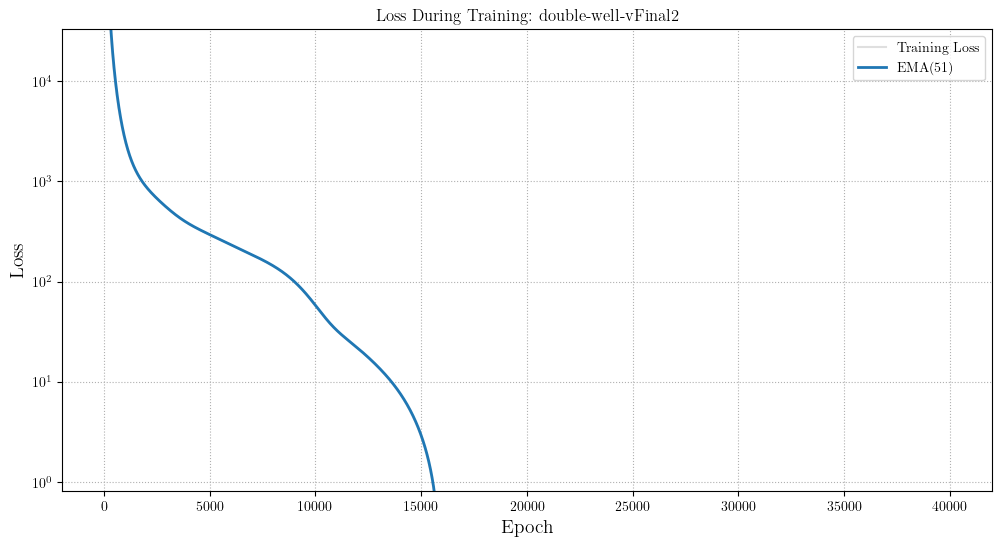

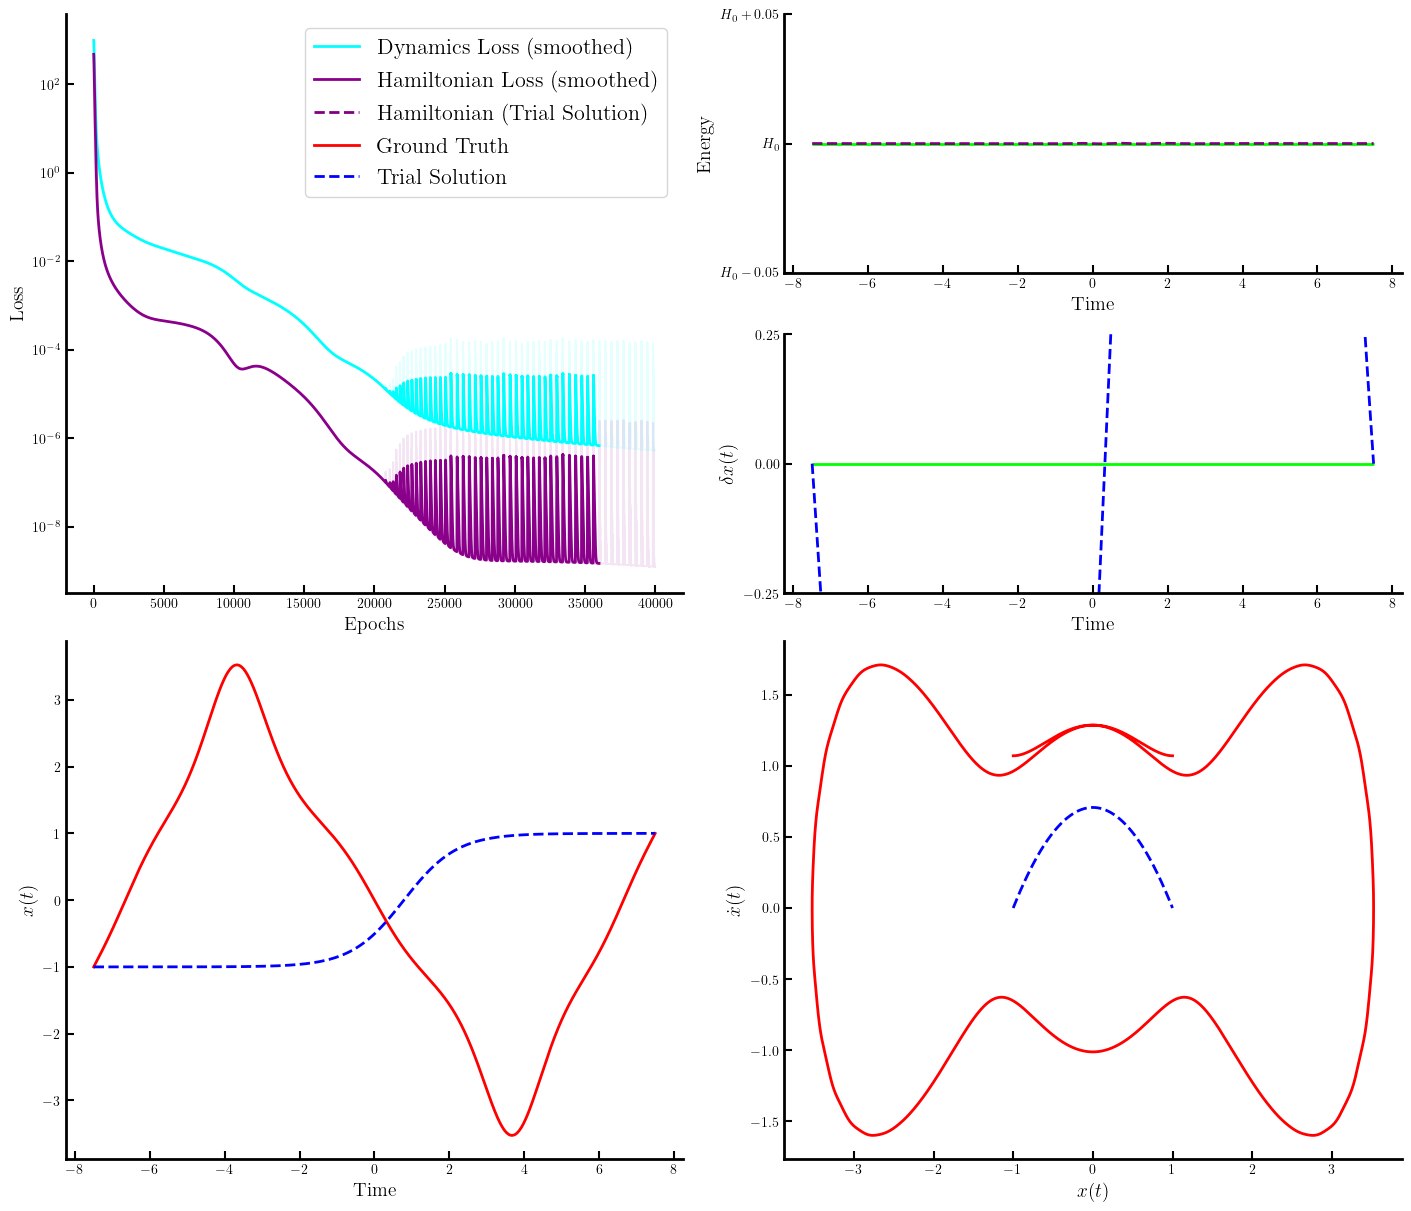

In [3]:
def main():
    lr_grid      = [1e-3, 1e-4, 1e-5]
    coeffs_grid = [(1.0, 1.0, 1.0)]

    for lr in lr_grid:
        for _coeffs in coeffs_grid:
            boundary_type = "dirichlet"
            configuration = Configuration(
                seed=4235,
                features=[64, 64, 64, 64, 64],
                activation_function=th.nn.Tanh(),
                learning_rate=lr,
                epochs =40_000,
                steps=15_000,
            )

            equations = DoubleWellEquation(
                function="x",
                domain=(-7.5,7.5),
                initial_conditions={
                    "x": (-7.5, -1),
                    "y": (7.5, 1),
                },
                coeffs = _coeffs,
                boundary_type=boundary_type
            )

            model = Model(
                name="double-well-vFinal2",
                configuration=configuration,
                system_equations=equations,
            )

            model.train()
            model.test1()

if __name__ == "__main__":
    main()

In [4]:
class InvertedDoubleWellEquation(SecondOrderEquations):
    """
    Physics-informed NN for the simple pendulum x'' + (x-x^3) = 0
    """
    def __init__(self, function, domain, initial_conditions, *, coeffs: tuple[float, float, float] = (1.0, 1.0, 1.0), boundary_type: str = "dirichlet"):
        super().__init__(function, domain, initial_conditions, boundary_type)
        a, b, c = coeffs
        self.coeffs = {"action": a, "dynamics": b, "hamiltonian": c}

    def configuration(self):
        config = super().configuration()
        config["coefficients"] = self.coeffs
        return config

    def equation(self, x, y, t):
        """
        Defines the second-order differential equation x'' = f(x, x', t).
        In this case, x'' = x - x^3.
        """
        return x - x**3

    def calculate_loss(self, inputs: th.Tensor, outputs: Dict[str, th.Tensor]) -> th.Tensor:

        trial = self.calculate_trial_solution(inputs, outputs)
        x_trial, x_dot = trial["x"], trial["y"]
        x_double_dot = compute_derivative(inputs, x_dot)
        
        # 3) residual penalties enforcing x'' = x - x**3
        mse_d = th.nn.MSELoss(reduction='sum')
        mse_dynamics = mse_d(x_double_dot, x_trial - x_trial**3)

        H = 0.5 * x_dot**2 - 0.5 * x_trial**2 + 0.25 * x_trial**4
        H_mean = H.mean()
        mse_hamiltonian = ((H - H_mean)**2).sum()
        
        # 4) pendulum Lagrangian L = ½ y² − (½ x² − 1/4 x^4)
        L = (0.5 * x_dot**2 + 0.5 * x_trial**2 - 0.25 * x_trial**4)
        action = th.trapz(L.view(-1), inputs.view(-1))
        #action = simpson_integral(L.view(-1), inputs.view(-1))
        
        t_idx_0 = (inputs - 0).abs().argmin()
        x0_pred = x_trial[t_idx_0]
        target_x0 = (2**0.5)
        
        # 5) combine (you can tune a,b if you like)
        a, b, c = self.coeffs["action"], self.coeffs["dynamics"], self.coeffs["hamiltonian"]
        total = a*action + b*mse_dynamics + c*mse_hamiltonian + 1000*(x0_pred - target_x0)**2

        return {"total": total, "dynamics": mse_dynamics, "hamiltonian": mse_hamiltonian}

    def system(self, t, z):
        x, y = z
        dxdt = y
        dydt = x-x**3
        return [dxdt, dydt]

  0%|                                       | 1/40000 [00:00<1:59:00,  5.60it/s]

12460812.268293843


  0%|                                     | 101/40000 [00:14<1:34:33,  7.03it/s]

1614.3204745799626


  1%|▏                                    | 201/40000 [00:28<1:34:14,  7.04it/s]

1235.9251999358762


  1%|▎                                    | 301/40000 [00:43<1:33:02,  7.11it/s]

1155.5507819472919


  1%|▎                                    | 401/40000 [00:57<1:35:39,  6.90it/s]

1114.1350790783763


  1%|▍                                    | 501/40000 [01:11<1:35:11,  6.92it/s]

1075.0935758150797


  2%|▌                                    | 601/40000 [01:26<1:33:57,  6.99it/s]

1035.8332795459435


  2%|▋                                    | 701/40000 [01:40<1:37:57,  6.69it/s]

998.2190036759416


  2%|▋                                    | 801/40000 [01:55<1:43:14,  6.33it/s]

964.023011508071


  2%|▊                                    | 901/40000 [02:09<1:36:57,  6.72it/s]

933.7958876246001


  3%|▉                                   | 1001/40000 [02:24<1:36:52,  6.71it/s]

906.7773179753353


  3%|▉                                   | 1101/40000 [02:38<1:34:03,  6.89it/s]

881.0882267876565


  3%|█                                   | 1201/40000 [02:53<1:34:58,  6.81it/s]

853.5810190557265


  3%|█▏                                  | 1301/40000 [03:08<1:34:09,  6.85it/s]

818.6812877549571


  4%|█▎                                  | 1401/40000 [03:23<1:32:01,  6.99it/s]

764.8028723691207


  4%|█▎                                  | 1501/40000 [03:37<1:35:29,  6.72it/s]

667.0319590280335


  4%|█▍                                  | 1601/40000 [03:52<1:33:41,  6.83it/s]

501.648511793974


  4%|█▌                                  | 1701/40000 [04:07<1:33:17,  6.84it/s]

337.82717195511765


  5%|█▌                                  | 1801/40000 [04:21<1:30:45,  7.01it/s]

248.65943927041846


  5%|█▋                                  | 1901/40000 [04:36<1:37:01,  6.54it/s]

204.49321973631197


  5%|█▊                                  | 2001/40000 [04:51<1:32:46,  6.83it/s]

174.29403830813436


  5%|█▉                                  | 2101/40000 [05:06<1:33:06,  6.78it/s]

148.5905488913845


  6%|█▉                                  | 2201/40000 [05:21<1:31:10,  6.91it/s]

126.03940560228668


  6%|██                                  | 2301/40000 [05:36<1:33:16,  6.74it/s]

106.80258814919088


  6%|██▏                                 | 2401/40000 [05:52<1:40:01,  6.27it/s]

90.99707465595871


  6%|██▎                                 | 2501/40000 [06:07<1:30:49,  6.88it/s]

78.46217847039765


  7%|██▎                                 | 2601/40000 [06:21<1:32:20,  6.75it/s]

68.79976624370711


  7%|██▍                                 | 2701/40000 [06:36<1:30:23,  6.88it/s]

61.47876240829919


  7%|██▌                                 | 2801/40000 [06:51<1:30:46,  6.83it/s]

55.9429908256103


  7%|██▌                                 | 2901/40000 [07:06<1:32:31,  6.68it/s]

51.69182998402884


  8%|██▋                                 | 3001/40000 [07:21<1:30:54,  6.78it/s]

48.32266495972995


  8%|██▊                                 | 3101/40000 [07:36<1:33:37,  6.57it/s]

45.539464053876245


  8%|██▉                                 | 3201/40000 [07:51<1:30:00,  6.81it/s]

43.13961823284243


  8%|██▉                                 | 3301/40000 [08:06<1:29:47,  6.81it/s]

40.99170238005736


  9%|███                                 | 3401/40000 [08:20<1:28:18,  6.91it/s]

39.01317641439915


  9%|███▏                                | 3501/40000 [08:35<1:28:10,  6.90it/s]

37.152538507208924


  9%|███▏                                | 3601/40000 [08:50<1:31:34,  6.62it/s]

35.37700607240421


  9%|███▎                                | 3701/40000 [09:05<1:30:52,  6.66it/s]

33.664933827261315


 10%|███▍                                | 3801/40000 [09:20<1:31:52,  6.57it/s]

32.00156237859945


 10%|███▌                                | 3901/40000 [09:35<1:33:38,  6.43it/s]

30.37678358197675


 10%|███▌                                | 4001/40000 [09:50<1:30:33,  6.63it/s]

28.78396941603898


 10%|███▋                                | 4101/40000 [10:05<1:28:07,  6.79it/s]

27.219284117264582


 11%|███▊                                | 4201/40000 [10:20<1:29:26,  6.67it/s]

25.681181127310936


 11%|███▊                                | 4301/40000 [10:35<1:30:20,  6.59it/s]

24.169961678882338


 11%|███▉                                | 4401/40000 [10:50<1:28:07,  6.73it/s]

22.687362779024514


 11%|████                                | 4501/40000 [11:06<1:28:54,  6.65it/s]

21.23617903599737


 12%|████▏                               | 4601/40000 [11:21<1:27:25,  6.75it/s]

19.81993029393887


 12%|████▏                               | 4701/40000 [11:36<1:31:09,  6.45it/s]

18.442582188780126


 12%|████▎                               | 4801/40000 [11:51<1:25:43,  6.84it/s]

17.10831904512822


 12%|████▍                               | 4901/40000 [12:06<1:24:55,  6.89it/s]

15.821362430613178


 13%|████▌                               | 5001/40000 [12:21<1:23:15,  7.01it/s]

14.585825534693361


 13%|████▌                               | 5101/40000 [12:36<1:25:01,  6.84it/s]

13.405593118792613


 13%|████▋                               | 5201/40000 [12:51<1:26:47,  6.68it/s]

12.284218244828867


 13%|████▊                               | 5301/40000 [13:07<1:46:15,  5.44it/s]

11.22482941761966


 14%|████▊                               | 5401/40000 [13:22<1:24:26,  6.83it/s]

10.230044471409729


 14%|████▉                               | 5501/40000 [13:37<1:23:22,  6.90it/s]

9.301890075108235


 14%|█████                               | 5601/40000 [13:52<1:26:01,  6.66it/s]

8.441727946004386


 14%|█████▏                              | 5701/40000 [14:06<1:22:32,  6.93it/s]

7.650190704038027


 15%|█████▏                              | 5801/40000 [14:21<1:26:18,  6.60it/s]

6.927131752557494


 15%|█████▎                              | 5901/40000 [14:36<1:24:22,  6.74it/s]

6.271594572891217


 15%|█████▍                              | 6001/40000 [14:51<1:23:26,  6.79it/s]

5.681807226459807


 15%|█████▍                              | 6101/40000 [15:06<1:23:05,  6.80it/s]

5.155207467826846


 16%|█████▌                              | 6201/40000 [15:21<1:22:36,  6.82it/s]

4.688502486570776


 16%|█████▋                              | 6301/40000 [15:36<1:31:35,  6.13it/s]

4.277764812265091


 16%|█████▊                              | 6401/40000 [15:51<1:23:13,  6.73it/s]

3.918562427352649


 16%|█████▊                              | 6501/40000 [16:06<1:24:53,  6.58it/s]

3.6061169982305334


 17%|█████▉                              | 6601/40000 [16:21<1:20:51,  6.88it/s]

3.3354799941012994


 17%|██████                              | 6701/40000 [16:35<1:20:11,  6.92it/s]

3.1017131457361122


 17%|██████                              | 6801/40000 [16:50<1:25:17,  6.49it/s]

2.9000580370977738


 17%|██████▏                             | 6901/40000 [17:05<1:22:08,  6.72it/s]

2.7260802167539686


 18%|██████▎                             | 7001/40000 [17:22<1:22:16,  6.69it/s]

2.575776194852593


 18%|██████▍                             | 7101/40000 [17:37<1:25:05,  6.44it/s]

2.445636615770861


 18%|██████▍                             | 7201/40000 [17:52<1:21:56,  6.67it/s]

2.332664827038947


 18%|██████▌                             | 7301/40000 [18:07<1:18:58,  6.90it/s]

2.2343558064475952


 19%|██████▋                             | 7401/40000 [18:22<1:22:58,  6.55it/s]

2.1486448447420536


 19%|██████▊                             | 7501/40000 [18:37<1:20:49,  6.70it/s]

2.073837775320411


 19%|██████▊                             | 7601/40000 [18:52<1:22:24,  6.55it/s]

2.008534702447908


 19%|██████▉                             | 7701/40000 [19:07<1:19:56,  6.73it/s]

1.9515574354630427


 20%|███████                             | 7801/40000 [19:22<1:20:54,  6.63it/s]

1.9018878696459458


 20%|███████                             | 7901/40000 [19:37<1:19:47,  6.70it/s]

1.8586211607818282


 20%|███████▏                            | 8001/40000 [19:52<1:22:20,  6.48it/s]

1.8209344166207289


 20%|███████▎                            | 8101/40000 [20:07<1:18:18,  6.79it/s]

1.7880692394370508


 21%|███████▍                            | 8201/40000 [20:21<1:19:07,  6.70it/s]

1.759324996837377


 21%|███████▍                            | 8301/40000 [20:37<1:18:25,  6.74it/s]

1.7340591413567195


 21%|███████▌                            | 8401/40000 [20:52<1:17:26,  6.80it/s]

1.7116910618187733


 21%|███████▋                            | 8501/40000 [21:06<1:16:32,  6.86it/s]

1.6917065839183776


 22%|███████▋                            | 8601/40000 [21:21<1:19:41,  6.57it/s]

1.6736610989623524


 22%|███████▊                            | 8701/40000 [21:36<1:19:56,  6.53it/s]

1.6571801873276344


 22%|███████▉                            | 8801/40000 [21:51<1:15:55,  6.85it/s]

1.6419573782587218


 22%|████████                            | 8901/40000 [22:06<1:14:54,  6.92it/s]

1.627749273786041


 23%|████████                            | 9001/40000 [22:21<1:16:06,  6.79it/s]

1.6143686376566915


 23%|████████▏                           | 9101/40000 [22:35<1:16:01,  6.77it/s]

1.6016762239712858


 23%|████████▎                           | 9201/40000 [22:50<1:15:27,  6.80it/s]

1.589572131870887


 23%|████████▎                           | 9301/40000 [23:05<1:13:23,  6.97it/s]

1.5779873701347873


 24%|████████▍                           | 9401/40000 [23:20<1:15:09,  6.79it/s]

1.5668761480287885


 24%|████████▌                           | 9501/40000 [23:35<1:17:19,  6.57it/s]

1.5562092193518569


 24%|████████▋                           | 9601/40000 [23:50<1:12:56,  6.95it/s]

1.54596842848564


 24%|████████▋                           | 9701/40000 [24:05<1:13:24,  6.88it/s]

1.5361424616367088


 25%|████████▊                           | 9801/40000 [24:19<1:15:12,  6.69it/s]

1.5267237033135947


 25%|████████▉                           | 9901/40000 [24:34<1:13:48,  6.80it/s]

1.5177060378720995


 25%|████████▊                          | 10001/40000 [24:49<1:12:27,  6.90it/s]

1.5090834126363015


 25%|████████▊                          | 10101/40000 [25:04<1:13:02,  6.82it/s]

1.5008489830817977


 26%|████████▉                          | 10201/40000 [25:19<1:12:11,  6.88it/s]

1.4929946815094204


 26%|█████████                          | 10301/40000 [25:34<1:16:14,  6.49it/s]

1.4855110793975597


 26%|█████████                          | 10401/40000 [25:49<1:14:22,  6.63it/s]

1.4783874433462834


 26%|█████████▏                         | 10501/40000 [26:04<1:12:17,  6.80it/s]

1.4716119109742765


 27%|█████████▎                         | 10601/40000 [26:19<1:12:02,  6.80it/s]

1.4651717343529398


 27%|█████████▎                         | 10701/40000 [26:34<1:15:06,  6.50it/s]

1.4590535543212657


 27%|█████████▍                         | 10801/40000 [26:49<1:11:40,  6.79it/s]

1.4532436800808153


 27%|█████████▌                         | 10901/40000 [27:04<1:13:00,  6.64it/s]

1.447728355991176


 28%|█████████▋                         | 11001/40000 [27:19<1:11:56,  6.72it/s]

1.4424940026576356


 28%|█████████▋                         | 11101/40000 [27:34<1:14:22,  6.48it/s]

1.4375274231661235


 28%|█████████▊                         | 11201/40000 [27:49<1:11:43,  6.69it/s]

1.4328159683328106


 28%|█████████▉                         | 11301/40000 [28:05<1:12:26,  6.60it/s]

1.4283476574671208


 29%|█████████▉                         | 11401/40000 [28:19<1:09:51,  6.82it/s]

1.4241112535636897


 29%|██████████                         | 11501/40000 [28:34<1:10:09,  6.77it/s]

1.4200962940646054


 29%|██████████▏                        | 11601/40000 [28:49<1:10:17,  6.73it/s]

1.4162930803295404


 29%|██████████▏                        | 11701/40000 [29:04<1:11:36,  6.59it/s]

1.4126926306524095


 30%|██████████▎                        | 11801/40000 [29:19<1:07:48,  6.93it/s]

2.4247761718684253


 30%|██████████▍                        | 11901/40000 [29:34<1:11:20,  6.56it/s]

1.9977593771654985


 30%|██████████▌                        | 12001/40000 [29:49<1:06:23,  7.03it/s]

3.7890107709629564


 30%|██████████▌                        | 12101/40000 [30:04<1:18:27,  5.93it/s]

1.5408583626511618


 31%|██████████▋                        | 12201/40000 [30:19<1:09:28,  6.67it/s]

1.4432896372119148


 31%|██████████▊                        | 12301/40000 [30:34<1:06:39,  6.92it/s]

3.769889061570279


 31%|██████████▊                        | 12401/40000 [30:49<1:09:44,  6.60it/s]

6.535535120085537


 31%|██████████▉                        | 12501/40000 [31:04<1:08:22,  6.70it/s]

14.506254429458865


 32%|███████████                        | 12601/40000 [31:19<1:07:56,  6.72it/s]

11.725886231393531


 32%|███████████                        | 12701/40000 [31:34<1:09:30,  6.55it/s]

12.49667231791537


 32%|███████████▏                       | 12801/40000 [31:49<1:06:21,  6.83it/s]

12.783191685125278


 32%|███████████▎                       | 12901/40000 [32:04<1:06:00,  6.84it/s]

12.977216630446485


 33%|███████████▍                       | 13001/40000 [32:19<1:05:36,  6.86it/s]

13.193741651231598


 33%|███████████▍                       | 13101/40000 [32:34<1:06:03,  6.79it/s]

13.40092506469392


 33%|███████████▌                       | 13201/40000 [32:49<1:06:43,  6.69it/s]

13.598043055041202


 33%|███████████▋                       | 13301/40000 [33:04<1:06:52,  6.65it/s]

13.79287234843151


 34%|███████████▋                       | 13401/40000 [33:19<1:04:59,  6.82it/s]

13.983648068059585


 34%|███████████▊                       | 13501/40000 [33:34<1:14:51,  5.90it/s]

14.172187162926788


 34%|███████████▉                       | 13601/40000 [33:50<1:04:09,  6.86it/s]

14.35946056981604


 34%|███████████▉                       | 13701/40000 [34:05<1:03:39,  6.89it/s]

14.546484245556421


 35%|████████████                       | 13801/40000 [34:20<1:04:40,  6.75it/s]

14.734369439206437


 35%|████████████▏                      | 13901/40000 [34:34<1:04:27,  6.75it/s]

14.924214057482999


 35%|████████████▎                      | 14001/40000 [34:49<1:04:55,  6.67it/s]

15.116968569859097


 35%|████████████▎                      | 14101/40000 [35:04<1:03:35,  6.79it/s]

15.313248729542146


 36%|████████████▍                      | 14201/40000 [35:19<1:02:18,  6.90it/s]

15.513122376384818


 36%|████████████▌                      | 14301/40000 [35:34<1:08:53,  6.22it/s]

15.715904217824978


 36%|████████████▌                      | 14401/40000 [35:48<1:01:17,  6.96it/s]

15.91999256762331


 36%|████████████▋                      | 14501/40000 [36:03<1:02:33,  6.79it/s]

16.122786401931418


 37%|████████████▊                      | 14601/40000 [36:18<1:01:24,  6.89it/s]

16.320721898408546


 37%|████████████▊                      | 14701/40000 [36:32<1:01:14,  6.89it/s]

16.509452648573095


 37%|████████████▉                      | 14801/40000 [36:47<1:01:44,  6.80it/s]

16.684166152567013


 37%|█████████████                      | 14901/40000 [37:02<1:01:40,  6.78it/s]

16.839994443001157


 38%|█████████████▏                     | 15001/40000 [37:17<1:00:52,  6.84it/s]

16.972452634100616


 38%|█████████████▏                     | 15101/40000 [37:32<1:01:06,  6.79it/s]

17.07783072218275


 38%|█████████████▎                     | 15201/40000 [37:47<1:00:31,  6.83it/s]

17.153470811183748


 38%|█████████████▍                     | 15301/40000 [38:01<1:01:01,  6.75it/s]

17.19788424189149


 39%|█████████████▍                     | 15401/40000 [38:16<1:01:20,  6.68it/s]

17.21070089006302


 39%|█████████████▌                     | 15501/40000 [38:31<1:00:23,  6.76it/s]

17.19248530926929


 39%|██████████████▍                      | 15601/40000 [38:46<58:47,  6.92it/s]

17.144487331163756


 39%|█████████████▋                     | 15701/40000 [39:01<1:02:22,  6.49it/s]

17.068404129700802


 40%|█████████████▊                     | 15801/40000 [39:16<1:00:19,  6.69it/s]

16.966212883818905


 40%|██████████████▋                      | 15901/40000 [39:31<59:42,  6.73it/s]

16.839905324911705


 40%|██████████████▊                      | 16001/40000 [39:46<59:31,  6.72it/s]

16.69333351805167


 40%|██████████████▉                      | 16101/40000 [40:01<59:44,  6.67it/s]

16.51637594090332


 41%|██████████████▉                      | 16201/40000 [40:16<58:17,  6.80it/s]

16.373328999130095


 41%|███████████████                      | 16301/40000 [40:31<58:07,  6.80it/s]

16.41953382465576


 41%|███████████████▏                     | 16401/40000 [40:46<58:13,  6.75it/s]

11.555783887126017


 41%|███████████████▎                     | 16501/40000 [41:01<58:14,  6.72it/s]

1.5281568472925133


 42%|███████████████▎                     | 16601/40000 [41:16<58:27,  6.67it/s]

10.04853814882748


 42%|███████████████▍                     | 16701/40000 [41:30<58:26,  6.64it/s]

7.831364953984573


 42%|███████████████▌                     | 16801/40000 [41:46<55:59,  6.91it/s]

4.277007947823393


 42%|███████████████▋                     | 16901/40000 [42:01<56:31,  6.81it/s]

2.448778963456955


 43%|███████████████▋                     | 17001/40000 [42:16<55:42,  6.88it/s]

23.530209698498204


 43%|███████████████▊                     | 17101/40000 [42:31<58:14,  6.55it/s]

55.82898055660779


 43%|███████████████▉                     | 17201/40000 [42:46<56:55,  6.67it/s]

1.6788794331327423


 43%|████████████████                     | 17301/40000 [43:01<59:55,  6.31it/s]

4.56600418603725


 44%|████████████████                     | 17401/40000 [43:17<56:52,  6.62it/s]

1.79135674328603


 44%|████████████████▏                    | 17501/40000 [43:32<56:52,  6.59it/s]

1.7320108965812668


 44%|████████████████▎                    | 17601/40000 [43:47<55:45,  6.70it/s]

28.18184753508377


 44%|████████████████▎                    | 17701/40000 [44:03<57:18,  6.49it/s]

1.5981852915845292


 45%|███████████████▌                   | 17801/40000 [44:18<1:00:04,  6.16it/s]

23.402615282098218


 45%|████████████████▌                    | 17901/40000 [44:34<54:45,  6.73it/s]

6.705604573551077


 45%|████████████████▋                    | 18001/40000 [44:49<56:41,  6.47it/s]

15.026862051462405


 45%|████████████████▋                    | 18101/40000 [45:05<56:20,  6.48it/s]

17.36514846881147


 46%|████████████████▊                    | 18201/40000 [45:21<54:24,  6.68it/s]

11.082728573932014


 46%|████████████████                   | 18301/40000 [45:36<1:01:14,  5.90it/s]

15.160967839913418


 46%|█████████████████                    | 18401/40000 [45:52<52:25,  6.87it/s]

16.062497542054814


 46%|█████████████████                    | 18501/40000 [46:07<55:19,  6.48it/s]

15.782375625470646


 47%|█████████████████▏                   | 18601/40000 [46:22<54:36,  6.53it/s]

28.730124841406894


 47%|█████████████████▎                   | 18701/40000 [46:38<52:51,  6.72it/s]

9.734302428646544


 47%|█████████████████▍                   | 18801/40000 [46:53<53:30,  6.60it/s]

7.914689515953826


 47%|█████████████████▍                   | 18901/40000 [47:08<51:41,  6.80it/s]

14.186649254085276


 48%|█████████████████▌                   | 19001/40000 [47:23<53:16,  6.57it/s]

11.058500041882244


 48%|█████████████████▋                   | 19101/40000 [47:38<51:42,  6.74it/s]

20.43055623039069


 48%|█████████████████▊                   | 19201/40000 [47:53<53:02,  6.54it/s]

14.803101871810735


 48%|█████████████████▊                   | 19301/40000 [48:08<52:09,  6.61it/s]

12.04199046424923


 49%|█████████████████▉                   | 19401/40000 [48:23<51:34,  6.66it/s]

15.435132813684808


 49%|██████████████████                   | 19501/40000 [48:38<51:18,  6.66it/s]

23230.1681412322


 49%|██████████████████▏                  | 19601/40000 [48:53<51:26,  6.61it/s]

22310.165926725724


 49%|██████████████████▏                  | 19701/40000 [49:09<52:06,  6.49it/s]

10675.24075893735


 50%|██████████████████▎                  | 19801/40000 [49:24<50:29,  6.67it/s]

6646.294577332673


 50%|██████████████████▍                  | 19901/40000 [49:40<57:00,  5.88it/s]

4758.885427517017


 50%|██████████████████▌                  | 20001/40000 [49:55<57:47,  5.77it/s]

3726.989321347634


 50%|██████████████████▌                  | 20101/40000 [50:11<48:10,  6.88it/s]

3106.848345647466


 51%|██████████████████▋                  | 20201/40000 [50:26<48:23,  6.82it/s]

2709.6604262489127


 51%|██████████████████▊                  | 20301/40000 [50:41<47:52,  6.86it/s]

2443.4498640934044


 51%|██████████████████▊                  | 20401/40000 [50:56<49:48,  6.56it/s]

2258.915118004959


 51%|██████████████████▉                  | 20501/40000 [51:11<49:11,  6.61it/s]

2127.6738141328483


 52%|███████████████████                  | 20601/40000 [51:26<47:35,  6.79it/s]

2032.4556767759382


 52%|███████████████████▏                 | 20701/40000 [51:41<47:09,  6.82it/s]

1962.2765767849955


 52%|███████████████████▏                 | 20801/40000 [51:56<46:37,  6.86it/s]

1909.8936537083541


 52%|███████████████████▎                 | 20901/40000 [52:11<47:56,  6.64it/s]

1870.3858739817229


 53%|███████████████████▍                 | 21001/40000 [52:25<45:57,  6.89it/s]

1840.3246406448263


 53%|███████████████████▌                 | 21101/40000 [52:40<48:02,  6.56it/s]

1817.2698037500686


 53%|███████████████████▌                 | 21201/40000 [52:55<48:30,  6.46it/s]

1799.4529644050604


 53%|███████████████████▋                 | 21301/40000 [53:10<46:07,  6.76it/s]

1785.5726067378598


 54%|███████████████████▊                 | 21401/40000 [53:25<46:09,  6.72it/s]

1774.6581541191922


 54%|███████████████████▉                 | 21501/40000 [53:40<47:48,  6.45it/s]

1765.9777017721756


 54%|███████████████████▉                 | 21601/40000 [53:55<50:56,  6.02it/s]

1758.9741103806894


 54%|████████████████████                 | 21701/40000 [54:11<45:27,  6.71it/s]

1753.2199172928788


 55%|████████████████████▏                | 21801/40000 [54:25<44:49,  6.77it/s]

1748.3849743478015


 55%|████████████████████▎                | 21901/40000 [54:41<45:25,  6.64it/s]

1744.2128404486948


 55%|████████████████████▎                | 22001/40000 [54:55<47:09,  6.36it/s]

1740.5032883488732


 55%|████████████████████▍                | 22101/40000 [55:10<43:46,  6.82it/s]

1737.099139310072


 56%|████████████████████▌                | 22201/40000 [55:25<44:05,  6.73it/s]

1733.8761977656152


 56%|████████████████████▋                | 22301/40000 [55:40<44:52,  6.57it/s]

1730.735429297042


 56%|████████████████████▋                | 22401/40000 [55:55<45:49,  6.40it/s]

1727.5967752427791


 56%|████████████████████▊                | 22501/40000 [56:10<44:08,  6.61it/s]

1724.3941671647958


 57%|████████████████████▉                | 22601/40000 [56:25<42:51,  6.77it/s]

1721.071420117773


 57%|████████████████████▉                | 22701/40000 [56:40<45:52,  6.29it/s]

1717.57876179299


 57%|█████████████████████                | 22801/40000 [56:56<44:06,  6.50it/s]

1713.8698059393057


 57%|█████████████████████▏               | 22901/40000 [57:11<42:14,  6.75it/s]

1709.8988101401635


 58%|█████████████████████▎               | 23001/40000 [57:27<43:02,  6.58it/s]

1705.6180749026873


 58%|█████████████████████▎               | 23101/40000 [57:42<42:45,  6.59it/s]

1700.975346566921


 58%|█████████████████████▍               | 23201/40000 [57:57<46:16,  6.05it/s]

1695.911083578722


 58%|█████████████████████▌               | 23301/40000 [58:13<41:35,  6.69it/s]

1690.3554370907366


 59%|█████████████████████▋               | 23401/40000 [58:28<41:49,  6.61it/s]

1684.224786781623


 59%|█████████████████████▋               | 23501/40000 [58:43<39:54,  6.89it/s]

1677.4176685212224


 59%|█████████████████████▊               | 23601/40000 [58:58<40:04,  6.82it/s]

1669.80994618704


 59%|█████████████████████▉               | 23701/40000 [59:13<40:05,  6.78it/s]

1661.249143159935


 60%|██████████████████████               | 23801/40000 [59:28<39:48,  6.78it/s]

1651.5480126914592


 60%|██████████████████████               | 23901/40000 [59:43<41:26,  6.47it/s]

1640.4777885193462


 60%|██████████████████████▏              | 24001/40000 [59:58<40:56,  6.51it/s]

1627.7622913432217


 60%|█████████████████████              | 24101/40000 [1:00:13<37:30,  7.07it/s]

1613.0754586276153


 61%|█████████████████████▏             | 24201/40000 [1:00:27<37:27,  7.03it/s]

1596.0473262687333


 61%|█████████████████████▎             | 24301/40000 [1:00:42<37:12,  7.03it/s]

1576.2874481498059


 61%|█████████████████████▎             | 24401/40000 [1:00:56<38:31,  6.75it/s]

1553.4401274884872


 61%|█████████████████████▍             | 24501/40000 [1:01:11<37:35,  6.87it/s]

1527.2906228786164


 62%|█████████████████████▌             | 24601/40000 [1:01:25<36:46,  6.98it/s]

1497.938621467691


 62%|█████████████████████▌             | 24701/40000 [1:01:40<38:15,  6.66it/s]

1466.0290942419138


 62%|█████████████████████▋             | 24801/40000 [1:01:55<39:12,  6.46it/s]

1432.9612779179088


 62%|█████████████████████▊             | 24901/40000 [1:02:09<36:54,  6.82it/s]

1400.8927618811738


 63%|█████████████████████▉             | 25001/40000 [1:02:24<38:47,  6.44it/s]

1372.3213582885949


 63%|█████████████████████▉             | 25101/40000 [1:02:39<39:25,  6.30it/s]

1349.2503007809507


 63%|██████████████████████             | 25201/40000 [1:02:54<38:02,  6.48it/s]

1332.399698074861


 63%|██████████████████████▏            | 25301/40000 [1:03:09<35:34,  6.89it/s]

1321.0881259024038


 64%|██████████████████████▏            | 25401/40000 [1:03:23<35:30,  6.85it/s]

1313.8502928135047


 64%|██████████████████████▎            | 25501/40000 [1:03:38<36:16,  6.66it/s]

1309.2033172523327


 64%|██████████████████████▍            | 25601/40000 [1:03:53<34:57,  6.86it/s]

1306.0496304553865


 64%|██████████████████████▍            | 25701/40000 [1:04:08<35:51,  6.64it/s]

1303.7045326755153


 65%|██████████████████████▌            | 25801/40000 [1:04:22<33:49,  7.00it/s]

1301.7735501281416


 65%|██████████████████████▋            | 25901/40000 [1:04:37<33:19,  7.05it/s]

1300.0332922014443


 65%|██████████████████████▊            | 26001/40000 [1:04:52<37:03,  6.30it/s]

1298.3551732025924


 65%|██████████████████████▊            | 26101/40000 [1:05:07<35:32,  6.52it/s]

1296.662958973214


 66%|██████████████████████▉            | 26201/40000 [1:05:22<37:03,  6.21it/s]

1294.9096612319483


 66%|███████████████████████            | 26301/40000 [1:05:37<33:51,  6.74it/s]

1293.0646127572425


 66%|███████████████████████            | 26401/40000 [1:05:52<33:57,  6.67it/s]

1291.105998201237


 66%|███████████████████████▏           | 26501/40000 [1:06:07<32:24,  6.94it/s]

1289.016452877055


 67%|███████████████████████▎           | 26601/40000 [1:06:21<32:34,  6.85it/s]

1286.7804502890433


 67%|███████████████████████▎           | 26701/40000 [1:06:36<32:10,  6.89it/s]

1284.3827455210078


 67%|███████████████████████▍           | 26801/40000 [1:06:51<32:32,  6.76it/s]

1281.8074371700052


 67%|███████████████████████▌           | 26901/40000 [1:07:06<31:41,  6.89it/s]

1279.0373845210722


 68%|███████████████████████▋           | 27001/40000 [1:07:22<31:33,  6.87it/s]

1276.0538246922151


 68%|███████████████████████▋           | 27101/40000 [1:07:37<33:29,  6.42it/s]

1272.8361034293405


 68%|███████████████████████▊           | 27201/40000 [1:07:52<31:59,  6.67it/s]

1269.3614780605508


 68%|███████████████████████▉           | 27301/40000 [1:08:06<30:41,  6.89it/s]

1265.6049812285582


 69%|███████████████████████▉           | 27401/40000 [1:08:21<30:54,  6.79it/s]

1261.539355776943


 69%|████████████████████████           | 27501/40000 [1:08:36<30:42,  6.78it/s]

1257.1350889562873


 69%|████████████████████████▏          | 27601/40000 [1:08:51<30:32,  6.77it/s]

1252.36059077643


 69%|████████████████████████▏          | 27701/40000 [1:09:06<29:40,  6.91it/s]

1247.182578279192


 70%|████████████████████████▎          | 27801/40000 [1:09:22<30:32,  6.66it/s]

1241.5667446269067


 70%|████████████████████████▍          | 27901/40000 [1:09:37<30:47,  6.55it/s]

1235.4788071876822


 70%|████████████████████████▌          | 28001/40000 [1:09:52<29:53,  6.69it/s]

1228.8860377735496


 70%|████████████████████████▌          | 28101/40000 [1:10:07<28:52,  6.87it/s]

1221.7593733228425


 71%|████████████████████████▋          | 28201/40000 [1:10:21<28:53,  6.81it/s]

1214.0761759083339


 71%|████████████████████████▊          | 28301/40000 [1:10:36<28:05,  6.94it/s]

1205.8236443349163


 71%|████████████████████████▊          | 28401/40000 [1:10:51<27:58,  6.91it/s]

1197.0027648520443


 71%|████████████████████████▉          | 28501/40000 [1:11:06<29:48,  6.43it/s]

1187.632523562591


 72%|█████████████████████████          | 28601/40000 [1:11:21<29:28,  6.45it/s]

1177.7539044490497


 72%|█████████████████████████          | 28701/40000 [1:11:36<28:07,  6.69it/s]

1167.4330080539708


 72%|█████████████████████████▏         | 28801/40000 [1:11:51<28:04,  6.65it/s]

1156.7625165561453


 72%|█████████████████████████▎         | 28901/40000 [1:12:06<27:35,  6.71it/s]

1145.86077927298


 73%|█████████████████████████▍         | 29001/40000 [1:12:21<27:00,  6.79it/s]

1134.868048512912


 73%|█████████████████████████▍         | 29101/40000 [1:12:36<27:55,  6.50it/s]

1123.9398423540788


 73%|█████████████████████████▌         | 29201/40000 [1:12:52<28:41,  6.27it/s]

1113.2379505699396


 73%|█████████████████████████▋         | 29301/40000 [1:13:07<26:49,  6.65it/s]

1102.920083662396


 74%|█████████████████████████▋         | 29401/40000 [1:13:23<27:29,  6.43it/s]

1093.129454666889


 74%|█████████████████████████▊         | 29501/40000 [1:13:38<27:19,  6.40it/s]

1083.9856074648892


 74%|█████████████████████████▉         | 29601/40000 [1:13:53<26:18,  6.59it/s]

1075.5775762829217


 74%|█████████████████████████▉         | 29701/40000 [1:14:08<25:21,  6.77it/s]

1067.9600546543923


 75%|██████████████████████████         | 29801/40000 [1:14:23<25:50,  6.58it/s]

1061.152771346915


 75%|██████████████████████████▏        | 29901/40000 [1:14:38<24:44,  6.80it/s]

1055.1428150965332


 75%|██████████████████████████▎        | 30001/40000 [1:14:53<25:45,  6.47it/s]

1049.889296373092


 75%|██████████████████████████▎        | 30101/40000 [1:15:08<23:54,  6.90it/s]

1045.3295275216776


 76%|██████████████████████████▍        | 30201/40000 [1:15:23<24:48,  6.58it/s]

1041.3858522599303


 76%|██████████████████████████▌        | 30301/40000 [1:15:38<25:13,  6.41it/s]

1037.9723404006795


 76%|██████████████████████████▌        | 30401/40000 [1:15:53<24:54,  6.42it/s]

1035.0007413409223


 76%|██████████████████████████▋        | 30501/40000 [1:16:08<24:08,  6.56it/s]

1032.3853098501593


 77%|██████████████████████████▊        | 30601/40000 [1:16:23<23:14,  6.74it/s]

1030.04633421879


 77%|██████████████████████████▊        | 30701/40000 [1:16:38<22:34,  6.87it/s]

1027.9123773607034


 77%|██████████████████████████▉        | 30801/40000 [1:16:53<22:32,  6.80it/s]

1025.9213697063121


 77%|███████████████████████████        | 30901/40000 [1:17:08<22:35,  6.72it/s]

1024.020766718817


 78%|███████████████████████████▏       | 31001/40000 [1:17:23<23:00,  6.52it/s]

1022.1670113590646


 78%|███████████████████████████▏       | 31101/40000 [1:17:38<23:30,  6.31it/s]

1020.3245351033008


 78%|███████████████████████████▎       | 31201/40000 [1:17:53<21:33,  6.80it/s]

1018.4645029438864


 78%|███████████████████████████▍       | 31301/40000 [1:18:08<21:13,  6.83it/s]

1016.5634689987469


 79%|███████████████████████████▍       | 31401/40000 [1:18:23<22:01,  6.51it/s]

1014.6020679246438


 79%|███████████████████████████▌       | 31501/40000 [1:18:38<20:53,  6.78it/s]

1012.5638285697876


 79%|███████████████████████████▋       | 31601/40000 [1:18:53<20:31,  6.82it/s]

1010.4341633516024


 79%|███████████████████████████▋       | 31701/40000 [1:19:08<20:46,  6.66it/s]

1008.1995612644512


 80%|███████████████████████████▊       | 31801/40000 [1:19:22<19:34,  6.98it/s]

1005.8469946068308


 80%|███████████████████████████▉       | 31901/40000 [1:19:38<23:37,  5.72it/s]

1003.3635389410193


 80%|████████████████████████████       | 32001/40000 [1:19:53<20:34,  6.48it/s]

1000.7362011252087


 80%|████████████████████████████       | 32101/40000 [1:20:08<19:25,  6.77it/s]

997.9519494243187


 81%|████████████████████████████▏      | 32201/40000 [1:20:23<19:39,  6.61it/s]

994.9979400181836


 81%|████████████████████████████▎      | 32301/40000 [1:20:37<18:33,  6.91it/s]

991.8619325432865


 81%|████████████████████████████▎      | 32401/40000 [1:20:52<18:31,  6.84it/s]

988.5328803615137


 81%|████████████████████████████▍      | 32501/40000 [1:21:07<19:09,  6.52it/s]

985.001666232992


 82%|████████████████████████████▌      | 32601/40000 [1:21:22<18:04,  6.82it/s]

981.2619295651259


 82%|████████████████████████████▌      | 32701/40000 [1:21:37<17:49,  6.83it/s]

977.310898755875


 82%|████████████████████████████▋      | 32801/40000 [1:21:53<17:16,  6.95it/s]

973.1501069760052


 82%|████████████████████████████▊      | 32901/40000 [1:22:08<17:15,  6.85it/s]

968.785842964348


 83%|████████████████████████████▉      | 33001/40000 [1:22:23<16:49,  6.93it/s]

964.2291854459777


 83%|████████████████████████████▉      | 33101/40000 [1:22:37<16:31,  6.96it/s]

959.4955064519563


 83%|█████████████████████████████      | 33201/40000 [1:22:52<16:52,  6.71it/s]

954.6034135806304


 83%|█████████████████████████████▏     | 33301/40000 [1:23:07<16:28,  6.77it/s]

949.5732257547882


 84%|█████████████████████████████▏     | 33401/40000 [1:23:22<16:10,  6.80it/s]

944.4252105416316


 84%|█████████████████████████████▎     | 33501/40000 [1:23:37<15:40,  6.91it/s]

939.177905547995


 84%|█████████████████████████████▍     | 33601/40000 [1:23:52<15:53,  6.71it/s]

933.846855220566


 84%|█████████████████████████████▍     | 33701/40000 [1:24:07<15:02,  6.98it/s]

928.4439984412645


 85%|█████████████████████████████▌     | 33801/40000 [1:24:21<15:03,  6.86it/s]

922.9777671783268


 85%|█████████████████████████████▋     | 33901/40000 [1:24:36<15:09,  6.70it/s]

917.4537660999706


 85%|█████████████████████████████▊     | 34001/40000 [1:24:51<14:36,  6.85it/s]

911.8757695318463


 85%|█████████████████████████████▊     | 34101/40000 [1:25:06<14:12,  6.92it/s]

906.2467390263477


 86%|█████████████████████████████▉     | 34201/40000 [1:25:21<14:29,  6.67it/s]

900.5696280226603


 86%|██████████████████████████████     | 34301/40000 [1:25:36<13:49,  6.87it/s]

894.8478568015307


 86%|██████████████████████████████     | 34401/40000 [1:25:51<13:37,  6.85it/s]

889.085457389866


 86%|██████████████████████████████▏    | 34501/40000 [1:26:05<13:37,  6.73it/s]

883.2869661722847


 87%|██████████████████████████████▎    | 34601/40000 [1:26:20<13:12,  6.81it/s]

877.4571706332816


 87%|██████████████████████████████▎    | 34701/40000 [1:26:35<12:56,  6.82it/s]

871.6008066516054


 87%|██████████████████████████████▍    | 34801/40000 [1:26:50<12:37,  6.86it/s]

865.722273741137


 87%|██████████████████████████████▌    | 34901/40000 [1:27:05<12:28,  6.81it/s]

859.825404709604


 88%|██████████████████████████████▋    | 35001/40000 [1:27:20<12:45,  6.53it/s]

853.9133027955451


 88%|██████████████████████████████▋    | 35101/40000 [1:27:35<12:19,  6.62it/s]

847.9882455456894


 88%|██████████████████████████████▊    | 35201/40000 [1:27:50<11:55,  6.71it/s]

842.0516483867073


 88%|██████████████████████████████▉    | 35301/40000 [1:28:05<11:39,  6.72it/s]

836.104078755101


 89%|██████████████████████████████▉    | 35401/40000 [1:28:20<11:11,  6.85it/s]

830.1453111653597


 89%|███████████████████████████████    | 35501/40000 [1:28:35<11:39,  6.43it/s]

824.1744133020119


 89%|███████████████████████████████▏   | 35601/40000 [1:28:50<10:40,  6.87it/s]

818.1898526832329


 89%|███████████████████████████████▏   | 35701/40000 [1:29:05<10:31,  6.81it/s]

812.1896127906606


 90%|███████████████████████████████▎   | 35801/40000 [1:29:20<11:21,  6.16it/s]

806.1713071316888


 90%|███████████████████████████████▍   | 35901/40000 [1:29:35<10:24,  6.56it/s]

800.1322798435841


 90%|███████████████████████████████▌   | 36001/40000 [1:29:50<09:41,  6.88it/s]

794.0696824243363


 90%|███████████████████████████████▌   | 36101/40000 [1:30:05<09:29,  6.84it/s]

787.980518119713


 91%|███████████████████████████████▋   | 36201/40000 [1:30:19<09:12,  6.87it/s]

781.8616484023751


 91%|███████████████████████████████▊   | 36301/40000 [1:30:34<08:57,  6.88it/s]

775.709759684088


 91%|███████████████████████████████▊   | 36401/40000 [1:30:48<08:44,  6.86it/s]

769.5212925843089


 91%|███████████████████████████████▉   | 36501/40000 [1:31:03<08:32,  6.83it/s]

763.2923402741586


 92%|████████████████████████████████   | 36601/40000 [1:31:18<08:35,  6.59it/s]

757.0185260606321


 92%|████████████████████████████████   | 36701/40000 [1:31:33<08:20,  6.59it/s]

750.6948728854496


 92%|████████████████████████████████▏  | 36801/40000 [1:31:48<07:45,  6.87it/s]

744.3156782778101


 92%|████████████████████████████████▎  | 36901/40000 [1:32:03<07:56,  6.50it/s]

737.8744072092427


 93%|████████████████████████████████▍  | 37001/40000 [1:32:18<07:26,  6.72it/s]

731.3636122419937


 93%|████████████████████████████████▍  | 37101/40000 [1:32:32<06:59,  6.91it/s]

724.7748856943473


 93%|████████████████████████████████▌  | 37201/40000 [1:32:48<07:11,  6.48it/s]

718.0988429742664


 93%|████████████████████████████████▋  | 37301/40000 [1:33:03<07:02,  6.38it/s]

711.325130716319


 94%|████████████████████████████████▋  | 37401/40000 [1:33:18<06:48,  6.36it/s]

704.4424489327337


 94%|████████████████████████████████▊  | 37501/40000 [1:33:33<07:00,  5.95it/s]

697.4385739589852


 94%|████████████████████████████████▉  | 37601/40000 [1:33:49<05:59,  6.67it/s]

690.300369118219


 94%|████████████████████████████████▉  | 37701/40000 [1:34:04<05:36,  6.83it/s]

683.0137729050209


 95%|█████████████████████████████████  | 37801/40000 [1:34:19<05:37,  6.51it/s]

675.5637598473659


 95%|█████████████████████████████████▏ | 37901/40000 [1:34:34<05:01,  6.96it/s]

667.934276516566


 95%|█████████████████████████████████▎ | 38001/40000 [1:34:50<05:12,  6.39it/s]

660.1081638107116


 95%|█████████████████████████████████▎ | 38101/40000 [1:35:05<04:39,  6.80it/s]

652.0670861749845


 96%|█████████████████████████████████▍ | 38201/40000 [1:35:20<04:46,  6.29it/s]

643.7914987218436


 96%|█████████████████████████████████▌ | 38301/40000 [1:35:36<04:13,  6.71it/s]

635.2606946406661


 96%|█████████████████████████████████▌ | 38401/40000 [1:35:51<03:52,  6.88it/s]

626.4529887569076


 96%|█████████████████████████████████▋ | 38501/40000 [1:36:06<03:33,  7.02it/s]

617.3461100383879


 97%|█████████████████████████████████▊ | 38601/40000 [1:36:21<03:24,  6.83it/s]

607.9178979305327


 97%|█████████████████████████████████▊ | 38701/40000 [1:36:35<03:08,  6.90it/s]

598.1474259234938


 97%|█████████████████████████████████▉ | 38801/40000 [1:36:50<02:53,  6.91it/s]

588.0167102062487


 97%|██████████████████████████████████ | 38901/40000 [1:37:05<02:44,  6.69it/s]

577.5131965800947


 98%|██████████████████████████████████▏| 39001/40000 [1:37:19<02:26,  6.82it/s]

566.6332404090628


 98%|██████████████████████████████████▏| 39101/40000 [1:37:35<02:15,  6.64it/s]

555.3867703417598


 98%|██████████████████████████████████▎| 39201/40000 [1:37:50<01:58,  6.73it/s]

543.8031975257841


 98%|██████████████████████████████████▍| 39301/40000 [1:38:04<01:43,  6.78it/s]

531.9383047263404


 99%|██████████████████████████████████▍| 39401/40000 [1:38:19<01:30,  6.59it/s]

519.8812108273447


 99%|██████████████████████████████████▌| 39501/40000 [1:38:34<01:12,  6.90it/s]

507.75949343505636


 99%|██████████████████████████████████▋| 39601/40000 [1:38:49<00:58,  6.77it/s]

495.7393311362017


 99%|██████████████████████████████████▋| 39701/40000 [1:39:04<00:44,  6.77it/s]

484.01676568610577


100%|██████████████████████████████████▊| 39801/40000 [1:39:19<00:30,  6.55it/s]

472.79719634489607


100%|██████████████████████████████████▉| 39901/40000 [1:39:34<00:15,  6.36it/s]

462.26436835806095


100%|███████████████████████████████████| 40000/40000 [1:39:49<00:00,  6.68it/s]
/Users/amcsilva/Desktop/Tese/LastCodeThesis/model.py:244: RuntimeWarning: divide by zero encountered in scalar divide
  l2_error  = float(np.linalg.norm(x_trial - x_ref) / np.linalg.norm(x_ref))


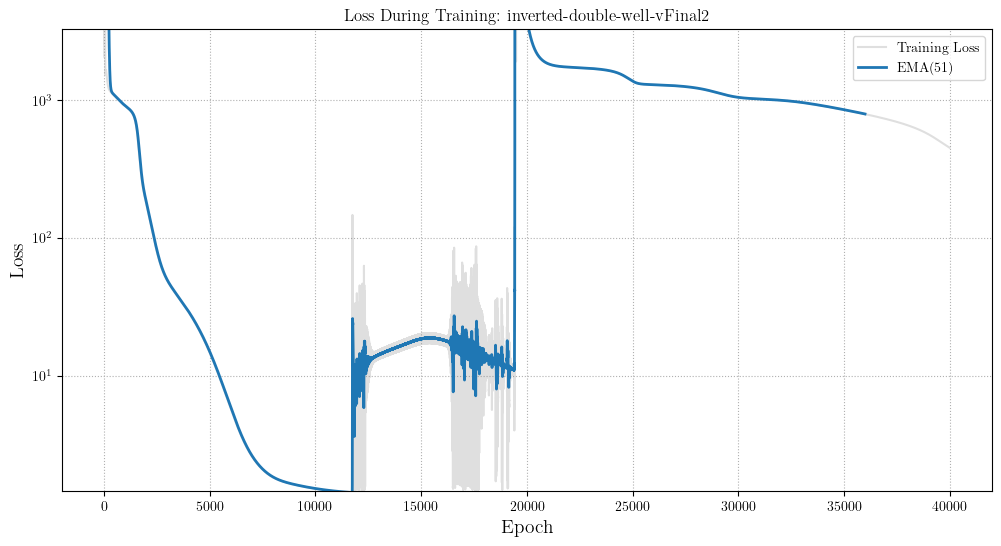

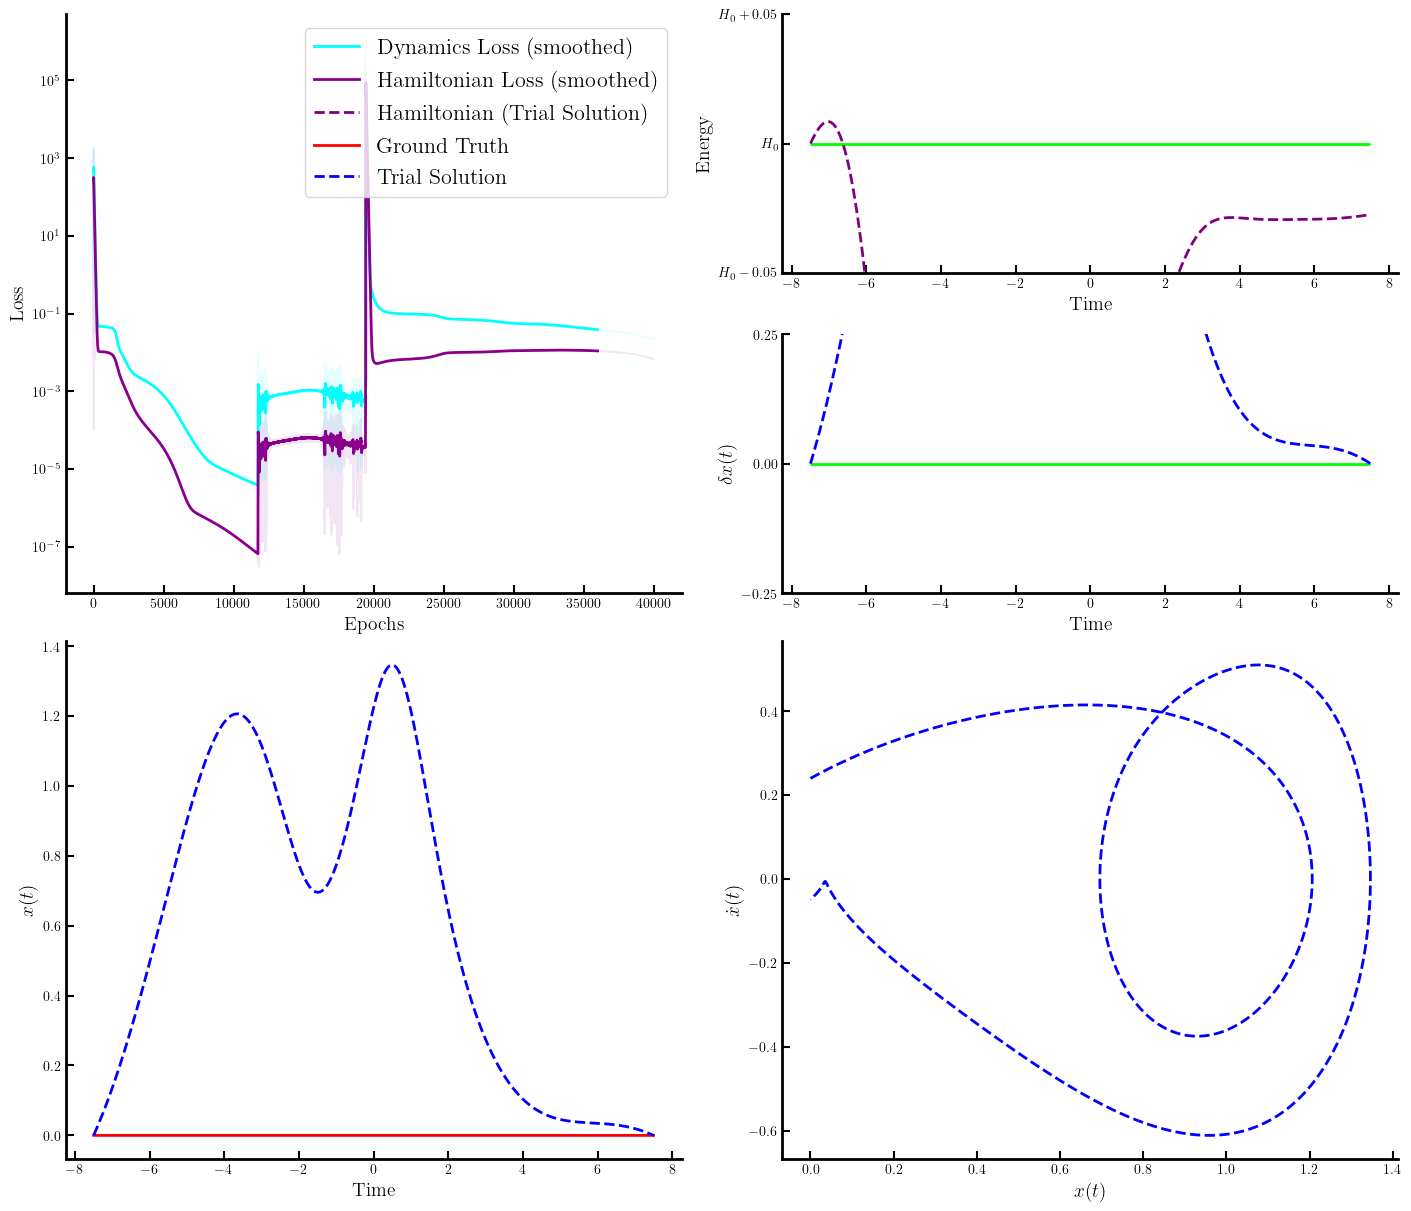

  0%|                                       | 1/40000 [00:00<1:56:17,  5.73it/s]

12460812.268293843


  0%|                                     | 101/40000 [00:14<1:32:59,  7.15it/s]

3576.290290497263


  1%|▏                                    | 201/40000 [00:28<1:31:31,  7.25it/s]

2868.941564926481


  1%|▎                                    | 301/40000 [00:42<1:33:49,  7.05it/s]

2379.0855384074757


  1%|▎                                    | 401/40000 [00:56<1:35:48,  6.89it/s]

1351.6861015809563


  1%|▍                                    | 501/40000 [01:11<1:35:02,  6.93it/s]

1322.1253686181904


  2%|▌                                    | 601/40000 [01:25<1:39:48,  6.58it/s]

1300.0761734702091


  2%|▋                                    | 701/40000 [01:40<1:37:21,  6.73it/s]

1282.1334854284423


  2%|▋                                    | 801/40000 [01:54<1:31:52,  7.11it/s]

1267.8290218072323


  2%|▊                                    | 901/40000 [02:09<1:33:32,  6.97it/s]

1256.525409685494


  3%|▉                                   | 1001/40000 [02:24<1:35:23,  6.81it/s]

1247.5599898985463


  3%|▉                                   | 1101/40000 [02:38<1:35:53,  6.76it/s]

1240.3231347574922


  3%|█                                   | 1201/40000 [02:53<1:35:15,  6.79it/s]

1234.288273933022


  3%|█▏                                  | 1301/40000 [03:08<1:35:39,  6.74it/s]

1229.0134348752604


  4%|█▎                                  | 1401/40000 [03:23<1:39:32,  6.46it/s]

1224.128051324537


  4%|█▎                                  | 1501/40000 [03:38<1:33:45,  6.84it/s]

1219.3132458714351


  4%|█▍                                  | 1601/40000 [03:53<1:34:29,  6.77it/s]

1214.2797295697399


  4%|█▌                                  | 1701/40000 [04:08<1:30:58,  7.02it/s]

1208.7449584413262


  5%|█▌                                  | 1801/40000 [04:23<1:32:24,  6.89it/s]

1202.4100822252235


  5%|█▋                                  | 1901/40000 [04:37<1:32:59,  6.83it/s]

1194.9376238805382


  5%|█▊                                  | 2001/40000 [04:52<1:32:44,  6.83it/s]

1185.9335736426397


  5%|█▉                                  | 2101/40000 [05:07<1:30:55,  6.95it/s]

1174.9446777460923


  6%|█▉                                  | 2201/40000 [05:22<1:31:11,  6.91it/s]

1161.4960176966456


  6%|██                                  | 2301/40000 [05:37<1:31:55,  6.84it/s]

1145.2145812260858


  6%|██▏                                 | 2401/40000 [05:52<1:31:02,  6.88it/s]

1126.0891133229654


  6%|██▎                                 | 2501/40000 [06:07<1:31:47,  6.81it/s]

1104.832481722165


  7%|██▎                                 | 2601/40000 [06:22<1:30:40,  6.87it/s]

1083.064863408687


  7%|██▍                                 | 2701/40000 [06:36<1:32:36,  6.71it/s]

1062.848374394999


  7%|██▌                                 | 2801/40000 [06:51<1:33:17,  6.65it/s]

1045.615546651841


  7%|██▌                                 | 2901/40000 [07:06<1:30:15,  6.85it/s]

1031.4900645209834


  8%|██▋                                 | 3001/40000 [07:21<1:30:13,  6.83it/s]

1019.6831141324709


  8%|██▊                                 | 3101/40000 [07:35<1:27:35,  7.02it/s]

1009.2941825188625


  8%|██▉                                 | 3201/40000 [07:50<1:31:12,  6.72it/s]

999.695449813079


  8%|██▉                                 | 3301/40000 [08:05<1:31:30,  6.68it/s]

990.5050041945324


  9%|███                                 | 3401/40000 [08:22<1:30:56,  6.71it/s]

981.4707884508289


  9%|███▏                                | 3501/40000 [08:36<1:28:16,  6.89it/s]

972.4066200170648


  9%|███▏                                | 3601/40000 [08:51<1:27:40,  6.92it/s]

963.1711280240233


  9%|███▎                                | 3701/40000 [09:05<1:30:03,  6.72it/s]

953.6591264524056


 10%|███▍                                | 3801/40000 [09:20<1:27:06,  6.93it/s]

943.79317422348


 10%|███▌                                | 3901/40000 [09:34<1:29:11,  6.75it/s]

933.514577400684


 10%|███▌                                | 4001/40000 [09:49<1:33:43,  6.40it/s]

922.7755464289722


 10%|███▋                                | 4101/40000 [10:04<1:37:50,  6.12it/s]

911.5334907674827


 11%|███▊                                | 4201/40000 [10:18<1:25:55,  6.94it/s]

899.7474960282256


 11%|███▊                                | 4301/40000 [10:32<1:23:54,  7.09it/s]

887.376586337639


 11%|███▉                                | 4401/40000 [10:47<1:24:34,  7.02it/s]

874.3793814176375


 11%|████                                | 4501/40000 [11:01<1:31:12,  6.49it/s]

860.7150875972262


 12%|████▏                               | 4601/40000 [11:16<1:24:12,  7.01it/s]

846.3464282546369


 12%|████▏                               | 4701/40000 [11:31<1:24:07,  6.99it/s]

831.2463497460723


 12%|████▎                               | 4801/40000 [11:45<1:25:10,  6.89it/s]

815.4125417319002


 12%|████▍                               | 4901/40000 [12:00<1:24:24,  6.93it/s]

798.8971387042703


 13%|████▌                               | 5001/40000 [12:15<1:24:05,  6.94it/s]

781.861427160664


 13%|████▌                               | 5101/40000 [12:29<1:24:22,  6.89it/s]

764.6576300208352


 13%|████▋                               | 5201/40000 [12:43<1:25:12,  6.81it/s]

747.8999109927404


 13%|████▊                               | 5301/40000 [12:58<1:22:58,  6.97it/s]

732.4056572907748


 14%|████▊                               | 5401/40000 [13:13<1:27:53,  6.56it/s]

718.8743166587201


 14%|████▉                               | 5501/40000 [13:28<1:41:56,  5.64it/s]

707.4447302584429


 14%|█████                               | 5601/40000 [13:43<1:31:06,  6.29it/s]

697.6098429750484


 14%|█████▏                              | 5701/40000 [13:58<1:22:54,  6.90it/s]

688.6282072167387


 15%|█████▏                              | 5801/40000 [14:12<1:21:32,  6.99it/s]

679.9377868294897


 15%|█████▎                              | 5901/40000 [14:27<1:25:19,  6.66it/s]

671.2381889826383


 15%|█████▍                              | 6001/40000 [14:41<1:22:39,  6.86it/s]

662.3863361327725


 15%|█████▍                              | 6101/40000 [14:56<1:22:21,  6.86it/s]

653.298492488151


 16%|█████▌                              | 6201/40000 [15:11<1:21:57,  6.87it/s]

643.9032580415261


 16%|█████▋                              | 6301/40000 [15:26<1:23:34,  6.72it/s]

634.1249146062918


 16%|█████▊                              | 6401/40000 [15:40<1:22:15,  6.81it/s]

623.8781278353501


 16%|█████▊                              | 6501/40000 [15:55<1:20:47,  6.91it/s]

613.0662867080937


 17%|█████▉                              | 6601/40000 [16:10<1:19:59,  6.96it/s]

601.5815923836794


 17%|██████                              | 6701/40000 [16:25<1:20:22,  6.90it/s]

589.3071064437161


 17%|██████                              | 6801/40000 [16:40<1:20:54,  6.84it/s]

576.1218020326961


 17%|██████▏                             | 6901/40000 [16:55<1:20:35,  6.85it/s]

561.9102243427626


 18%|██████▎                             | 7001/40000 [17:10<1:18:42,  6.99it/s]

546.5788954435573


 18%|██████▍                             | 7101/40000 [17:24<1:20:44,  6.79it/s]

530.0819876638633


 18%|██████▍                             | 7201/40000 [17:39<1:20:07,  6.82it/s]

512.4584862961649


 18%|██████▌                             | 7301/40000 [17:54<1:18:07,  6.98it/s]

493.88060043617025


 19%|██████▋                             | 7401/40000 [18:08<1:17:10,  7.04it/s]

474.7060133148008


 19%|██████▊                             | 7501/40000 [18:23<1:17:50,  6.96it/s]

455.51282426956044


 19%|██████▊                             | 7601/40000 [18:37<1:18:39,  6.86it/s]

437.07948422626214


 19%|██████▉                             | 7701/40000 [18:52<1:18:54,  6.82it/s]

420.2680535262665


 20%|███████                             | 7801/40000 [19:07<1:18:15,  6.86it/s]

406.1467960340227


 20%|███████                             | 7901/40000 [19:22<1:18:04,  6.85it/s]

395.1052650710589


 20%|███████▏                            | 8001/40000 [19:37<1:17:05,  6.92it/s]

386.4592158266065


 20%|███████▎                            | 8101/40000 [19:51<1:16:35,  6.94it/s]

379.8038062484182


 21%|███████▍                            | 8201/40000 [20:06<1:13:25,  7.22it/s]

374.5743538841722


 21%|███████▍                            | 8301/40000 [20:20<1:13:21,  7.20it/s]

372.15269444750834


 21%|███████▌                            | 8401/40000 [20:33<1:08:40,  7.67it/s]

366.581675537498


 21%|███████▋                            | 8501/40000 [20:46<1:12:35,  7.23it/s]

363.34378392189154


 22%|███████▋                            | 8601/40000 [21:00<1:11:56,  7.27it/s]

360.3902892226837


 22%|███████▊                            | 8701/40000 [21:14<1:14:25,  7.01it/s]

357.73948162176237


 22%|███████▉                            | 8801/40000 [21:28<1:15:07,  6.92it/s]

355.2762311960251


 22%|████████                            | 8901/40000 [21:42<1:18:34,  6.60it/s]

353.01766666724274


 23%|████████                            | 9001/40000 [21:57<1:12:52,  7.09it/s]

350.9127058210947


 23%|████████▏                           | 9101/40000 [22:11<1:12:44,  7.08it/s]

348.9418250016276


 23%|████████▎                           | 9201/40000 [22:25<1:13:23,  6.99it/s]

347.12159259183113


 23%|████████▎                           | 9301/40000 [22:40<1:14:31,  6.86it/s]

346.09526120646416


 24%|████████▍                           | 9401/40000 [22:54<1:13:09,  6.97it/s]

343.75254970339313


 24%|████████▌                           | 9501/40000 [23:10<1:13:38,  6.90it/s]

342.2270658217258


 24%|████████▋                           | 9601/40000 [23:24<1:12:37,  6.98it/s]

341.1166255959485


 24%|████████▋                           | 9701/40000 [23:39<1:16:46,  6.58it/s]

340.28807234297096


 25%|████████▊                           | 9801/40000 [23:54<1:14:19,  6.77it/s]

338.0093553452973


 25%|████████▉                           | 9901/40000 [24:09<1:14:02,  6.78it/s]

336.7536028814238


 25%|████████▊                          | 10001/40000 [24:23<1:12:31,  6.89it/s]

339.1290940603211


 25%|████████▊                          | 10101/40000 [24:38<1:10:50,  7.03it/s]

334.2950034594125


 26%|████████▉                          | 10201/40000 [24:53<1:09:48,  7.11it/s]

333.41265152476905


 26%|█████████                          | 10301/40000 [25:07<1:10:39,  7.00it/s]

332.57265422430004


 26%|█████████                          | 10401/40000 [25:23<1:13:48,  6.68it/s]

336.8427693969543


 26%|█████████▏                         | 10501/40000 [25:37<1:12:57,  6.74it/s]

338.0242354907982


 27%|█████████▎                         | 10601/40000 [25:53<1:10:43,  6.93it/s]

331.1795492900252


 27%|█████████▎                         | 10701/40000 [26:07<1:12:11,  6.76it/s]

328.0479251573971


 27%|█████████▍                         | 10801/40000 [26:22<1:12:33,  6.71it/s]

329.5117417825367


 27%|█████████▌                         | 10901/40000 [26:37<1:11:17,  6.80it/s]

327.5837408063266


 28%|█████████▋                         | 11001/40000 [26:52<1:11:35,  6.75it/s]

326.7125505542122


 28%|█████████▋                         | 11101/40000 [27:07<1:10:35,  6.82it/s]

326.6769716753999


 28%|█████████▊                         | 11201/40000 [27:21<1:08:46,  6.98it/s]

324.84744007221315


 28%|█████████▉                         | 11301/40000 [27:37<1:12:53,  6.56it/s]

333.42011124473686


 29%|█████████▉                         | 11401/40000 [27:52<1:11:45,  6.64it/s]

348.8759720648766


 29%|██████████                         | 11501/40000 [28:07<1:12:00,  6.60it/s]

334.4406987335648


 29%|██████████▏                        | 11601/40000 [28:22<1:09:57,  6.77it/s]

320.8180689352379


 29%|██████████▏                        | 11701/40000 [28:38<1:07:46,  6.96it/s]

322.6018298050513


 30%|██████████▎                        | 11801/40000 [28:53<1:11:09,  6.60it/s]

321.05399138362975


 30%|██████████▍                        | 11901/40000 [29:08<1:06:55,  7.00it/s]

320.8266651457407


 30%|██████████▌                        | 12001/40000 [29:23<1:07:24,  6.92it/s]

322.92741061027806


 30%|██████████▌                        | 12101/40000 [29:37<1:08:16,  6.81it/s]

320.41876186880995


 31%|██████████▋                        | 12201/40000 [29:52<1:07:07,  6.90it/s]

317.52197697095954


 31%|██████████▊                        | 12301/40000 [30:07<1:08:38,  6.73it/s]

338.30635900822256


 31%|██████████▊                        | 12401/40000 [30:21<1:06:57,  6.87it/s]

325.6268606076275


 31%|██████████▉                        | 12501/40000 [30:36<1:07:07,  6.83it/s]

315.4096606974266


 32%|███████████                        | 12601/40000 [30:51<1:06:42,  6.85it/s]

319.6495448315252


 32%|███████████                        | 12701/40000 [31:06<1:08:19,  6.66it/s]

335.18862028767353


 32%|███████████▏                       | 12801/40000 [31:20<1:06:09,  6.85it/s]

311.72732861879166


 32%|███████████▎                       | 12901/40000 [31:35<1:06:16,  6.81it/s]

324.73918338347653


 33%|███████████▍                       | 13001/40000 [31:50<1:10:30,  6.38it/s]

326.0825509788727


 33%|███████████▍                       | 13101/40000 [32:05<1:10:35,  6.35it/s]

313.0045182376289


 33%|███████████▌                       | 13201/40000 [32:19<1:05:43,  6.80it/s]

346.19914613215127


 33%|███████████▋                       | 13301/40000 [32:34<1:04:24,  6.91it/s]

311.06362919772647


 34%|███████████▋                       | 13401/40000 [32:49<1:21:06,  5.47it/s]

318.62084194016455


 34%|███████████▊                       | 13501/40000 [33:03<1:04:55,  6.80it/s]

319.9697523409634


 34%|███████████▉                       | 13601/40000 [33:18<1:05:24,  6.73it/s]

307.3578336558042


 34%|███████████▉                       | 13701/40000 [33:33<1:12:41,  6.03it/s]

316.2751887270983


 35%|████████████                       | 13801/40000 [33:49<1:14:38,  5.85it/s]

311.29755121718233


 35%|████████████▏                      | 13901/40000 [34:04<1:17:28,  5.61it/s]

329.2905684084854


 35%|████████████▎                      | 14001/40000 [34:19<1:04:30,  6.72it/s]

322.9138476217743


 35%|████████████▎                      | 14101/40000 [34:33<1:03:23,  6.81it/s]

317.6850394324575


 36%|████████████▍                      | 14201/40000 [34:48<1:18:09,  5.50it/s]

319.83346088114615


 36%|████████████▌                      | 14301/40000 [35:03<1:05:41,  6.52it/s]

315.908495269332


 36%|████████████▌                      | 14401/40000 [35:18<1:00:57,  7.00it/s]

307.2714144245334


 36%|████████████▋                      | 14501/40000 [35:33<1:02:29,  6.80it/s]

359.4645233368795


 37%|████████████▊                      | 14601/40000 [35:49<1:19:04,  5.35it/s]

306.900122933435


 37%|████████████▊                      | 14701/40000 [36:03<1:04:22,  6.55it/s]

314.2580123632568


 37%|████████████▉                      | 14801/40000 [36:18<1:02:44,  6.69it/s]

317.6290400955758


 37%|█████████████                      | 14901/40000 [36:33<1:01:03,  6.85it/s]

300.79702652509394


 38%|█████████████▏                     | 15001/40000 [36:48<1:00:32,  6.88it/s]

303.57408785067344


 38%|█████████████▏                     | 15101/40000 [37:03<1:01:14,  6.78it/s]

331.24523550188144


 38%|█████████████▎                     | 15201/40000 [37:18<1:00:20,  6.85it/s]

314.45856566952926


 38%|█████████████▍                     | 15301/40000 [37:32<1:01:21,  6.71it/s]

309.0756395021627


 39%|█████████████▍                     | 15401/40000 [37:48<1:01:44,  6.64it/s]

303.836198503349


 39%|█████████████▌                     | 15501/40000 [38:03<1:02:07,  6.57it/s]

321.2871976228739


 39%|█████████████▋                     | 15601/40000 [38:18<1:02:06,  6.55it/s]

298.21885307435565


 39%|██████████████▌                      | 15701/40000 [38:33<58:48,  6.89it/s]

299.7343832145632


 40%|██████████████▌                      | 15801/40000 [38:48<59:57,  6.73it/s]

300.77462503975966


 40%|██████████████▋                      | 15901/40000 [39:03<59:48,  6.72it/s]

310.1976194791591


 40%|██████████████                     | 16001/40000 [39:18<1:00:20,  6.63it/s]

299.78051106200763


 40%|██████████████                     | 16101/40000 [39:33<1:00:43,  6.56it/s]

308.6561870338507


 41%|██████████████▉                      | 16201/40000 [39:48<57:22,  6.91it/s]

300.04133497034223


 41%|███████████████                      | 16301/40000 [40:05<57:25,  6.88it/s]

299.9249476860762


 41%|███████████████▏                     | 16401/40000 [40:20<56:42,  6.94it/s]

294.90899493558817


 41%|███████████████▎                     | 16501/40000 [40:34<55:52,  7.01it/s]

297.54210103375243


 42%|██████████████▌                    | 16601/40000 [40:49<1:05:43,  5.93it/s]

302.957558032505


 42%|███████████████▍                     | 16701/40000 [41:03<56:13,  6.91it/s]

301.23689862580073


 42%|███████████████▌                     | 16801/40000 [41:18<58:31,  6.61it/s]

309.0334210543619


 42%|███████████████▋                     | 16901/40000 [41:33<55:44,  6.91it/s]

300.1747086196858


 43%|███████████████▋                     | 17001/40000 [41:48<54:57,  6.97it/s]

328.6347465652417


 43%|███████████████▊                     | 17101/40000 [42:02<55:44,  6.85it/s]

315.96114051142195


 43%|███████████████▉                     | 17201/40000 [42:17<55:24,  6.86it/s]

307.20357487020203


 43%|████████████████                     | 17301/40000 [42:32<56:38,  6.68it/s]

307.95584388299557


 44%|████████████████                     | 17401/40000 [42:47<55:48,  6.75it/s]

312.7955627339553


 44%|████████████████▏                    | 17501/40000 [43:02<55:24,  6.77it/s]

310.6446638100816


 44%|████████████████▎                    | 17601/40000 [43:17<54:04,  6.90it/s]

305.83073483368065


 44%|████████████████▎                    | 17701/40000 [43:32<54:03,  6.87it/s]

306.0239739684299


 45%|████████████████▍                    | 17801/40000 [43:47<53:05,  6.97it/s]

287.9177344341655


 45%|████████████████▌                    | 17901/40000 [44:02<54:11,  6.80it/s]

306.13261891937066


 45%|████████████████▋                    | 18001/40000 [44:17<53:20,  6.87it/s]

313.9113529173808


 45%|████████████████▋                    | 18101/40000 [44:31<54:55,  6.64it/s]

286.01818903993745


 46%|████████████████▊                    | 18201/40000 [44:46<54:20,  6.68it/s]

287.16091331435797


 46%|████████████████▉                    | 18301/40000 [45:01<55:25,  6.52it/s]

305.44216737510476


 46%|█████████████████                    | 18401/40000 [45:16<52:05,  6.91it/s]

298.63488251457073


 46%|█████████████████                    | 18501/40000 [45:31<53:49,  6.66it/s]

295.2492906741105


 47%|█████████████████▏                   | 18601/40000 [45:46<51:12,  6.96it/s]

285.96437368869135


 47%|█████████████████▎                   | 18701/40000 [46:01<53:54,  6.58it/s]

290.40383944546113


 47%|█████████████████▍                   | 18801/40000 [46:16<51:20,  6.88it/s]

291.1889238371455


 47%|█████████████████▍                   | 18901/40000 [46:31<52:52,  6.65it/s]

348.0178007357891


 48%|█████████████████▌                   | 19001/40000 [46:46<50:52,  6.88it/s]

316.5396238156444


 48%|█████████████████▋                   | 19101/40000 [47:01<52:43,  6.61it/s]

285.5934230621838


 48%|█████████████████▊                   | 19201/40000 [47:16<50:32,  6.86it/s]

303.15230423398873


 48%|█████████████████▊                   | 19301/40000 [47:30<50:11,  6.87it/s]

289.37285097671577


 49%|█████████████████▉                   | 19401/40000 [47:46<50:05,  6.85it/s]

289.1229253166912


 49%|██████████████████                   | 19501/40000 [48:01<52:22,  6.52it/s]

294.76945256245665


 49%|██████████████████▏                  | 19601/40000 [48:16<50:43,  6.70it/s]

300.4335783082595


 49%|██████████████████▏                  | 19701/40000 [48:31<49:17,  6.86it/s]

292.5990335044482


 50%|██████████████████▎                  | 19801/40000 [48:46<49:39,  6.78it/s]

287.82605569689224


 50%|██████████████████▍                  | 19901/40000 [49:01<51:19,  6.53it/s]

301.7667939513799


 50%|██████████████████▌                  | 20001/40000 [49:16<48:14,  6.91it/s]

319.98446942287865


 50%|██████████████████▌                  | 20101/40000 [49:31<49:40,  6.68it/s]

302.40120475715804


 51%|██████████████████▋                  | 20201/40000 [49:46<47:25,  6.96it/s]

278.94441179565086


 51%|██████████████████▊                  | 20301/40000 [50:01<50:20,  6.52it/s]

294.66183969047773


 51%|██████████████████▊                  | 20401/40000 [50:17<47:17,  6.91it/s]

279.34122845389203


 51%|██████████████████▉                  | 20501/40000 [50:32<49:21,  6.58it/s]

284.177412675556


 52%|███████████████████                  | 20601/40000 [50:46<48:57,  6.60it/s]

279.35060167365793


 52%|███████████████████▏                 | 20701/40000 [51:02<52:06,  6.17it/s]

283.8737329733295


 52%|███████████████████▏                 | 20801/40000 [51:19<46:48,  6.84it/s]

285.7955586674439


 52%|███████████████████▎                 | 20901/40000 [51:33<46:42,  6.81it/s]

292.1979986002589


 53%|███████████████████▍                 | 21001/40000 [51:48<45:34,  6.95it/s]

319.6517227330396


 53%|███████████████████▌                 | 21101/40000 [52:03<46:39,  6.75it/s]

277.8466888191263


 53%|███████████████████▌                 | 21201/40000 [52:18<44:54,  6.98it/s]

276.9856465459612


 53%|███████████████████▋                 | 21301/40000 [52:32<47:17,  6.59it/s]

287.4471253765761


 54%|███████████████████▊                 | 21401/40000 [52:47<44:19,  6.99it/s]

299.03680449379516


 54%|███████████████████▉                 | 21501/40000 [53:02<47:12,  6.53it/s]

296.0494608760703


 54%|███████████████████▉                 | 21601/40000 [53:17<44:08,  6.95it/s]

285.08756915525913


 54%|████████████████████                 | 21701/40000 [53:32<45:34,  6.69it/s]

348.7531495399739


 55%|████████████████████▏                | 21801/40000 [53:47<43:57,  6.90it/s]

270.86420653142886


 55%|████████████████████▎                | 21901/40000 [54:02<44:44,  6.74it/s]

284.41682762866344


 55%|████████████████████▎                | 22001/40000 [54:17<45:15,  6.63it/s]

282.3775430307156


 55%|████████████████████▍                | 22101/40000 [54:31<44:44,  6.67it/s]

289.24569220873985


 56%|████████████████████▌                | 22201/40000 [54:46<44:06,  6.73it/s]

271.27717416713733


 56%|████████████████████▋                | 22301/40000 [55:01<45:19,  6.51it/s]

308.88880103641145


 56%|████████████████████▋                | 22401/40000 [55:17<45:17,  6.48it/s]

279.33048608805706


 56%|████████████████████▊                | 22501/40000 [55:32<43:23,  6.72it/s]

278.2487012622704


 57%|████████████████████▉                | 22601/40000 [55:47<42:29,  6.82it/s]

290.5911012141047


 57%|████████████████████▉                | 22701/40000 [56:02<42:46,  6.74it/s]

266.98261270931005


 57%|█████████████████████                | 22801/40000 [56:17<42:17,  6.78it/s]

280.90880845355247


 57%|█████████████████████▏               | 22901/40000 [56:32<42:43,  6.67it/s]

267.9894576976243


 58%|█████████████████████▎               | 23001/40000 [56:46<42:28,  6.67it/s]

275.93723198978427


 58%|█████████████████████▎               | 23101/40000 [57:02<42:57,  6.56it/s]

268.460719454705


 58%|█████████████████████▍               | 23201/40000 [57:17<41:49,  6.69it/s]

272.46972811643604


 58%|█████████████████████▌               | 23301/40000 [57:32<43:57,  6.33it/s]

283.4230904668888


 59%|█████████████████████▋               | 23401/40000 [57:47<41:57,  6.59it/s]

294.946693044074


 59%|█████████████████████▋               | 23501/40000 [58:02<41:33,  6.62it/s]

287.4461409270199


 59%|█████████████████████▊               | 23601/40000 [58:17<40:34,  6.74it/s]

315.02742824535414


 59%|█████████████████████▉               | 23701/40000 [58:32<40:44,  6.67it/s]

266.6392695892252


 60%|██████████████████████               | 23801/40000 [58:47<40:01,  6.75it/s]

303.82261162186995


 60%|██████████████████████               | 23901/40000 [59:03<41:51,  6.41it/s]

289.2289244575746


 60%|██████████████████████▏              | 24001/40000 [59:18<40:12,  6.63it/s]

321.40572292819985


 60%|██████████████████████▎              | 24101/40000 [59:33<40:58,  6.47it/s]

266.78497024980595


 61%|██████████████████████▍              | 24201/40000 [59:48<38:56,  6.76it/s]

302.9902036279268


 61%|█████████████████████▎             | 24301/40000 [1:00:03<38:26,  6.81it/s]

292.7967588813884


 61%|█████████████████████▎             | 24401/40000 [1:00:18<38:09,  6.81it/s]

281.6721659064024


 61%|█████████████████████▍             | 24501/40000 [1:00:33<39:57,  6.46it/s]

259.8993208199379


 62%|█████████████████████▌             | 24601/40000 [1:00:48<37:10,  6.90it/s]

310.57031233258107


 62%|█████████████████████▌             | 24701/40000 [1:01:03<37:58,  6.71it/s]

284.8992189749652


 62%|█████████████████████▋             | 24801/40000 [1:01:18<37:26,  6.76it/s]

264.28767129938564


 62%|█████████████████████▊             | 24901/40000 [1:01:33<37:00,  6.80it/s]

260.2070385050398


 63%|█████████████████████▉             | 25001/40000 [1:01:48<37:03,  6.74it/s]

281.14838282043365


 63%|█████████████████████▉             | 25101/40000 [1:02:03<37:55,  6.55it/s]

262.3633113755966


 63%|██████████████████████             | 25201/40000 [1:02:20<35:23,  6.97it/s]

260.06056332837863


 63%|██████████████████████▏            | 25301/40000 [1:02:34<34:58,  7.01it/s]

290.19192819254494


 64%|██████████████████████▏            | 25401/40000 [1:02:49<47:49,  5.09it/s]

307.1206941018777


 64%|██████████████████████▎            | 25501/40000 [1:03:04<38:54,  6.21it/s]

278.594113224387


 64%|██████████████████████▍            | 25601/40000 [1:03:18<35:57,  6.67it/s]

286.7611775139525


 64%|██████████████████████▍            | 25701/40000 [1:03:33<34:52,  6.83it/s]

258.42567788181975


 65%|██████████████████████▌            | 25801/40000 [1:03:48<38:51,  6.09it/s]

266.9347689515005


 65%|██████████████████████▋            | 25901/40000 [1:04:03<34:42,  6.77it/s]

271.81224566258555


 65%|██████████████████████▊            | 26001/40000 [1:04:18<33:42,  6.92it/s]

260.02482433696565


 65%|██████████████████████▊            | 26101/40000 [1:04:33<35:01,  6.62it/s]

304.18027311235556


 66%|██████████████████████▉            | 26201/40000 [1:04:47<34:07,  6.74it/s]

255.8495455316375


 66%|███████████████████████            | 26301/40000 [1:05:02<33:32,  6.81it/s]

271.892785289201


 66%|███████████████████████            | 26401/40000 [1:05:19<41:29,  5.46it/s]

277.50810855362016


 66%|███████████████████████▏           | 26501/40000 [1:05:35<34:53,  6.45it/s]

266.5177934886714


 67%|███████████████████████▎           | 26601/40000 [1:05:50<38:03,  5.87it/s]

258.8735538065795


 67%|███████████████████████▎           | 26701/40000 [1:06:05<32:55,  6.73it/s]

252.43420769734144


 67%|███████████████████████▍           | 26801/40000 [1:06:20<32:13,  6.83it/s]

270.93117740676485


 67%|███████████████████████▌           | 26901/40000 [1:06:34<32:05,  6.80it/s]

280.06234872812604


 68%|███████████████████████▋           | 27001/40000 [1:06:49<35:25,  6.12it/s]

271.5528742228543


 68%|███████████████████████▋           | 27101/40000 [1:07:03<30:48,  6.98it/s]

255.82466585332418


 68%|███████████████████████▊           | 27201/40000 [1:07:18<31:07,  6.85it/s]

279.3205982547175


 68%|███████████████████████▉           | 27301/40000 [1:07:32<30:44,  6.88it/s]

285.32866712360385


 69%|███████████████████████▉           | 27401/40000 [1:07:47<30:40,  6.85it/s]

280.8020818725915


 69%|████████████████████████           | 27501/40000 [1:08:02<29:54,  6.97it/s]

250.71936388936356


 69%|████████████████████████▏          | 27601/40000 [1:08:17<29:57,  6.90it/s]

330.35291282723756


 69%|████████████████████████▏          | 27701/40000 [1:08:31<30:07,  6.81it/s]

264.1572694630358


 70%|████████████████████████▎          | 27801/40000 [1:08:46<28:44,  7.07it/s]

322.387934535852


 70%|████████████████████████▍          | 27901/40000 [1:09:01<29:12,  6.90it/s]

253.31252679021023


 70%|████████████████████████▌          | 28001/40000 [1:09:15<29:13,  6.84it/s]

262.76795498710896


 70%|████████████████████████▌          | 28101/40000 [1:09:30<29:51,  6.64it/s]

250.47933995992307


 71%|████████████████████████▋          | 28201/40000 [1:09:45<28:36,  6.87it/s]

277.72375941972416


 71%|████████████████████████▊          | 28301/40000 [1:10:00<28:46,  6.77it/s]

252.44711291430644


 71%|████████████████████████▊          | 28401/40000 [1:10:15<28:20,  6.82it/s]

257.09707738560314


 71%|████████████████████████▉          | 28501/40000 [1:10:30<27:53,  6.87it/s]

305.8128752985758


 72%|█████████████████████████          | 28601/40000 [1:10:45<27:38,  6.87it/s]

257.42198873085107


 72%|█████████████████████████          | 28701/40000 [1:11:00<27:19,  6.89it/s]

285.07609251897156


 72%|█████████████████████████▏         | 28801/40000 [1:11:14<27:10,  6.87it/s]

289.82431001375477


 72%|█████████████████████████▎         | 28901/40000 [1:11:29<27:07,  6.82it/s]

262.79903674127536


 73%|█████████████████████████▍         | 29001/40000 [1:11:44<28:51,  6.35it/s]

244.3942859336053


 73%|█████████████████████████▍         | 29101/40000 [1:11:59<27:24,  6.63it/s]

272.6275464772286


 73%|█████████████████████████▌         | 29201/40000 [1:12:14<26:23,  6.82it/s]

257.86244523636196


 73%|█████████████████████████▋         | 29301/40000 [1:12:29<25:48,  6.91it/s]

242.8565622465831


 74%|█████████████████████████▋         | 29401/40000 [1:12:45<25:45,  6.86it/s]

278.481306140094


 74%|█████████████████████████▊         | 29501/40000 [1:13:00<25:11,  6.95it/s]

247.21739465720083


 74%|█████████████████████████▉         | 29601/40000 [1:13:14<24:53,  6.96it/s]

252.1936982493913


 74%|█████████████████████████▉         | 29701/40000 [1:13:29<25:30,  6.73it/s]

283.39814845381215


 75%|██████████████████████████         | 29801/40000 [1:13:44<27:17,  6.23it/s]

257.55245854737655


 75%|██████████████████████████▏        | 29901/40000 [1:13:59<24:10,  6.96it/s]

260.3904003572818


 75%|██████████████████████████▎        | 30001/40000 [1:14:14<23:39,  7.04it/s]

241.72547113610662


 75%|██████████████████████████▎        | 30101/40000 [1:14:28<23:56,  6.89it/s]

294.14955415445536


 76%|██████████████████████████▍        | 30201/40000 [1:14:43<23:49,  6.85it/s]

245.51971349831922


 76%|██████████████████████████▌        | 30301/40000 [1:14:58<23:47,  6.79it/s]

242.7895745818556


 76%|██████████████████████████▌        | 30401/40000 [1:15:12<23:37,  6.77it/s]

258.940763448776


 76%|██████████████████████████▋        | 30501/40000 [1:15:27<22:48,  6.94it/s]

290.48670551086724


 77%|██████████████████████████▊        | 30601/40000 [1:15:42<23:18,  6.72it/s]

261.4529272452731


 77%|██████████████████████████▊        | 30701/40000 [1:15:57<21:31,  7.20it/s]

247.15955949428988


 77%|██████████████████████████▉        | 30801/40000 [1:16:12<22:41,  6.76it/s]

284.8002527529954


 77%|███████████████████████████        | 30901/40000 [1:16:26<22:13,  6.83it/s]

249.11322731623835


 78%|███████████████████████████▏       | 31001/40000 [1:16:41<21:14,  7.06it/s]

256.6367881432702


 78%|███████████████████████████▏       | 31101/40000 [1:16:55<20:58,  7.07it/s]

248.64259547691202


 78%|███████████████████████████▎       | 31201/40000 [1:17:10<21:13,  6.91it/s]

248.157341938435


 78%|███████████████████████████▍       | 31301/40000 [1:17:25<22:10,  6.54it/s]

256.2944411940168


 79%|███████████████████████████▍       | 31401/40000 [1:17:39<21:35,  6.64it/s]

237.2569203543428


 79%|███████████████████████████▌       | 31501/40000 [1:17:54<20:07,  7.04it/s]

272.06922381235063


 79%|███████████████████████████▋       | 31601/40000 [1:18:09<20:05,  6.97it/s]

238.80235113498037


 79%|███████████████████████████▋       | 31701/40000 [1:18:23<20:19,  6.81it/s]

254.53448801137674


 80%|███████████████████████████▊       | 31801/40000 [1:18:38<19:55,  6.86it/s]

252.59399200971433


 80%|███████████████████████████▉       | 31901/40000 [1:18:53<19:35,  6.89it/s]

259.71290095959387


 80%|████████████████████████████       | 32001/40000 [1:19:08<19:11,  6.95it/s]

257.03091959000807


 80%|████████████████████████████       | 32101/40000 [1:19:23<19:25,  6.78it/s]

258.5647671060151


 81%|████████████████████████████▏      | 32201/40000 [1:19:38<19:11,  6.77it/s]

291.39843541860495


 81%|████████████████████████████▎      | 32301/40000 [1:19:53<18:41,  6.87it/s]

236.94902318267162


 81%|████████████████████████████▎      | 32401/40000 [1:20:08<18:29,  6.85it/s]

290.6938508555591


 81%|████████████████████████████▍      | 32501/40000 [1:20:23<18:03,  6.92it/s]

233.09986955590432


 82%|████████████████████████████▌      | 32601/40000 [1:20:38<18:02,  6.84it/s]

235.1351056337384


 82%|████████████████████████████▌      | 32701/40000 [1:20:54<17:50,  6.82it/s]

238.20216494768624


 82%|████████████████████████████▋      | 32801/40000 [1:21:09<17:16,  6.94it/s]

255.1275568010863


 82%|████████████████████████████▊      | 32901/40000 [1:21:23<17:06,  6.92it/s]

234.8957989429212


 83%|████████████████████████████▉      | 33001/40000 [1:21:37<16:46,  6.95it/s]

234.50874079092267


 83%|████████████████████████████▉      | 33101/40000 [1:21:52<16:46,  6.85it/s]

237.83132285358602


 83%|█████████████████████████████      | 33201/40000 [1:22:07<16:51,  6.72it/s]

254.26986117898815


 83%|█████████████████████████████▏     | 33301/40000 [1:22:22<16:42,  6.68it/s]

231.64147544544488


 84%|█████████████████████████████▏     | 33401/40000 [1:22:37<16:08,  6.81it/s]

246.31127775655722


 84%|█████████████████████████████▎     | 33501/40000 [1:22:52<16:11,  6.69it/s]

269.92322977285477


 84%|█████████████████████████████▍     | 33601/40000 [1:23:06<15:42,  6.79it/s]

255.13708731853563


 84%|█████████████████████████████▍     | 33701/40000 [1:23:21<18:27,  5.69it/s]

259.590619574449


 85%|█████████████████████████████▌     | 33801/40000 [1:23:36<15:14,  6.78it/s]

247.07680271874767


 85%|█████████████████████████████▋     | 33901/40000 [1:23:51<17:05,  5.95it/s]

230.6491113469758


 85%|█████████████████████████████▊     | 34001/40000 [1:24:06<14:55,  6.70it/s]

275.3620989805538


 85%|█████████████████████████████▊     | 34101/40000 [1:24:20<14:26,  6.81it/s]

263.22403625669705


 86%|█████████████████████████████▉     | 34201/40000 [1:24:35<14:30,  6.66it/s]

297.2575579900835


 86%|██████████████████████████████     | 34301/40000 [1:24:50<14:51,  6.39it/s]

226.02736445192141


 86%|██████████████████████████████     | 34401/40000 [1:25:04<14:28,  6.45it/s]

228.05208280170592


 86%|██████████████████████████████▏    | 34501/40000 [1:25:19<13:03,  7.02it/s]

278.96800306776385


 87%|██████████████████████████████▎    | 34601/40000 [1:25:34<13:02,  6.90it/s]

274.7098464729992


 87%|██████████████████████████████▎    | 34701/40000 [1:25:49<16:07,  5.48it/s]

237.55262490499553


 87%|██████████████████████████████▍    | 34801/40000 [1:26:05<13:36,  6.36it/s]

263.67308398985904


 87%|██████████████████████████████▌    | 34901/40000 [1:26:19<12:13,  6.95it/s]

239.1337628981923


 88%|██████████████████████████████▋    | 35001/40000 [1:26:34<12:15,  6.79it/s]

225.71002411619705


 88%|██████████████████████████████▋    | 35101/40000 [1:26:49<15:27,  5.28it/s]

234.7225044890643


 88%|██████████████████████████████▊    | 35201/40000 [1:27:03<12:22,  6.46it/s]

241.61367478620772


 88%|██████████████████████████████▉    | 35301/40000 [1:27:18<11:35,  6.75it/s]

224.77780270852864


 89%|██████████████████████████████▉    | 35401/40000 [1:27:33<11:22,  6.74it/s]

243.58331491786603


 89%|███████████████████████████████    | 35501/40000 [1:27:48<11:01,  6.80it/s]

238.77741486996774


 89%|███████████████████████████████▏   | 35601/40000 [1:28:03<11:12,  6.54it/s]

264.5698160198779


 89%|███████████████████████████████▏   | 35701/40000 [1:28:18<10:24,  6.88it/s]

251.72026677896199


 90%|███████████████████████████████▎   | 35801/40000 [1:28:33<10:19,  6.77it/s]

225.4211504738372


 90%|███████████████████████████████▍   | 35901/40000 [1:28:48<10:04,  6.78it/s]

249.07837846013908


 90%|███████████████████████████████▌   | 36001/40000 [1:29:03<10:18,  6.46it/s]

231.99665803710664


 90%|███████████████████████████████▌   | 36101/40000 [1:29:18<09:38,  6.74it/s]

261.70415875873806


 91%|███████████████████████████████▋   | 36201/40000 [1:29:32<09:34,  6.61it/s]

231.9614743201916


 91%|███████████████████████████████▊   | 36301/40000 [1:29:49<09:15,  6.66it/s]

221.69175334558713


 91%|███████████████████████████████▊   | 36401/40000 [1:30:04<09:29,  6.31it/s]

260.509963799856


 91%|███████████████████████████████▉   | 36501/40000 [1:30:19<08:29,  6.86it/s]

244.70448415581723


 92%|████████████████████████████████   | 36601/40000 [1:30:34<08:35,  6.59it/s]

238.68411139261696


 92%|████████████████████████████████   | 36701/40000 [1:30:49<09:23,  5.86it/s]

219.35629385044442


 92%|████████████████████████████████▏  | 36801/40000 [1:31:04<08:12,  6.49it/s]

221.0558217318344


 92%|████████████████████████████████▎  | 36901/40000 [1:31:18<07:27,  6.92it/s]

252.79767168422586


 93%|████████████████████████████████▍  | 37001/40000 [1:31:33<07:05,  7.05it/s]

248.26238970572862


 93%|████████████████████████████████▍  | 37101/40000 [1:31:47<07:36,  6.35it/s]

229.04544156699984


 93%|████████████████████████████████▌  | 37201/40000 [1:32:02<06:46,  6.89it/s]

276.5689220502008


 93%|████████████████████████████████▋  | 37301/40000 [1:32:17<06:48,  6.61it/s]

230.18279749826405


 94%|████████████████████████████████▋  | 37401/40000 [1:32:32<06:15,  6.92it/s]

231.02386554968018


 94%|████████████████████████████████▊  | 37501/40000 [1:32:46<06:02,  6.89it/s]

223.5179984443413


 94%|████████████████████████████████▉  | 37601/40000 [1:33:01<05:54,  6.77it/s]

239.34209469024057


 94%|████████████████████████████████▉  | 37701/40000 [1:33:16<05:34,  6.87it/s]

246.72368920389067


 95%|█████████████████████████████████  | 37801/40000 [1:33:31<05:14,  6.98it/s]

254.27301668808204


 95%|█████████████████████████████████▏ | 37901/40000 [1:33:46<05:10,  6.75it/s]

218.76531450072451


 95%|█████████████████████████████████▎ | 38001/40000 [1:34:01<05:11,  6.42it/s]

253.52172272723203


 95%|█████████████████████████████████▎ | 38101/40000 [1:34:16<04:50,  6.54it/s]

255.78696741812888


 96%|█████████████████████████████████▍ | 38201/40000 [1:34:30<04:20,  6.91it/s]

246.27769450079046


 96%|█████████████████████████████████▌ | 38301/40000 [1:34:45<04:10,  6.78it/s]

290.8918507363345


 96%|█████████████████████████████████▌ | 38401/40000 [1:35:00<03:50,  6.92it/s]

247.8252604323466


 96%|█████████████████████████████████▋ | 38501/40000 [1:35:15<03:42,  6.75it/s]

243.45858417487844


 97%|█████████████████████████████████▊ | 38601/40000 [1:35:30<03:27,  6.73it/s]

267.39498094833647


 97%|█████████████████████████████████▊ | 38701/40000 [1:35:45<03:15,  6.65it/s]

235.29801133830404


 97%|█████████████████████████████████▉ | 38801/40000 [1:36:00<02:58,  6.73it/s]

270.1050800038338


 97%|██████████████████████████████████ | 38901/40000 [1:36:15<02:43,  6.74it/s]

227.3933215582507


 98%|██████████████████████████████████▏| 39001/40000 [1:36:30<02:28,  6.75it/s]

295.3262668418162


 98%|██████████████████████████████████▏| 39101/40000 [1:36:45<02:13,  6.75it/s]

267.0664275428427


 98%|██████████████████████████████████▎| 39201/40000 [1:37:00<01:56,  6.87it/s]

218.2569943049481


 98%|██████████████████████████████████▍| 39301/40000 [1:37:15<01:41,  6.88it/s]

280.36823680976283


 99%|██████████████████████████████████▍| 39401/40000 [1:37:30<01:30,  6.63it/s]

256.65610658443126


 99%|██████████████████████████████████▌| 39501/40000 [1:37:45<01:12,  6.85it/s]

212.70106749888683


 99%|██████████████████████████████████▋| 39601/40000 [1:38:02<01:00,  6.64it/s]

260.2565920397145


 99%|██████████████████████████████████▋| 39701/40000 [1:38:17<00:43,  6.85it/s]

333.94949335683634


100%|██████████████████████████████████▊| 39801/40000 [1:38:31<00:29,  6.65it/s]

236.68417144026824


100%|██████████████████████████████████▉| 39901/40000 [1:38:46<00:14,  6.71it/s]

217.58989403268603


100%|███████████████████████████████████| 40000/40000 [1:39:01<00:00,  6.73it/s]
/Users/amcsilva/Desktop/Tese/LastCodeThesis/model.py:244: RuntimeWarning: divide by zero encountered in scalar divide
  l2_error  = float(np.linalg.norm(x_trial - x_ref) / np.linalg.norm(x_ref))


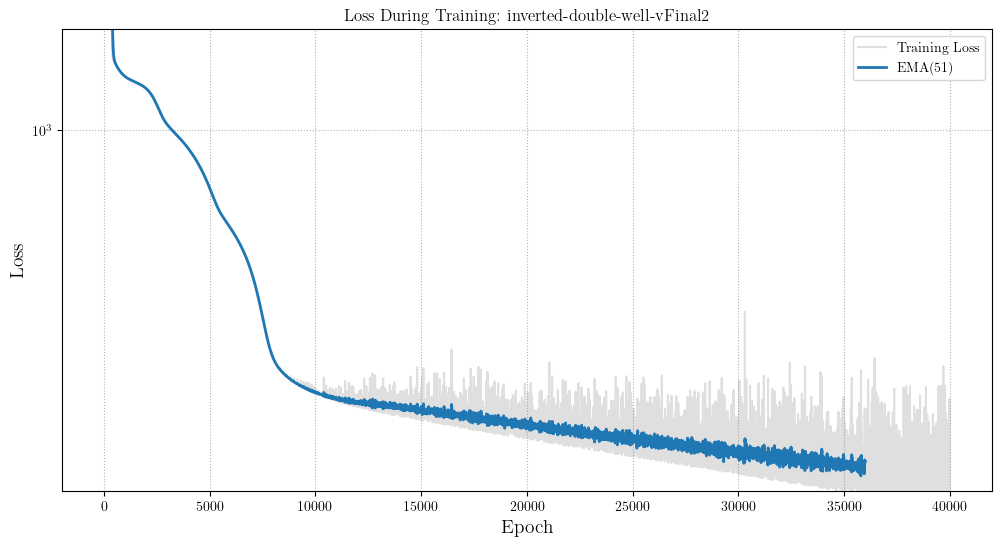

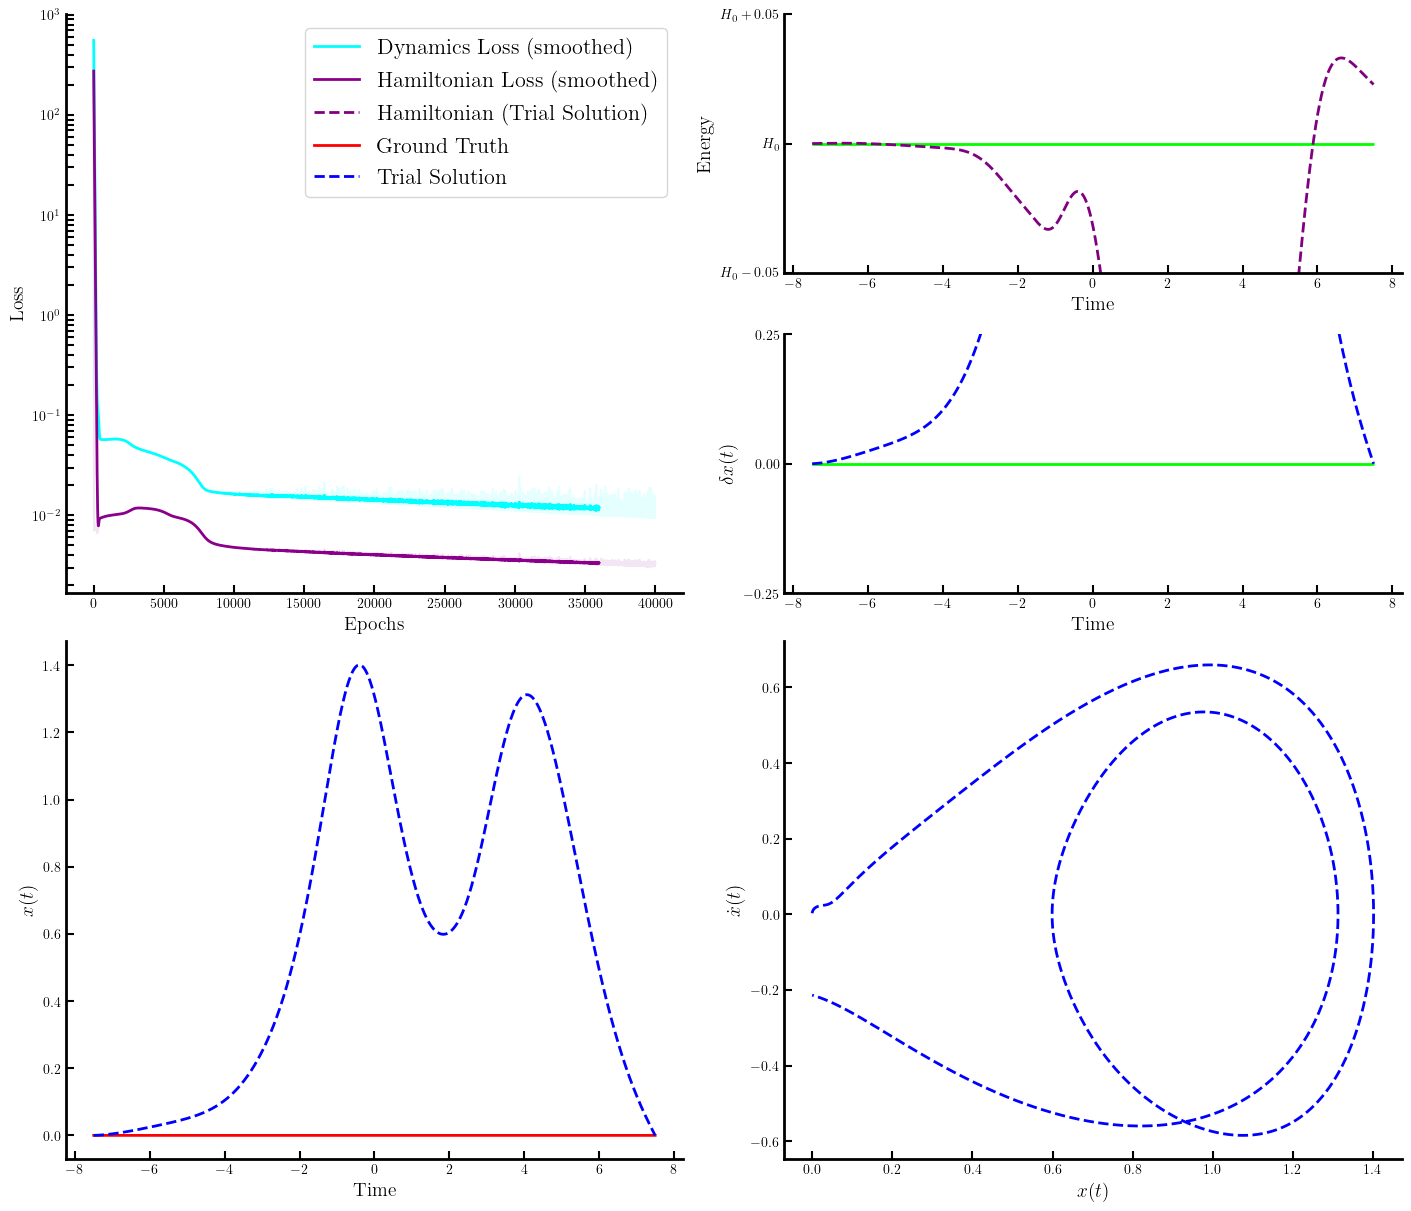

  0%|                                       | 1/40000 [00:00<1:58:41,  5.62it/s]

12460812.268293843


  0%|                                     | 101/40000 [00:14<1:35:27,  6.97it/s]

106103.24063080472


  1%|▏                                    | 201/40000 [00:29<1:35:09,  6.97it/s]

36366.688700447194


  1%|▎                                    | 301/40000 [00:44<1:37:12,  6.81it/s]

20777.715216149933


  1%|▎                                    | 401/40000 [00:59<1:38:38,  6.69it/s]

15232.225465390964


  1%|▍                                    | 501/40000 [01:13<1:34:27,  6.97it/s]

12727.38737974813


  2%|▌                                    | 601/40000 [01:28<1:34:17,  6.96it/s]

11409.568381726145


  2%|▋                                    | 701/40000 [01:42<1:36:19,  6.80it/s]

10634.625061038074


  2%|▋                                    | 801/40000 [01:57<1:35:29,  6.84it/s]

10136.164975671756


  2%|▊                                    | 901/40000 [02:12<1:34:53,  6.87it/s]

9789.693539895052


  3%|▉                                   | 1001/40000 [02:27<1:38:40,  6.59it/s]

9531.456690669378


  3%|▉                                   | 1101/40000 [02:42<1:37:22,  6.66it/s]

9326.367378606154


  3%|█                                   | 1201/40000 [02:57<1:35:19,  6.78it/s]

9153.930441782684


  3%|█▏                                  | 1301/40000 [03:12<1:33:05,  6.93it/s]

9001.536490771592


  4%|█▎                                  | 1401/40000 [03:26<1:33:07,  6.91it/s]

8861.04855263454


  4%|█▎                                  | 1501/40000 [03:41<1:32:55,  6.91it/s]

8726.968902203733


  4%|█▍                                  | 1601/40000 [03:57<1:32:04,  6.95it/s]

8595.410503974557


  4%|█▌                                  | 1701/40000 [04:12<1:30:27,  7.06it/s]

8463.499001829638


  5%|█▌                                  | 1801/40000 [04:26<1:32:10,  6.91it/s]

8329.015128598181


  5%|█▋                                  | 1901/40000 [04:40<1:31:48,  6.92it/s]

8190.176752938312


  5%|█▊                                  | 2001/40000 [04:55<1:30:41,  6.98it/s]

8045.505403753168


  5%|█▉                                  | 2101/40000 [05:09<1:29:23,  7.07it/s]

7893.7463330930295


  6%|█▉                                  | 2201/40000 [05:23<1:29:24,  7.05it/s]

7733.824366743117


  6%|██                                  | 2301/40000 [05:38<1:32:40,  6.78it/s]

7564.825011366322


  6%|██▏                                 | 2401/40000 [05:52<1:27:34,  7.16it/s]

7385.994074898329


  6%|██▎                                 | 2501/40000 [06:07<1:29:56,  6.95it/s]

7196.750650966416


  7%|██▎                                 | 2601/40000 [06:21<1:43:36,  6.02it/s]

6996.708235635825


  7%|██▍                                 | 2701/40000 [06:36<1:28:33,  7.02it/s]

6785.69705455377


  7%|██▌                                 | 2801/40000 [06:50<1:36:26,  6.43it/s]

6563.777099211611


  7%|██▌                                 | 2901/40000 [07:05<1:30:47,  6.81it/s]

6331.225238652123


  8%|██▋                                 | 3001/40000 [07:19<1:31:06,  6.77it/s]

6088.469894476523


  8%|██▊                                 | 3101/40000 [07:34<1:27:35,  7.02it/s]

5835.931277517783


  8%|██▉                                 | 3201/40000 [07:48<1:27:32,  7.01it/s]

5573.702102954421


  8%|██▉                                 | 3301/40000 [08:03<1:30:24,  6.76it/s]

5300.975102179616


  9%|███                                 | 3401/40000 [08:17<1:28:24,  6.90it/s]

5015.113406474016


  9%|███▏                                | 3501/40000 [08:32<1:27:38,  6.94it/s]

4710.371232114156


  9%|███▏                                | 3601/40000 [08:47<1:34:35,  6.41it/s]

4376.817351286705


  9%|███▎                                | 3701/40000 [09:01<1:35:42,  6.32it/s]

4001.553640704855


 10%|███▍                                | 3801/40000 [09:16<1:29:14,  6.76it/s]

3576.486170479133


 10%|███▌                                | 3901/40000 [09:30<1:26:36,  6.95it/s]

3114.30167077613


 10%|███▌                                | 4001/40000 [09:47<1:37:02,  6.18it/s]

2658.677028035505


 10%|███▋                                | 4101/40000 [10:01<1:29:09,  6.71it/s]

2265.354445147889


 11%|███▊                                | 4201/40000 [10:16<1:25:21,  6.99it/s]

1966.329860076461


 11%|███▊                                | 4301/40000 [10:30<1:26:37,  6.87it/s]

1758.4307341250756


 11%|███▉                                | 4401/40000 [10:45<1:25:14,  6.96it/s]

1619.5109283368674


 11%|████                                | 4501/40000 [11:00<1:30:19,  6.55it/s]

1525.989790265304


 12%|████▏                               | 4601/40000 [11:15<1:26:09,  6.85it/s]

1460.1335711719314


 12%|████▏                               | 4701/40000 [11:29<1:27:31,  6.72it/s]

1410.4757249325462


 12%|████▎                               | 4801/40000 [11:44<1:23:16,  7.04it/s]

1370.1342655972494


 12%|████▍                               | 4901/40000 [11:59<1:35:54,  6.10it/s]

1335.1529226248913


 13%|████▌                               | 5001/40000 [12:14<1:25:19,  6.84it/s]

1303.3455120041497


 13%|████▌                               | 5101/40000 [12:28<1:25:00,  6.84it/s]

1273.5769404346686


 13%|████▋                               | 5201/40000 [12:43<1:26:04,  6.74it/s]

1245.3267540681904


 13%|████▊                               | 5301/40000 [12:58<1:26:17,  6.70it/s]

1218.4152624348085


 14%|████▊                               | 5401/40000 [13:13<1:24:05,  6.86it/s]

1192.819526203774


 14%|████▉                               | 5501/40000 [13:28<1:24:51,  6.78it/s]

1168.5426852371447


 14%|█████                               | 5601/40000 [13:42<1:24:05,  6.82it/s]

1145.5220526614582


 14%|█████▏                              | 5701/40000 [13:57<1:25:06,  6.72it/s]

1123.5693509738128


 15%|█████▏                              | 5801/40000 [14:13<1:24:32,  6.74it/s]

1102.3327256132443


 15%|█████▎                              | 5901/40000 [14:27<1:23:00,  6.85it/s]

1081.2594667772264


 15%|█████▍                              | 6001/40000 [14:43<1:23:18,  6.80it/s]

1059.5237245774135


 15%|█████▍                              | 6101/40000 [14:58<1:24:37,  6.68it/s]

1035.8580931652293


 16%|█████▌                              | 6201/40000 [15:13<1:23:45,  6.72it/s]

1008.1629835678818


 16%|█████▋                              | 6301/40000 [15:28<1:21:53,  6.86it/s]

972.5839654104764


 16%|█████▊                              | 6401/40000 [15:42<1:21:01,  6.91it/s]

921.2653377218676


 16%|█████▊                              | 6501/40000 [15:57<1:24:59,  6.57it/s]

837.4116791659551


 17%|█████▉                              | 6601/40000 [16:13<1:25:17,  6.53it/s]

693.8450968626835


 17%|██████                              | 6701/40000 [16:28<1:22:07,  6.76it/s]

506.9562190889416


 17%|██████                              | 6801/40000 [16:43<1:19:53,  6.93it/s]

373.2071607832654


 17%|██████▏                             | 6901/40000 [16:58<1:21:31,  6.77it/s]

296.38440243331013


 18%|██████▎                             | 7001/40000 [17:13<1:22:09,  6.69it/s]

248.0778102654969


 18%|██████▍                             | 7101/40000 [17:28<1:20:13,  6.83it/s]

216.61784774978824


 18%|██████▍                             | 7201/40000 [17:42<1:19:29,  6.88it/s]

194.1805521766329


 18%|██████▌                             | 7301/40000 [17:57<1:19:00,  6.90it/s]

176.0285161055108


 19%|██████▋                             | 7401/40000 [18:12<1:19:23,  6.84it/s]

159.85474946697244


 19%|██████▊                             | 7501/40000 [18:27<1:23:37,  6.48it/s]

144.7587824932793


 19%|██████▊                             | 7601/40000 [18:42<1:21:12,  6.65it/s]

130.5078782974358


 19%|██████▉                             | 7700/40000 [18:59<3:24:12,  2.64it/s]

117.13546359764155


 20%|███████                             | 7801/40000 [19:14<1:20:41,  6.65it/s]

104.7535533002537


 20%|███████                             | 7901/40000 [19:29<1:19:30,  6.73it/s]

93.47147944858247


 20%|███████▏                            | 8001/40000 [19:43<1:18:42,  6.78it/s]

83.36162487473214


 20%|███████▎                            | 8101/40000 [19:58<1:17:17,  6.88it/s]

74.4463628480689


 21%|███████▍                            | 8201/40000 [20:13<1:19:36,  6.66it/s]

66.69651924860251


 21%|███████▍                            | 8301/40000 [20:28<1:15:19,  7.01it/s]

60.03751590973276


 21%|███████▌                            | 8401/40000 [20:42<1:17:35,  6.79it/s]

54.360684909630194


 21%|███████▋                            | 8501/40000 [20:59<1:17:08,  6.80it/s]

49.53719934116929


 22%|███████▋                            | 8601/40000 [21:13<1:15:19,  6.95it/s]

45.432033502568295


 22%|███████▊                            | 8701/40000 [21:28<1:15:49,  6.88it/s]

41.915782857269164


 22%|███████▉                            | 8801/40000 [21:42<1:14:52,  6.95it/s]

38.87299272772401


 22%|████████                            | 8901/40000 [21:57<1:15:00,  6.91it/s]

36.206604562516404


 23%|████████                            | 9001/40000 [22:12<1:17:59,  6.62it/s]

33.83895038143626


 23%|████████▏                           | 9101/40000 [22:27<1:14:47,  6.89it/s]

31.710231565861573


 23%|████████▎                           | 9201/40000 [22:42<1:15:25,  6.81it/s]

29.775570611566256


 23%|████████▎                           | 9301/40000 [22:57<1:18:04,  6.55it/s]

28.001599413708924


 24%|████████▍                           | 9401/40000 [23:12<1:15:07,  6.79it/s]

26.36327148578976


 24%|████████▌                           | 9501/40000 [23:27<1:12:20,  7.03it/s]

24.841277732243586


 24%|████████▋                           | 9601/40000 [23:42<1:17:51,  6.51it/s]

23.420186130954253


 24%|████████▋                           | 9701/40000 [23:57<1:19:09,  6.38it/s]

22.087249855852804


 25%|████████▊                           | 9801/40000 [24:12<1:15:26,  6.67it/s]

20.831736499921256


 25%|████████▉                           | 9901/40000 [24:27<1:16:17,  6.58it/s]

19.644605042912012


 25%|████████▊                          | 10001/40000 [24:43<1:18:55,  6.33it/s]

18.51837345766983


 25%|████████▊                          | 10101/40000 [25:00<1:13:20,  6.79it/s]

17.447057159188162


 26%|████████▉                          | 10201/40000 [25:15<1:11:42,  6.93it/s]

16.426101261607737


 26%|█████████                          | 10301/40000 [25:30<1:13:13,  6.76it/s]

15.452268108427175


 26%|█████████                          | 10401/40000 [25:44<1:11:41,  6.88it/s]

14.523470943960431


 26%|█████████▏                         | 10501/40000 [25:59<1:12:10,  6.81it/s]

13.638563572213366


 27%|█████████▎                         | 10601/40000 [26:14<1:26:01,  5.70it/s]

12.797105317671457


 27%|█████████▎                         | 10701/40000 [26:29<1:10:44,  6.90it/s]

11.99912268488876


 27%|█████████▍                         | 10801/40000 [26:44<1:11:09,  6.84it/s]

11.24488635253392


 27%|█████████▌                         | 10901/40000 [26:59<1:13:28,  6.60it/s]

10.534716929798904


 28%|█████████▋                         | 11001/40000 [27:14<1:10:11,  6.89it/s]

9.868827149930375


 28%|█████████▋                         | 11101/40000 [27:29<1:10:33,  6.83it/s]

9.247203127889659


 28%|█████████▊                         | 11201/40000 [27:43<1:10:48,  6.78it/s]

8.669523577167682


 28%|█████████▉                         | 11301/40000 [27:58<1:12:13,  6.62it/s]

8.135113560809794


 29%|█████████▉                         | 11401/40000 [28:13<1:08:21,  6.97it/s]

7.642928209904385


 29%|██████████                         | 11501/40000 [28:28<1:10:50,  6.70it/s]

7.191561501869408


 29%|██████████▏                        | 11601/40000 [28:43<1:09:52,  6.77it/s]

6.779275278332799


 29%|██████████▏                        | 11701/40000 [28:58<1:08:51,  6.85it/s]

6.404043919719779


 30%|██████████▎                        | 11801/40000 [29:12<1:08:50,  6.83it/s]

6.06361032714352


 30%|██████████▍                        | 11901/40000 [29:27<1:17:28,  6.05it/s]

5.755549049436661


 30%|██████████▌                        | 12001/40000 [29:42<1:07:13,  6.94it/s]

5.477332566363834


 30%|██████████▌                        | 12101/40000 [29:57<1:10:34,  6.59it/s]

5.226396963155625


 31%|██████████▋                        | 12201/40000 [30:12<1:09:34,  6.66it/s]

5.000203569711314


 31%|██████████▊                        | 12301/40000 [30:26<1:07:20,  6.86it/s]

4.796293629466329


 31%|██████████▊                        | 12401/40000 [30:42<1:12:09,  6.37it/s]

4.612333713377702


 31%|██████████▉                        | 12501/40000 [30:57<1:11:27,  6.41it/s]

4.446150374809327


 32%|███████████                        | 12601/40000 [31:12<1:09:04,  6.61it/s]

4.295753394281676


 32%|███████████                        | 12701/40000 [31:27<1:08:29,  6.64it/s]

4.1593478145818805


 32%|███████████▏                       | 12801/40000 [31:42<1:08:47,  6.59it/s]

4.035335737267614


 32%|███████████▎                       | 12901/40000 [31:57<1:10:29,  6.41it/s]

3.9223094699381864


 33%|███████████▍                       | 13001/40000 [32:12<1:08:17,  6.59it/s]

3.8190380278322675


 33%|███████████▍                       | 13101/40000 [32:27<1:10:15,  6.38it/s]

3.724449178228387


 33%|███████████▌                       | 13201/40000 [32:42<1:07:40,  6.60it/s]

3.6376091762222735


 33%|███████████▋                       | 13301/40000 [32:58<1:08:28,  6.50it/s]

3.5577021074183177


 34%|███████████▋                       | 13401/40000 [33:13<1:07:33,  6.56it/s]

3.4840103790445927


 34%|███████████▊                       | 13501/40000 [33:28<1:06:59,  6.59it/s]

3.415897449010416


 34%|███████████▉                       | 13601/40000 [33:45<1:03:09,  6.97it/s]

3.352793416006389


 34%|███████████▉                       | 13701/40000 [34:00<1:04:06,  6.84it/s]

3.2941836677597234


 35%|████████████                       | 13801/40000 [34:15<1:03:07,  6.92it/s]

3.2396004387395125


 35%|████████████▏                      | 13901/40000 [34:29<1:03:38,  6.83it/s]

3.188616884618586


 35%|████████████▎                      | 14001/40000 [34:44<1:03:35,  6.81it/s]

3.1408431427197274


 35%|████████████▎                      | 14101/40000 [35:00<1:04:05,  6.73it/s]

3.0959238052228857


 36%|████████████▍                      | 14201/40000 [35:15<1:03:05,  6.82it/s]

3.0535362652564646


 36%|████████████▌                      | 14301/40000 [35:30<1:02:49,  6.82it/s]

3.0133894809316875


 36%|████████████▌                      | 14401/40000 [35:44<1:01:36,  6.92it/s]

2.975222814829334


 36%|████████████▋                      | 14501/40000 [35:59<1:02:57,  6.75it/s]

2.938804725720159


 37%|████████████▊                      | 14601/40000 [36:14<1:03:17,  6.69it/s]

2.9039311997712502


 37%|████████████▊                      | 14701/40000 [36:29<1:04:28,  6.54it/s]

2.8704239000535443


 37%|████████████▉                      | 14801/40000 [36:43<1:00:45,  6.91it/s]

2.8381280806468148


 37%|█████████████                      | 14901/40000 [36:59<1:02:46,  6.66it/s]

2.806910353824993


 38%|█████████████▏                     | 15001/40000 [37:14<1:02:18,  6.69it/s]

2.7766564173211625


 38%|█████████████▏                     | 15101/40000 [37:29<1:01:18,  6.77it/s]

2.747268847021896


 38%|█████████████▎                     | 15201/40000 [37:43<1:00:27,  6.84it/s]

2.7186650432735755


 38%|█████████████▍                     | 15301/40000 [37:59<1:02:52,  6.55it/s]

2.6907753915214427


 39%|█████████████▍                     | 15401/40000 [38:14<1:04:59,  6.31it/s]

2.663541665584417


 39%|█████████████▌                     | 15501/40000 [38:29<1:01:08,  6.68it/s]

2.6369156695354317


 39%|██████████████▍                      | 15601/40000 [38:44<59:47,  6.80it/s]

2.610858086237847


 39%|█████████████▋                     | 15701/40000 [39:00<1:03:14,  6.40it/s]

2.5853374803467433


 40%|█████████████▊                     | 15801/40000 [39:15<1:01:27,  6.56it/s]

2.560329392962979


 40%|██████████████▋                      | 15901/40000 [39:30<59:12,  6.78it/s]

2.535815464639917


 40%|██████████████                     | 16001/40000 [39:45<1:02:10,  6.43it/s]

2.5117825322515173


 40%|██████████████                     | 16101/40000 [40:01<1:02:05,  6.41it/s]

2.4882216613962074


 41%|██████████████▉                      | 16201/40000 [40:16<58:28,  6.78it/s]

2.465127096838802


 41%|███████████████                      | 16301/40000 [40:31<58:14,  6.78it/s]

2.4424951359861358


 41%|██████████████▎                    | 16401/40000 [40:46<1:04:00,  6.14it/s]

2.4203229516156024


 41%|██████████████▍                    | 16501/40000 [41:01<1:07:08,  5.83it/s]

2.3986074075382735


 42%|██████████████▌                    | 16601/40000 [41:17<1:01:43,  6.32it/s]

2.3773439227234583


 42%|███████████████▍                     | 16701/40000 [41:32<57:38,  6.74it/s]

2.3565254445789234


 42%|██████████████▋                    | 16801/40000 [41:47<1:02:15,  6.21it/s]

2.3361415903098304


 42%|██████████████▊                    | 16901/40000 [42:02<1:09:33,  5.53it/s]

2.316178007054423


 43%|███████████████▋                     | 17001/40000 [42:17<55:45,  6.87it/s]

2.296615987938382


 43%|███████████████▊                     | 17101/40000 [42:32<56:22,  6.77it/s]

2.277432363888956


 43%|███████████████▉                     | 17201/40000 [42:48<54:23,  6.99it/s]

2.2585996718707153


 43%|████████████████                     | 17301/40000 [43:03<56:52,  6.65it/s]

2.2400865810990394


 44%|████████████████                     | 17401/40000 [43:18<54:22,  6.93it/s]

2.221858541571081


 44%|████████████████▏                    | 17501/40000 [43:32<53:30,  7.01it/s]

2.203878605464255


 44%|████████████████▎                    | 17601/40000 [43:47<56:01,  6.66it/s]

2.186108362683181


 44%|████████████████▎                    | 17701/40000 [44:02<56:34,  6.57it/s]

2.168508927687576


 45%|████████████████▍                    | 17801/40000 [44:17<55:24,  6.68it/s]

2.151041915773862


 45%|████████████████▌                    | 17901/40000 [44:32<54:30,  6.76it/s]

2.133670352804658


 45%|████████████████▋                    | 18001/40000 [44:47<55:41,  6.58it/s]

2.1163594721706738


 45%|████████████████▋                    | 18101/40000 [45:02<56:52,  6.42it/s]

2.099077365420863


 46%|████████████████▊                    | 18201/40000 [45:17<52:53,  6.87it/s]

2.081795467241126


 46%|████████████████▉                    | 18301/40000 [45:32<53:22,  6.78it/s]

2.066580034846476


 46%|█████████████████                    | 18401/40000 [45:47<55:24,  6.50it/s]

2.048839399734984


 46%|█████████████████                    | 18501/40000 [46:02<59:22,  6.03it/s]

2.032827515297522


 47%|█████████████████▏                   | 18601/40000 [46:18<56:21,  6.33it/s]

2.0197338804626694


 47%|█████████████████▎                   | 18701/40000 [46:33<55:16,  6.42it/s]

2.00142411545932


 47%|█████████████████▍                   | 18801/40000 [46:49<51:28,  6.86it/s]

1.9860703610800678


 47%|█████████████████▍                   | 18901/40000 [47:05<53:10,  6.61it/s]

1.9731397026077737


 48%|█████████████████▌                   | 19001/40000 [47:20<51:48,  6.76it/s]

1.9559202786529197


 48%|█████████████████▋                   | 19101/40000 [47:36<54:02,  6.45it/s]

1.940969310697172


 48%|█████████████████▊                   | 19201/40000 [47:51<52:24,  6.61it/s]

1.9265150823742132


 48%|█████████████████▊                   | 19301/40000 [48:06<52:30,  6.57it/s]

1.9121769927094785


 49%|█████████████████▉                   | 19401/40000 [48:22<53:17,  6.44it/s]

1.9159298350047056


 49%|██████████████████                   | 19501/40000 [48:37<52:41,  6.48it/s]

1.8841731434195248


 49%|██████████████████▏                  | 19601/40000 [48:53<51:43,  6.57it/s]

1.870337587139053


 49%|██████████████████▏                  | 19701/40000 [49:08<52:16,  6.47it/s]

1.857207487593419


 50%|██████████████████▎                  | 19801/40000 [49:23<50:10,  6.71it/s]

1.8440300706025783


 50%|██████████████████▍                  | 19901/40000 [49:38<52:18,  6.40it/s]

1.8319115325053419


 50%|██████████████████▌                  | 20001/40000 [49:54<50:00,  6.66it/s]

1.8187526296481822


 50%|██████████████████▌                  | 20101/40000 [50:09<51:36,  6.43it/s]

2.0045862670575874


 51%|██████████████████▋                  | 20201/40000 [50:25<49:55,  6.61it/s]

1.7946845742443969


 51%|██████████████████▊                  | 20301/40000 [50:40<51:25,  6.38it/s]

1.783091713331114


 51%|██████████████████▊                  | 20401/40000 [50:56<49:38,  6.58it/s]

2.073661180423478


 51%|██████████████████▉                  | 20501/40000 [51:11<49:05,  6.62it/s]

1.7605964820697828


 52%|███████████████████                  | 20601/40000 [51:28<47:16,  6.84it/s]

1.7497083648640075


 52%|███████████████████▏                 | 20701/40000 [51:43<48:01,  6.70it/s]

1.9213401601180848


 52%|███████████████████▏                 | 20801/40000 [51:58<47:13,  6.78it/s]

1.7286095392679828


 52%|███████████████████▎                 | 20901/40000 [52:13<46:35,  6.83it/s]

1.7183417130544727


 53%|███████████████████▍                 | 21001/40000 [52:28<46:34,  6.80it/s]

1.731520504704367


 53%|███████████████████▌                 | 21101/40000 [52:43<47:09,  6.68it/s]

1.698479497974519


 53%|███████████████████▌                 | 21201/40000 [52:57<45:52,  6.83it/s]

1.6888679655022414


 53%|███████████████████▋                 | 21301/40000 [53:12<44:55,  6.94it/s]

1.6791332920961688


 54%|███████████████████▊                 | 21401/40000 [53:27<44:47,  6.92it/s]

1.671084866727051


 54%|███████████████████▉                 | 21501/40000 [53:42<44:17,  6.96it/s]

1.6610537577769855


 54%|███████████████████▉                 | 21601/40000 [53:57<46:02,  6.66it/s]

1.6520345326039858


 54%|████████████████████                 | 21701/40000 [54:12<45:52,  6.65it/s]

2.491196995699967


 55%|████████████████████▏                | 21801/40000 [54:27<45:46,  6.63it/s]

1.6347404543641302


 55%|████████████████████▎                | 21901/40000 [54:42<46:30,  6.49it/s]

1.6264098876210076


 55%|████████████████████▎                | 22001/40000 [54:58<50:21,  5.96it/s]

1.6180140078294676


 55%|████████████████████▍                | 22101/40000 [55:13<44:18,  6.73it/s]

1.62957923845996


 56%|████████████████████▌                | 22201/40000 [55:28<45:16,  6.55it/s]

1.6023090767436339


 56%|████████████████████▋                | 22301/40000 [55:43<45:02,  6.55it/s]

1.594641749136986


 56%|████████████████████▋                | 22401/40000 [55:58<44:23,  6.61it/s]

1.58692797500995


 56%|████████████████████▊                | 22501/40000 [56:14<42:42,  6.83it/s]

1.5797907716806516


 57%|████████████████████▉                | 22601/40000 [56:28<43:34,  6.66it/s]

1.572856257912484


 57%|████████████████████▉                | 22701/40000 [56:44<43:28,  6.63it/s]

1.5658947531249332


 57%|█████████████████████                | 22801/40000 [56:59<44:47,  6.40it/s]

2.394185799980402


 57%|█████████████████████▏               | 22901/40000 [57:14<44:31,  6.40it/s]

1.552781174244717


 58%|█████████████████████▎               | 23001/40000 [57:29<43:47,  6.47it/s]

1.5465025564149106


 58%|█████████████████████▎               | 23101/40000 [57:44<41:50,  6.73it/s]

1.5402853943054864


 58%|█████████████████████▍               | 23201/40000 [58:00<44:38,  6.27it/s]

1.5641118526641875


 58%|█████████████████████▌               | 23301/40000 [58:16<41:33,  6.70it/s]

1.5287656087097472


 59%|█████████████████████▋               | 23401/40000 [58:31<42:28,  6.51it/s]

1.5233007646010635


 59%|█████████████████████▋               | 23501/40000 [58:47<45:43,  6.01it/s]

1.5178381953551048


 59%|█████████████████████▊               | 23601/40000 [59:03<46:10,  5.92it/s]

1.5173011218042318


 59%|█████████████████████▉               | 23701/40000 [59:18<42:17,  6.42it/s]

1.5079030946811989


 60%|██████████████████████               | 23801/40000 [59:33<40:13,  6.71it/s]

1.5031617292463013


 60%|██████████████████████               | 23901/40000 [59:49<42:32,  6.31it/s]

1.4984235283571985


 60%|███████████████████▊             | 24001/40000 [1:00:06<1:16:25,  3.49it/s]

1.5093465960205001


 60%|█████████████████████              | 24101/40000 [1:00:21<39:18,  6.74it/s]

1.4899229822692241


 61%|█████████████████████▏             | 24201/40000 [1:00:35<38:53,  6.77it/s]

1.4858365343045354


 61%|█████████████████████▎             | 24301/40000 [1:00:50<37:50,  6.91it/s]

1.4817561162814472


 61%|█████████████████████▎             | 24401/40000 [1:01:05<37:58,  6.85it/s]

1.4844050015721888


 61%|█████████████████████▍             | 24501/40000 [1:01:20<37:02,  6.97it/s]

1.4745519221526515


 62%|█████████████████████▌             | 24601/40000 [1:01:34<36:32,  7.02it/s]

1.471083259674906


 62%|█████████████████████▌             | 24701/40000 [1:01:49<37:37,  6.78it/s]

1.4676175885869973


 62%|█████████████████████▋             | 24801/40000 [1:02:04<37:15,  6.80it/s]

1.5120433205107238


 62%|█████████████████████▊             | 24901/40000 [1:02:19<37:16,  6.75it/s]

1.461585592978766


 63%|█████████████████████▉             | 25001/40000 [1:02:34<37:40,  6.63it/s]

1.4587530241422362


 63%|█████████████████████▉             | 25101/40000 [1:02:49<36:42,  6.77it/s]

1.4559109624225115


 63%|██████████████████████             | 25201/40000 [1:03:05<36:00,  6.85it/s]

1.4758560218382788


 63%|██████████████████████▏            | 25301/40000 [1:03:20<37:11,  6.59it/s]

1.450776848849764


 64%|██████████████████████▏            | 25401/40000 [1:03:34<35:46,  6.80it/s]

1.448310875160887


 64%|██████████████████████▎            | 25501/40000 [1:03:50<37:59,  6.36it/s]

1.4458368635466685


 64%|██████████████████████▍            | 25601/40000 [1:04:05<35:57,  6.67it/s]

1.4761889077000738


 64%|██████████████████████▍            | 25701/40000 [1:04:20<38:16,  6.23it/s]

1.4414595971298738


 65%|██████████████████████▌            | 25801/40000 [1:04:35<34:21,  6.89it/s]

1.4393907974903943


 65%|██████████████████████▋            | 25901/40000 [1:04:50<35:32,  6.61it/s]

1.4373077261263985


 65%|██████████████████████▊            | 26001/40000 [1:05:05<34:57,  6.67it/s]

1.4841840630361438


 65%|██████████████████████▊            | 26101/40000 [1:05:20<34:03,  6.80it/s]

1.4335307758692084


 66%|██████████████████████▉            | 26201/40000 [1:05:35<33:30,  6.86it/s]

1.431698582077644


 66%|███████████████████████            | 26301/40000 [1:05:51<34:20,  6.65it/s]

1.4298504830769692


 66%|███████████████████████            | 26401/40000 [1:06:06<34:21,  6.60it/s]

1.429954832857775


 66%|███████████████████████▏           | 26501/40000 [1:06:21<33:58,  6.62it/s]

1.426618524216369


 67%|███████████████████████▎           | 26601/40000 [1:06:36<34:02,  6.56it/s]

1.425076494329975


 67%|███████████████████████▎           | 26701/40000 [1:06:52<33:08,  6.69it/s]

1.4235152340374089


 67%|███████████████████████▍           | 26801/40000 [1:07:07<33:35,  6.55it/s]

1.4241045834067327


 67%|███████████████████████▌           | 26901/40000 [1:07:22<33:10,  6.58it/s]

1.4207023571495758


 68%|███████████████████████▋           | 27001/40000 [1:07:37<33:40,  6.43it/s]

1.4193093484819614


 68%|███████████████████████▋           | 27101/40000 [1:07:52<31:48,  6.76it/s]

1.417896235628385


 68%|███████████████████████▊           | 27201/40000 [1:08:08<32:39,  6.53it/s]

1.421066710682418


 68%|███████████████████████▉           | 27301/40000 [1:08:23<31:28,  6.72it/s]

1.4153835584658834


 69%|███████████████████████▉           | 27401/40000 [1:08:40<30:17,  6.93it/s]

1.4141564566949485


 69%|████████████████████████           | 27501/40000 [1:08:55<31:41,  6.57it/s]

1.41290840409689


 69%|████████████████████████▏          | 27601/40000 [1:09:10<30:10,  6.85it/s]

1.42928031178788


 69%|████████████████████████▏          | 27701/40000 [1:09:25<31:14,  6.56it/s]

1.410648401353823


 70%|████████████████████████▎          | 27801/40000 [1:09:40<30:47,  6.60it/s]

1.4095660923265159


 70%|████████████████████████▍          | 27901/40000 [1:09:55<30:41,  6.57it/s]

1.408463644758661


 70%|████████████████████████▌          | 28001/40000 [1:10:10<31:15,  6.40it/s]

3.421815701821034


 70%|████████████████████████▌          | 28101/40000 [1:10:25<29:21,  6.75it/s]

1.4064910408004283


 71%|████████████████████████▋          | 28201/40000 [1:10:40<30:21,  6.48it/s]

1.4054729380281479


 71%|████████████████████████▊          | 28301/40000 [1:10:55<29:51,  6.53it/s]

1.4044990485840085


 71%|████████████████████████▊          | 28401/40000 [1:11:11<29:06,  6.64it/s]

1.4035029089154683


 71%|████████████████████████▉          | 28501/40000 [1:11:25<27:58,  6.85it/s]

1.405210518203894


 72%|█████████████████████████          | 28601/40000 [1:11:40<27:22,  6.94it/s]

1.4017376569907103


 72%|█████████████████████████          | 28701/40000 [1:11:54<27:32,  6.84it/s]

1.4008406563052298


 72%|█████████████████████████▏         | 28801/40000 [1:12:09<26:54,  6.94it/s]

1.3999213685494767


 72%|█████████████████████████▎         | 28901/40000 [1:12:24<26:47,  6.90it/s]

1.4369376138453485


 73%|█████████████████████████▍         | 29001/40000 [1:12:39<27:06,  6.76it/s]

1.3982466340853084


 73%|█████████████████████████▍         | 29101/40000 [1:12:54<26:59,  6.73it/s]

1.3974183786299523


 73%|█████████████████████████▌         | 29201/40000 [1:13:09<25:59,  6.93it/s]

1.4318752817796492


 73%|█████████████████████████▋         | 29301/40000 [1:13:23<25:54,  6.88it/s]

1.3966481270023043


 74%|█████████████████████████▋         | 29401/40000 [1:13:38<25:21,  6.97it/s]

1.3954188830524865


 74%|█████████████████████████▊         | 29501/40000 [1:13:53<25:45,  6.79it/s]

1.3944241789198686


 74%|█████████████████████████▉         | 29601/40000 [1:14:08<25:44,  6.73it/s]

1.39390558411954


 74%|█████████████████████████▉         | 29701/40000 [1:14:23<25:31,  6.73it/s]

1.3930582565667842


 75%|██████████████████████████         | 29801/40000 [1:14:38<24:47,  6.86it/s]

1.3921595614280229


 75%|██████████████████████████▏        | 29901/40000 [1:14:53<26:39,  6.31it/s]

1.3916164208613404


 75%|██████████████████████████▎        | 30001/40000 [1:15:09<25:06,  6.64it/s]

1.3905965742046391


 75%|██████████████████████████▎        | 30101/40000 [1:15:24<24:20,  6.78it/s]

1.3957475580646737


 76%|██████████████████████████▍        | 30201/40000 [1:15:39<23:58,  6.81it/s]

1.3892658847081836


 76%|██████████████████████████▌        | 30301/40000 [1:15:54<23:58,  6.74it/s]

1.9406010012999722


 76%|██████████████████████████▌        | 30401/40000 [1:16:09<24:19,  6.58it/s]

1.388004093795498


 76%|██████████████████████████▋        | 30501/40000 [1:16:24<23:45,  6.66it/s]

1.387348543173761


 77%|██████████████████████████▊        | 30601/40000 [1:16:39<23:58,  6.54it/s]

1.3948198736675466


 77%|██████████████████████████▊        | 30701/40000 [1:16:56<22:18,  6.95it/s]

1.3861194909883083


 77%|██████████████████████████▉        | 30801/40000 [1:17:11<22:14,  6.89it/s]

1.3854994796580498


 77%|███████████████████████████        | 30901/40000 [1:17:26<21:49,  6.95it/s]

1.8889603393904288


 78%|███████████████████████████▏       | 31001/40000 [1:17:40<21:51,  6.86it/s]

1.384329556135028


 78%|███████████████████████████▏       | 31101/40000 [1:17:55<22:47,  6.51it/s]

1.3837563765212786


 78%|███████████████████████████▎       | 31201/40000 [1:18:10<21:49,  6.72it/s]

1.3924626188956546


 78%|███████████████████████████▍       | 31301/40000 [1:18:25<20:51,  6.95it/s]

1.3826836663285254


 79%|███████████████████████████▍       | 31401/40000 [1:18:40<21:04,  6.80it/s]

1.3821333295768155


 79%|███████████████████████████▌       | 31501/40000 [1:18:55<20:43,  6.84it/s]

1.4725014769434663


 79%|███████████████████████████▋       | 31601/40000 [1:19:10<21:02,  6.65it/s]

1.3811293596815832


 79%|███████████████████████████▋       | 31701/40000 [1:19:25<20:30,  6.74it/s]

1.380545454290837


 80%|███████████████████████████▊       | 31801/40000 [1:19:40<21:11,  6.45it/s]

1.380006117038073


 80%|███████████████████████████▉       | 31901/40000 [1:19:55<19:53,  6.79it/s]

1.3977142106837361


 80%|████████████████████████████       | 32001/40000 [1:20:11<19:53,  6.70it/s]

1.379026053071583


 80%|████████████████████████████       | 32101/40000 [1:20:26<20:28,  6.43it/s]

1.3785361862831491


 81%|████████████████████████████▏      | 32201/40000 [1:20:41<21:01,  6.18it/s]

1.383295905224403


 81%|████████████████████████████▎      | 32301/40000 [1:20:56<19:16,  6.66it/s]

1.3776214656293484


 81%|████████████████████████████▎      | 32401/40000 [1:21:11<19:03,  6.64it/s]

1.3771523569366881


 81%|████████████████████████████▍      | 32501/40000 [1:21:27<18:53,  6.62it/s]

1.3766673231418796


 82%|████████████████████████████▌      | 32601/40000 [1:21:42<18:12,  6.77it/s]

1.3786029643348785


 82%|████████████████████████████▌      | 32701/40000 [1:21:57<18:10,  6.69it/s]

1.375791812798558


 82%|████████████████████████████▋      | 32801/40000 [1:22:12<18:45,  6.40it/s]

1.3753384900406962


 82%|████████████████████████████▊      | 32901/40000 [1:22:27<17:47,  6.65it/s]

1.3748813726770548


 83%|████████████████████████████▉      | 33001/40000 [1:22:43<17:36,  6.63it/s]

1.3747915626619094


 83%|████████████████████████████▉      | 33101/40000 [1:22:59<17:58,  6.40it/s]

1.3740436877100386


 83%|█████████████████████████████      | 33201/40000 [1:23:14<17:15,  6.57it/s]

1.3837433610841985


 83%|█████████████████████████████▏     | 33301/40000 [1:23:30<18:04,  6.18it/s]

1.3732373082232872


 84%|█████████████████████████████▏     | 33401/40000 [1:23:45<17:04,  6.44it/s]

1.3728235657119587


 84%|█████████████████████████████▎     | 33501/40000 [1:24:01<16:29,  6.57it/s]

1.3751336151620044


 84%|█████████████████████████████▍     | 33601/40000 [1:24:16<16:29,  6.47it/s]

1.3720379193717882


 84%|█████████████████████████████▍     | 33701/40000 [1:24:32<15:54,  6.60it/s]

1.3716296498224858


 85%|█████████████████████████████▌     | 33801/40000 [1:24:47<16:01,  6.45it/s]

1.378802730737183


 85%|█████████████████████████████▋     | 33901/40000 [1:25:05<15:42,  6.47it/s]

1.370892642655199


 85%|█████████████████████████████▊     | 34001/40000 [1:25:20<15:34,  6.42it/s]

1.370520694878492


 85%|█████████████████████████████▊     | 34101/40000 [1:25:36<14:44,  6.67it/s]

1.3701362316969454


 86%|█████████████████████████████▉     | 34201/40000 [1:25:51<14:14,  6.78it/s]

1.4013788936499176


 86%|██████████████████████████████     | 34301/40000 [1:26:06<14:49,  6.41it/s]

1.3694608592620188


 86%|██████████████████████████████     | 34401/40000 [1:26:21<14:11,  6.57it/s]

1.3691287779211572


 86%|██████████████████████████████▏    | 34501/40000 [1:26:36<13:35,  6.74it/s]

1.3687850471351812


 87%|██████████████████████████████▎    | 34601/40000 [1:26:52<13:17,  6.77it/s]

1.369345489965872


 87%|██████████████████████████████▎    | 34701/40000 [1:27:07<13:19,  6.63it/s]

1.3681518567145636


 87%|██████████████████████████████▍    | 34801/40000 [1:27:22<13:12,  6.56it/s]

1.3678214985864023


 87%|██████████████████████████████▌    | 34901/40000 [1:27:37<12:54,  6.58it/s]

1.3675055769615438


 88%|██████████████████████████████▋    | 35001/40000 [1:27:53<12:12,  6.82it/s]

1.3675474521994535


 88%|██████████████████████████████▋    | 35101/40000 [1:28:08<12:19,  6.62it/s]

1.3668657048799484


 88%|██████████████████████████████▊    | 35201/40000 [1:28:23<11:56,  6.69it/s]

1.3665403582153934


 88%|██████████████████████████████▉    | 35301/40000 [1:28:38<11:43,  6.68it/s]

1.380773478983245


 89%|██████████████████████████████▉    | 35401/40000 [1:28:53<12:55,  5.93it/s]

1.3660148948144715


 89%|███████████████████████████████    | 35501/40000 [1:29:09<12:33,  5.97it/s]

1.3656576835345704


 89%|███████████████████████████████▏   | 35601/40000 [1:29:24<10:57,  6.69it/s]

1.365367846729716


 89%|███████████████████████████████▏   | 35701/40000 [1:29:39<10:34,  6.78it/s]

1.3886487728422283


 90%|███████████████████████████████▎   | 35801/40000 [1:29:55<10:51,  6.45it/s]

1.3648241149523102


 90%|███████████████████████████████▍   | 35901/40000 [1:30:10<10:20,  6.61it/s]

1.3645417811458205


 90%|███████████████████████████████▌   | 36001/40000 [1:30:26<10:39,  6.26it/s]

1.3642520979751642


 90%|███████████████████████████████▌   | 36101/40000 [1:30:41<10:51,  5.99it/s]

1.3647295651553937


 91%|███████████████████████████████▋   | 36201/40000 [1:30:57<09:59,  6.34it/s]

1.363724258216871


 91%|███████████████████████████████▊   | 36301/40000 [1:31:13<09:11,  6.71it/s]

1.3634439266183045


 91%|███████████████████████████████▊   | 36401/40000 [1:31:28<08:58,  6.68it/s]

1.5823971341033645


 91%|███████████████████████████████▉   | 36501/40000 [1:31:43<08:43,  6.68it/s]

1.3629437602672638


 92%|████████████████████████████████   | 36601/40000 [1:31:59<08:50,  6.40it/s]

1.362704044061241


 92%|████████████████████████████████   | 36701/40000 [1:32:15<08:37,  6.38it/s]

1.362458679535234


 92%|████████████████████████████████▏  | 36801/40000 [1:32:30<07:55,  6.73it/s]

1.3761654926209301


 92%|████████████████████████████████▎  | 36901/40000 [1:32:45<07:33,  6.84it/s]

1.3620079220412598


 93%|████████████████████████████████▍  | 37001/40000 [1:33:01<07:39,  6.52it/s]

1.361769674114444


 93%|████████████████████████████████▍  | 37101/40000 [1:33:18<07:16,  6.64it/s]

1.361523825117299


 93%|████████████████████████████████▌  | 37201/40000 [1:33:33<06:50,  6.81it/s]

1.3619642561627365


 93%|████████████████████████████████▋  | 37301/40000 [1:33:48<06:36,  6.80it/s]

1.3610837025603024


 94%|████████████████████████████████▋  | 37401/40000 [1:34:03<06:43,  6.45it/s]

1.3608473038641389


 94%|████████████████████████████████▊  | 37501/40000 [1:34:19<06:12,  6.71it/s]

1.361037100253361


 94%|████████████████████████████████▉  | 37601/40000 [1:34:34<05:57,  6.72it/s]

1.3604112461929123


 94%|████████████████████████████████▉  | 37701/40000 [1:34:49<05:35,  6.85it/s]

1.3601878217475822


 95%|█████████████████████████████████  | 37801/40000 [1:35:04<05:19,  6.89it/s]

1.359961764868336


 95%|█████████████████████████████████▏ | 37901/40000 [1:35:19<05:10,  6.76it/s]

1.4268074557133175


 95%|█████████████████████████████████▎ | 38001/40000 [1:35:34<04:51,  6.86it/s]

1.3595787334071479


 95%|█████████████████████████████████▎ | 38101/40000 [1:35:49<04:50,  6.55it/s]

1.359359698386725


 96%|█████████████████████████████████▍ | 38201/40000 [1:36:04<04:27,  6.72it/s]

1.359156983655719


 96%|█████████████████████████████████▌ | 38301/40000 [1:36:19<04:20,  6.53it/s]

1.3691871017892314


 96%|█████████████████████████████████▌ | 38401/40000 [1:36:34<03:57,  6.73it/s]

1.3587921445090503


 96%|█████████████████████████████████▋ | 38501/40000 [1:36:49<03:40,  6.79it/s]

1.358597389767266


 97%|█████████████████████████████████▊ | 38601/40000 [1:37:05<03:28,  6.70it/s]

1.3583965219970962


 97%|█████████████████████████████████▊ | 38701/40000 [1:37:20<03:14,  6.67it/s]

1.4122918191292233


 97%|█████████████████████████████████▉ | 38801/40000 [1:37:35<02:59,  6.70it/s]

1.3580393486181317


 97%|██████████████████████████████████ | 38901/40000 [1:37:50<02:44,  6.69it/s]

1.3578473181865


 98%|██████████████████████████████████▏| 39001/40000 [1:38:06<02:29,  6.69it/s]

1.3576503268237896


 98%|██████████████████████████████████▏| 39101/40000 [1:38:21<02:14,  6.69it/s]

1.420172318736441


 98%|██████████████████████████████████▎| 39201/40000 [1:38:36<02:04,  6.44it/s]

1.3573102390355594


 98%|██████████████████████████████████▍| 39301/40000 [1:38:52<01:46,  6.56it/s]

1.3571378202389703


 99%|██████████████████████████████████▍| 39401/40000 [1:39:07<01:33,  6.42it/s]

1.712790197519978


 99%|██████████████████████████████████▌| 39501/40000 [1:39:23<01:16,  6.51it/s]

1.3568264524308908


 99%|██████████████████████████████████▋| 39601/40000 [1:39:38<00:59,  6.67it/s]

1.3566455551343117


 99%|██████████████████████████████████▋| 39701/40000 [1:39:53<00:46,  6.47it/s]

1.356470725038297


100%|██████████████████████████████████▊| 39801/40000 [1:40:09<00:30,  6.59it/s]

1.356341319574691


100%|██████████████████████████████████▉| 39901/40000 [1:40:26<00:15,  6.48it/s]

1.3561664456999816


100%|███████████████████████████████████| 40000/40000 [1:40:41<00:00,  6.62it/s]
/Users/amcsilva/Desktop/Tese/LastCodeThesis/model.py:244: RuntimeWarning: divide by zero encountered in scalar divide
  l2_error  = float(np.linalg.norm(x_trial - x_ref) / np.linalg.norm(x_ref))


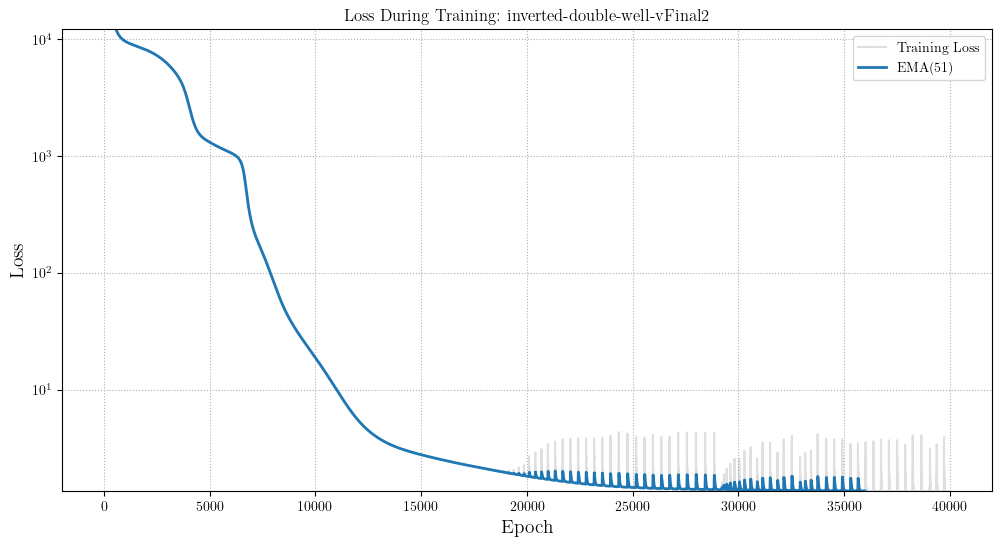

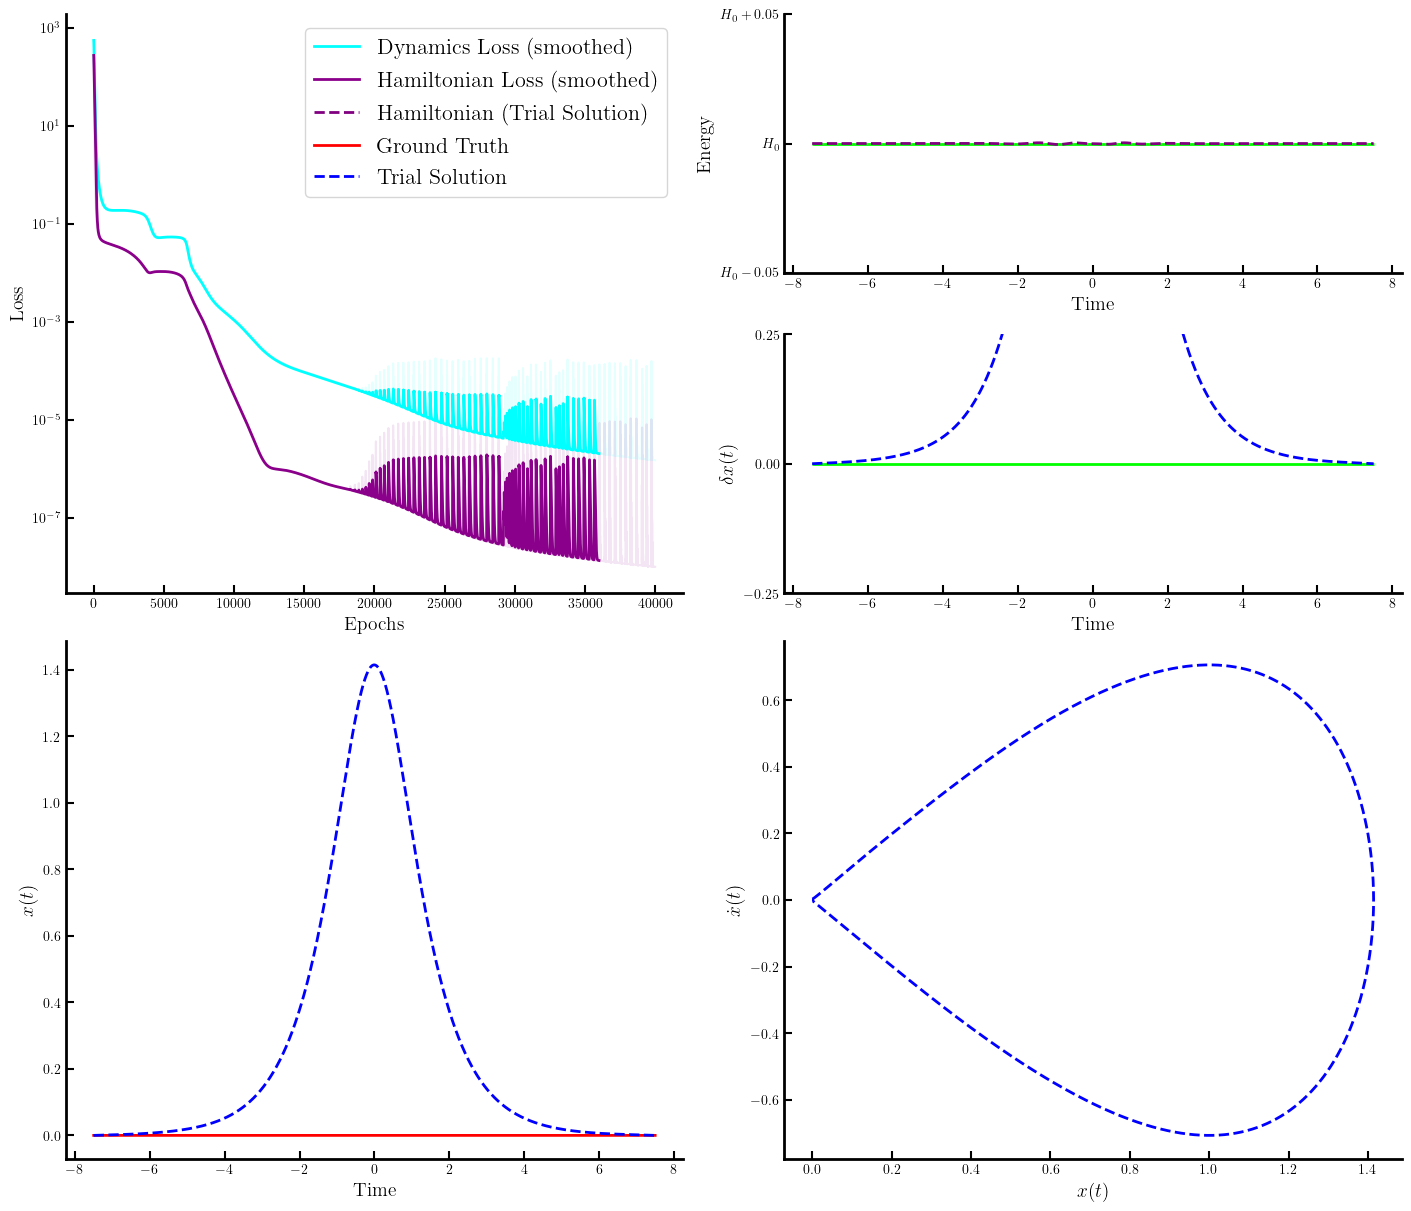

In [5]:
def main():
    lr_grid      = [1e-3, 1e-4, 1e-5]
    coeffs_grid = [(1.0, 1.0, 1.0)]

    for lr in lr_grid:
        for _coeffs in coeffs_grid:
            boundary_type = "dirichlet"
            configuration = Configuration(
                seed=4235,
                features=[64, 64, 64, 64, 64],
                activation_function=th.nn.Tanh(),
                learning_rate=lr,
                epochs =40_000,
                steps=15_000,
            )

            equations = InvertedDoubleWellEquation(
                function="x",
                domain=(-7.5,7.5),
                initial_conditions={
                    "x": (-7.5, 0),
                    "y": (7.5, 0),
                },
                coeffs = _coeffs,
                boundary_type=boundary_type
            )

            model = Model(
                name="inverted-double-well-vFinal2",
                configuration=configuration,
                system_equations=equations,
            )

            model.train()
            model.test2()

if __name__ == "__main__":
    main()